# Import Libraries & Data

In [1]:
# Our libraries help with EDA, visualization and time series modeling.
# The following libraries aid in visualization & EDA:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt
plt.style.use('ggplot')
%matplotlib inline
# The following tools aid in time series analysis:
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
import itertools
from matplotlib.pylab import rcParams
plt.style.use('ggplot')
import statsmodels.api as sm

In [4]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name != 'year':
            # Min-Max Scale If it Is Not the Year Column
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [5]:
def train_test(df):
    #Set training data before 2000
    train = df[:'2000']
    #Set test data starting 2000
    test = df['2000':]
    return train, test

In [6]:
def fit_model(df,pdq,pdqs):
    # Use train_test function
    train, test = train_test(df)
    # Fit the model, give the summary information & diagnostics
    model = SARIMAX(train,order=pdq,seasonal_order=pdqs)
    results = model.fit()
    results.summary
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show();
    return train, test, results

In [7]:
def train_RMSE(train, results, display = True):
    # Validate Training Data on 40 Years of Data
    train_pred = results.predict(-40)
    # Compare Real Training Data to Predicted Data
    rmse = sqrt(MSE(train[-40:],train_pred))
    print(f'SARIMA model RMSE on train data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(15,7))
        train[-60:].plot(label='Actual',color='b')
        train_pred.plot(label='Predicted',color='r')
        plt.legend(loc='best')
        plt.title('Actual Train Data vs. Predicted Prevalence')
        plt.show()
def test_RMSE(df,pdq,pdqs, display=True):
    X = df.values
    train, test = X[:-40],X[-40:]
    history = [x for x in train]
    predictions = []
    # Use for loop to simulate the model on test data and grab the RMSE
    for t in range(len(test)):
        model = SARIMAX(history, order=pdq,seasonal_order=pdqs)
        fit_model = model.fit(disp=0)
        output = fit_model.forecast()
        # .forecast () gives array of out of sample forecasts
        yhat = output[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = sqrt(MSE(test, predictions))
    # Review: RMSE = Square root of the average squared difference between estimated values and the actual value. 
    print('SARIMA model RMSE on test data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        plt.title('Actual Test Data vs. Predictions')
        plt.plot(history[-40:],label='Actual', color='b')
        plt.plot(predictions,label='Predictions',color='r')
        plt.legend(loc='best')
        plt.show()

In [70]:
def forecast_model(df,pdq,pdqs, display=True):
    model = SARIMAX(df, order=pdq,seasonal_order=pdqs)
    fit_model = model.fit()
    output = fit_model.get_prediction(start='2020',end='2025', dynamic=True)
    # Dynamic forecasting pretends that you don't have any information about the dependent variable 
    # during the period covered by the sample forecast—even when you do have the relevant data.
    forecast_ci = output.conf_int()
    if display:
        fig, ax = plt.subplots(figsize=(13,6))
        output.predicted_mean.plot(label='Forecast')
        ax.fill_between(forecast_ci.index,forecast_ci.iloc[:, 0],forecast_ci.iloc[:, 1],
                        color='k', alpha=.25,label='Conf Interval')
        plt.title('Forecast of Prevalence')
        plt.xlabel('Time')
        plt.legend(loc='best')
        plt.show()
    year_1= (1+output.predicted_mean[:2]).prod()
    year_3=(1+output.predicted_mean[:4]).prod()
    year_5= (1+output.predicted_mean[:6]).prod()
    print(f'Total expected increase in prevalence in 1 year: {year_1}%')
    print(f'Total expected increase in prevalence in 3 years: {year_3}%')
    print(f'Total expected increase in prevalence in 5 year: {year_5}%')
    tot_prev = [year_1,year_3,year_5]
    return tot_prev

# Read in Data & Begin Pre-Processing

In [9]:
df = pd.read_csv('data.csv')

df.head()

acousticness                                   artists  danceability  \
0         0.995                       ['Carl Woitschach']         0.708   
1         0.994  ['Robert Schumann', 'Vladimir Horowitz']         0.379   
2         0.604                   ['Seweryn Goszczyński']         0.749   
3         0.995                      ['Francisco Canaro']         0.781   
4         0.990  ['Frédéric Chopin', 'Vladimir Horowitz']         0.210   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       158648  0.1950         0  6KbQ3uYMLKb5jDxLF7wYDD             0.563   
1       282133  0.0135         0  6KuQTIu1KoTTkLXKrwlLPV             0.901   
2       104300  0.2200         0  6L63VW0PibdM1HDSBoqnoM             0.000   
3       180760  0.1300         0  6M94FkXd15sOAOQYRnWPN8             0.887   
4       687733  0.2040         0  6N6tiFZ9vLTSOIxkj8qKrd             0.908   

   key  liveness  loudness  mode  \
0   10    0.1510   -12.428     1   
1    8    0.0763   -28.454     1   
2    5    0.1190   -19.924     0   
3    1    0.1110   -14.734     0   
4   11    0.0980   -16.829     1   

                                            name  popularity release_date  \
0                    Singende Bataillone 1. Teil           0         1928   
1       Fantasiestücke, Op. 111: Più tosto lento           0         1928   
2                 Chapter 1.18 - Zamek kaniowski           0         1928   
3  Bebamos Juntos - Instrumental (Remasterizado)           0   1928-09-25   
4    Polonaise-Fantaisie in A-Flat Major, Op. 61           1         1928   

   speechiness    tempo  valence  year  
0       0.0506  118.469   0.7790  1928  
1       0.0462   83.972   0.0767  1928  
2       0.9290  107.177   0.8800  1928  
3       0.0926  108.003   0.7200  1928  
4       0.0424   62.149   0.0693  1928

In [10]:
df['year'].nunique()

100

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169909 entries, 0 to 169908
Data columns (total 19 columns):
acousticness        169909 non-null float64
artists             169909 non-null object
danceability        169909 non-null float64
duration_ms         169909 non-null int64
energy              169909 non-null float64
explicit            169909 non-null int64
id                  169909 non-null object
instrumentalness    169909 non-null float64
key                 169909 non-null int64
liveness            169909 non-null float64
loudness            169909 non-null float64
mode                169909 non-null int64
name                169909 non-null object
popularity          169909 non-null int64
release_date        169909 non-null object
speechiness         169909 non-null float64
tempo               169909 non-null float64
valence             169909 non-null float64
year                169909 non-null int64
dtypes: float64(9), int64(6), object(4)
memory usage: 24.6+ MB


In [12]:
df.head()

acousticness                                   artists  danceability  \
0         0.995                       ['Carl Woitschach']         0.708   
1         0.994  ['Robert Schumann', 'Vladimir Horowitz']         0.379   
2         0.604                   ['Seweryn Goszczyński']         0.749   
3         0.995                      ['Francisco Canaro']         0.781   
4         0.990  ['Frédéric Chopin', 'Vladimir Horowitz']         0.210   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       158648  0.1950         0  6KbQ3uYMLKb5jDxLF7wYDD             0.563   
1       282133  0.0135         0  6KuQTIu1KoTTkLXKrwlLPV             0.901   
2       104300  0.2200         0  6L63VW0PibdM1HDSBoqnoM             0.000   
3       180760  0.1300         0  6M94FkXd15sOAOQYRnWPN8             0.887   
4       687733  0.2040         0  6N6tiFZ9vLTSOIxkj8qKrd             0.908   

   key  liveness  loudness  mode  \
0   10    0.1510   -12.428     1   
1    8    0.0763   -28.454     1   
2    5    0.1190   -19.924     0   
3    1    0.1110   -14.734     0   
4   11    0.0980   -16.829     1   

                                            name  popularity release_date  \
0                    Singende Bataillone 1. Teil           0         1928   
1       Fantasiestücke, Op. 111: Più tosto lento           0         1928   
2                 Chapter 1.18 - Zamek kaniowski           0         1928   
3  Bebamos Juntos - Instrumental (Remasterizado)           0   1928-09-25   
4    Polonaise-Fantaisie in A-Flat Major, Op. 61           1         1928   

   speechiness    tempo  valence  year  
0       0.0506  118.469   0.7790  1928  
1       0.0462   83.972   0.0767  1928  
2       0.9290  107.177   0.8800  1928  
3       0.0926  108.003   0.7200  1928  
4       0.0424   62.149   0.0693  1928

# How do the Four Most Popular & Four Most Niche Features Change Over Time?

## DataFrame of Annual Avg of Four Most Popular Features

In [13]:
annual_avg_pop = df[["acousticness","loudness","energy","valence", "year"]].\
groupby("year").mean().sort_values(by="year").reset_index()

annual_avg_pop.head()

year  acousticness   loudness    energy   valence
0  1921      0.895823 -17.095438  0.236784  0.425495
1  1922      0.939236 -19.179958  0.237026  0.534056
2  1923      0.976329 -14.373882  0.246936  0.624788
3  1924      0.935575 -14.202304  0.347033  0.668574
4  1925      0.965422 -14.516707  0.264373  0.616430

## DataFrame of Annual Avg of Four Most Niche Features

In [14]:
annual_avg_niche = df[["mode","speechiness","tempo","liveness","year"]].\
groupby("year").mean().sort_values(by="year").reset_index()

annual_avg_niche.head()

year      mode  speechiness       tempo  liveness
0  1921  0.656250     0.077258  100.397758  0.215814
1  1922  0.625000     0.115419  101.376139  0.238647
2  1923  0.775148     0.098619  112.456598  0.236656
3  1924  0.751055     0.090210  120.653359  0.237875
4  1925  0.718631     0.115457  115.671715  0.243094

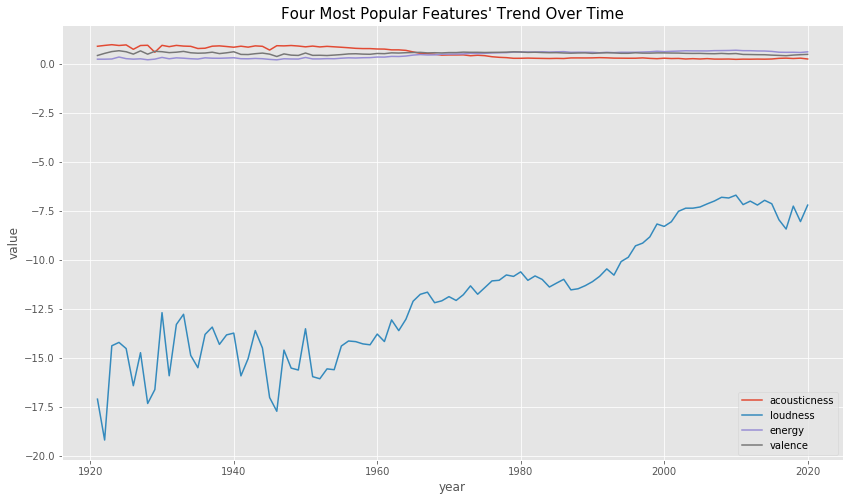

In [15]:
# Create a simple line plot for initial analysis
plt.figure(figsize=(14,8))
plt.title("Four Most Popular Features' Trend Over Time", fontdict={"fontsize": 15})

lines = ["acousticness","loudness","energy", 
         "valence"]

for line in lines:
    ax = sns.lineplot(x='year', y=line, data=annual_avg_pop)
    
    
plt.ylabel("value")
plt.legend(lines)

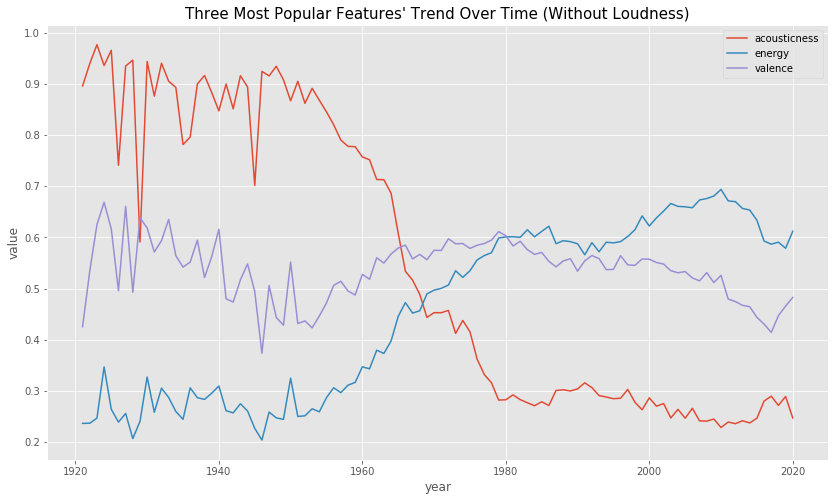

In [16]:
# Create a simple line plot for initial analysis
plt.figure(figsize=(14,8))
plt.title("Three Most Popular Features' Trend Over Time (Without Loudness)", fontdict={"fontsize": 15})

lines = ["acousticness","energy", 
         "valence"]

for line in lines:
    ax = sns.lineplot(x='year', y=line, data=annual_avg_pop)
    
    
plt.ylabel("value")
plt.legend(lines)

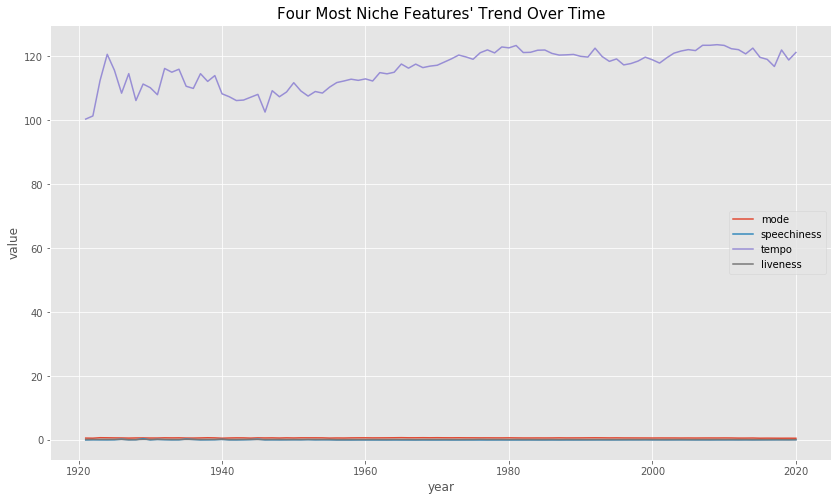

In [17]:
# Create a simple line plot for initial analysis
plt.figure(figsize=(14,8))
plt.title("Four Most Niche Features' Trend Over Time", fontdict={"fontsize": 15})

lines = ["mode","speechiness","tempo", 
         "liveness"]

for line in lines:
    ax = sns.lineplot(x='year', y=line, data=annual_avg_niche)
    
    
plt.ylabel("value")
plt.legend(lines)

In [18]:
df2 = normalize(annual_avg_pop)

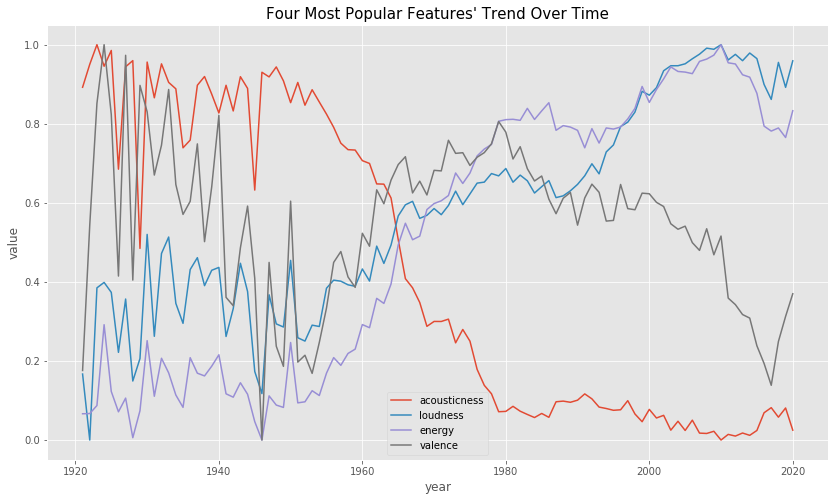

In [19]:
# Create a simple line plot for initial analysis
plt.figure(figsize=(14,8))
plt.title("Four Most Popular Features' Trend Over Time", fontdict={"fontsize": 15})

lines = ["acousticness","loudness","energy", 
         "valence"]

for line in lines:
    ax = sns.lineplot(x='year', y=line, data=df2)
    
    
plt.ylabel("value")
plt.legend(lines)

In [20]:
df3 = normalize(annual_avg_niche)

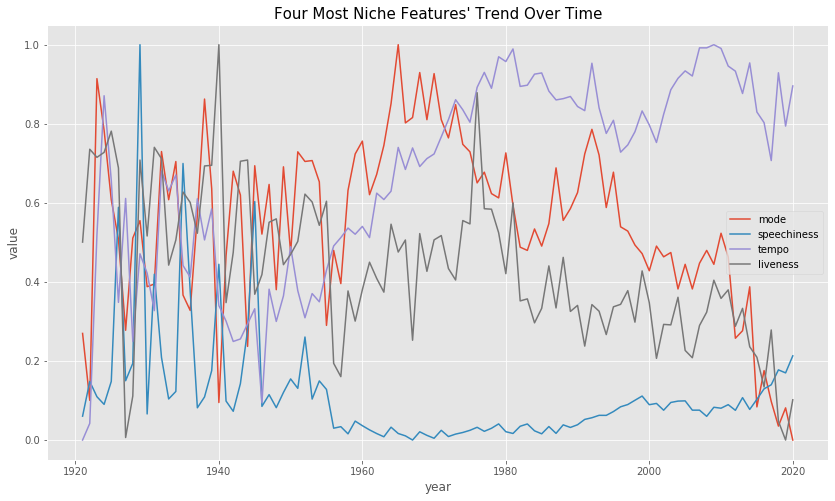

In [21]:
# Create a simple line plot for initial analysis
plt.figure(figsize=(14,8))
plt.title("Four Most Niche Features' Trend Over Time", fontdict={"fontsize": 15})

lines = ["mode","speechiness","tempo", 
         "liveness"]

for line in lines:
    ax = sns.lineplot(x='year', y=line, data=df3)
    
    
plt.ylabel("value")
plt.legend(lines)

In [22]:
df2.index

RangeIndex(start=0, stop=100, step=1)

In [23]:
df2.year=pd.to_datetime(df2.year, format='%Y')

In [24]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
year            100 non-null datetime64[ns]
acousticness    100 non-null float64
loudness        100 non-null float64
energy          100 non-null float64
valence         100 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 4.0 KB


In [25]:
df2.head()

year  acousticness  loudness    energy   valence
0 1921-01-01      0.892317  0.166953  0.066466  0.175866
1 1922-01-01      0.950385  0.000000  0.066962  0.543930
2 1923-01-01      1.000000  0.384927  0.087209  0.851547
3 1924-01-01      0.945488  0.398669  0.291720  1.000000
4 1925-01-01      0.985411  0.373488  0.122834  0.823213

In [26]:
df2.set_index('year', inplace=True)
df2.head()

acousticness  loudness    energy   valence
year                                                  
1921-01-01      0.892317  0.166953  0.066466  0.175866
1922-01-01      0.950385  0.000000  0.066962  0.543930
1923-01-01      1.000000  0.384927  0.087209  0.851547
1924-01-01      0.945488  0.398669  0.291720  1.000000
1925-01-01      0.985411  0.373488  0.122834  0.823213

In [27]:
df3.head()

year      mode  speechiness     tempo  liveness
0  1921  0.269679     0.060355  0.000000  0.500619
1  1922  0.100310     0.148239  0.042065  0.735560
2  1923  0.914085     0.109548  0.518458  0.715068
3  1924  0.783504     0.090182  0.870869  0.727611
4  1925  0.607774     0.148326  0.656688  0.781311

In [28]:
df3.year=pd.to_datetime(df3.year, format='%Y')

In [29]:
df3.head()

year      mode  speechiness     tempo  liveness
0 1921-01-01  0.269679     0.060355  0.000000  0.500619
1 1922-01-01  0.100310     0.148239  0.042065  0.735560
2 1923-01-01  0.914085     0.109548  0.518458  0.715068
3 1924-01-01  0.783504     0.090182  0.870869  0.727611
4 1925-01-01  0.607774     0.148326  0.656688  0.781311

In [30]:
df3.set_index('year', inplace=True)
df3.head()

mode  speechiness     tempo  liveness
year                                                 
1921-01-01  0.269679     0.060355  0.000000  0.500619
1922-01-01  0.100310     0.148239  0.042065  0.735560
1923-01-01  0.914085     0.109548  0.518458  0.715068
1924-01-01  0.783504     0.090182  0.870869  0.727611
1925-01-01  0.607774     0.148326  0.656688  0.781311

In [31]:
df2.isna().sum()

acousticness    0
loudness        0
energy          0
valence         0
dtype: int64

In [32]:
df3.isna().sum()

mode           0
speechiness    0
tempo          0
liveness       0
dtype: int64

In [33]:
df_ts = []
for column in df2:
    #Create separate dataframes for each category
    df = df2[column]
    df = df.to_frame()
    df_ts.append(df)
df_ts[0].head()

acousticness
year                    
1921-01-01      0.892317
1922-01-01      0.950385
1923-01-01      1.000000
1924-01-01      0.945488
1925-01-01      0.985411

In [34]:
type(df_ts[0])

pandas.core.frame.DataFrame

In [35]:
df_ts[0].head()

acousticness
year                    
1921-01-01      0.892317
1922-01-01      0.950385
1923-01-01      1.000000
1924-01-01      0.945488
1925-01-01      0.985411

In [36]:
df_ts2 = []
for column in df3:
    #Create separate dataframes for each zipcode with a monthly frequency.
    df = df3[column]
    df = df.to_frame()
    df_ts2.append(df)
df_ts2[0].head()

mode
year                
1921-01-01  0.269679
1922-01-01  0.100310
1923-01-01  0.914085
1924-01-01  0.783504
1925-01-01  0.607774

In [39]:
df_ts[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 1921-01-01 to 2020-01-01
Data columns (total 1 columns):
acousticness    100 non-null float64
dtypes: float64(1)
memory usage: 1.6 KB


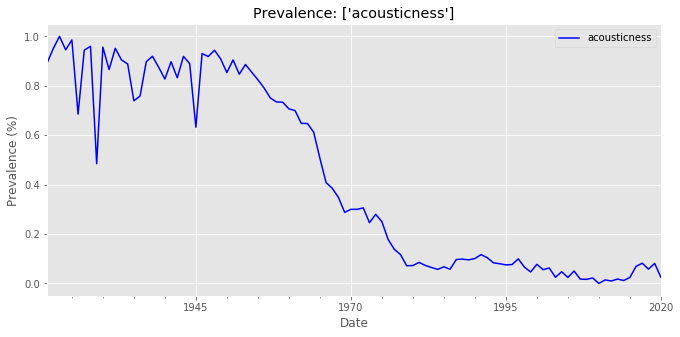

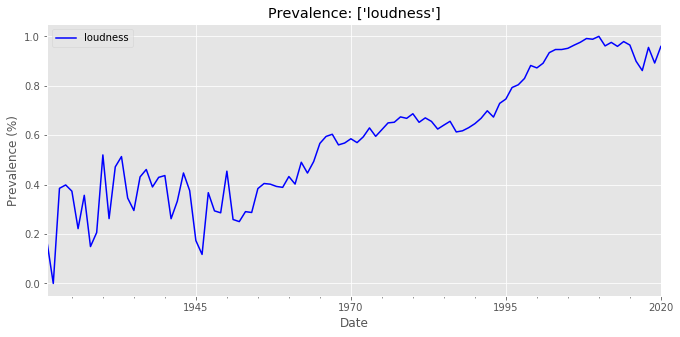

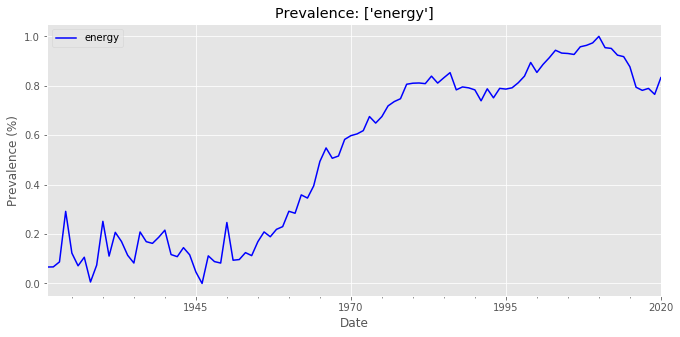

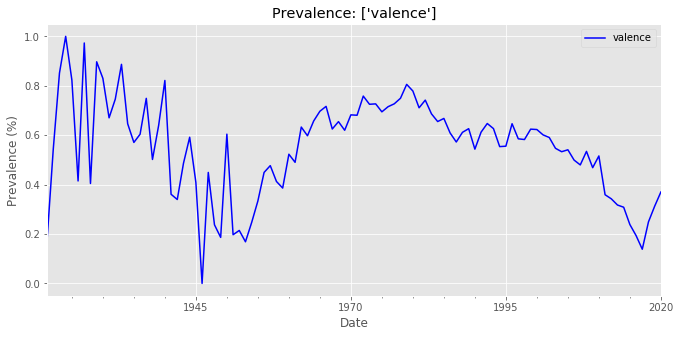

In [45]:
for i in range(len(df_ts)):
    df_ts[i].plot(figsize=(11,5), color = 'b')
    plt.title(f'Prevalence: {df_ts[i].columns.to_list()}')
    plt.xlabel('Date')
    plt.ylabel('Prevalence (%)')
    plt.legend(loc='best')
    plt.show()

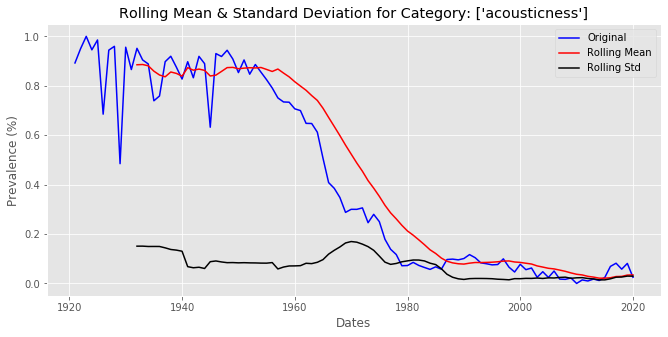

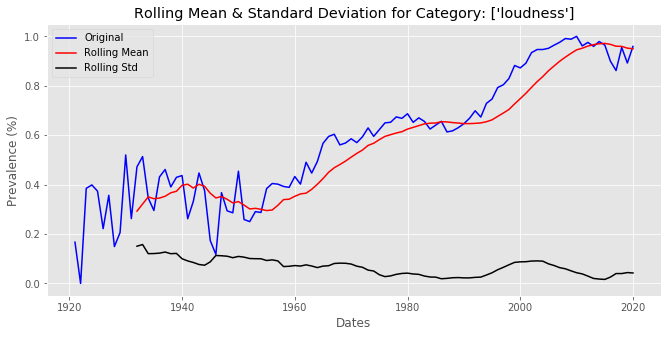

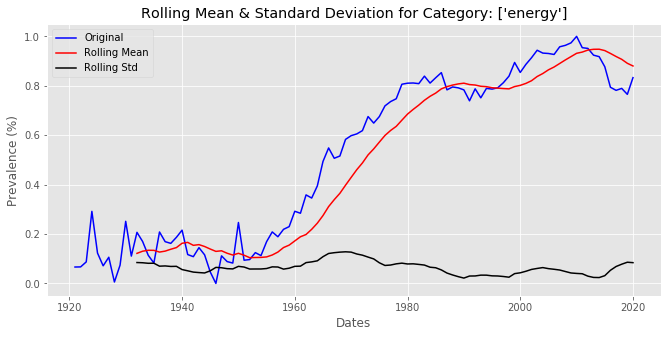

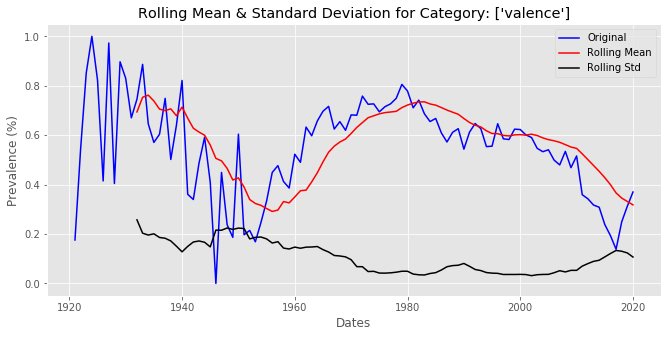

In [47]:
for i in range(len(df_ts)):
    rollingmean = df_ts[i].rolling(window = 12, center = False).mean()
    rollingstd = df_ts[i].rolling(window = 12, center = False).std()
    fig = plt.figure(figsize=(11,5))
    orig = plt.plot(df_ts[i], color='blue',label='Original')
    mean = plt.plot(rollingmean, color='red', label='Rolling Mean')
    std = plt.plot(rollingstd, color='black', label = 'Rolling Std')
    plt.xlabel('Dates')
    plt.ylabel('Prevalence (%)')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for Category: {df_ts[i].columns.to_list()}')
    plt.show()

In [48]:
acous_ts = df_ts[0] # Acousticness Prevalence Time Series

loudness_ts = df_ts[1] # Loudness Prevalence Time Series

energy_ts = df_ts[2] # Energy Prevalence Time Series

valence_ts = df_ts[3]# # Valence Prevalence Time Series

In [49]:
mode_ts = df_ts2[0] # Mode Prevalence Time Series

speechiness_ts = df_ts2[1] # Speechiness Prevalence Time Series

tempo_ts = df_ts2[2] # Tempo Time Series

liveness_ts = df_ts2[3] # Degree of Liveness Time Series

# Time Series Models for Popular Features

## Workflow for Our Models:

1. Visualize the Time Series
1. Use auto_arima to find the best order & seasonal order (if it exists) for the ARIMA (or SARIMA) model
1. Fit the model
1. Examine results & residual analysis
1. Use the train & test RMSE for validation
1. Forecast future values
1. Repeat for each additional time series 

## Acousticness

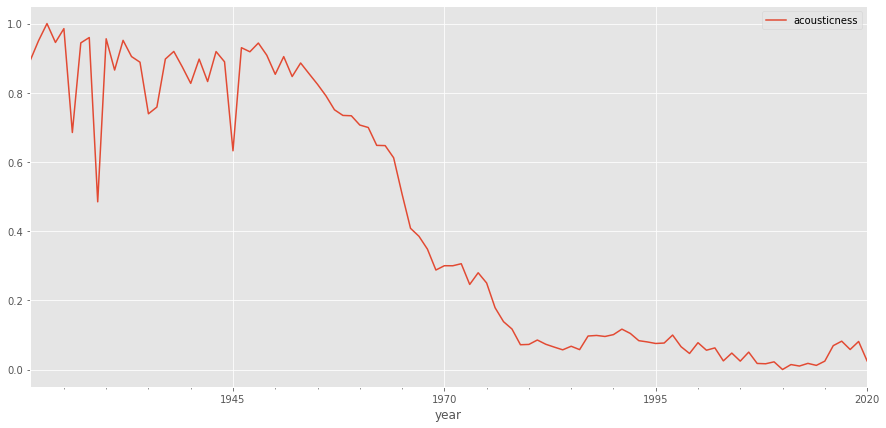

In [50]:
acous_ts.plot(figsize=(15,7))

In [51]:
import pmdarima as pm

In [52]:
#Use auto arima function to find the best non-seasonal and seasonal parameters to fit the model.
results = pm.auto_arima(acous_ts,information_criterion='aic', seasonal_test = 'df',
                        start_p=1,start_q=1, max_p=4, max_q=4,stepwise=True,trace=True,
                        error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-177.473, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-202.141, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-209.978, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-178.665, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-210.633, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-207.772, Time=0.48 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-209.859, Time=0.45 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-211.315, Time=0.52 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-210.158, Time=0.52 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-209.385, Time=0.58 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-208.678, Time=0.64 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-211.624, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-211.120, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : A

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

                               SARIMAX Results                                
Dep. Variable:           acousticness   No. Observations:                   80
Model:               SARIMAX(2, 1, 2)   Log Likelihood                  79.007
Date:                Wed, 21 Oct 2020   AIC                           -148.014
Time:                        15:49:50   BIC                           -136.166
Sample:                    01-01-1921   HQIC                          -143.267
                         - 01-01-2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1092      0.179     -6.206      0.000      -1.460      -0.759
ar.L2         -0.4173      0.176     -2.374      0.018      -0.762      -0.073
ma.L1          0.5394      0.216      2.499      0.0

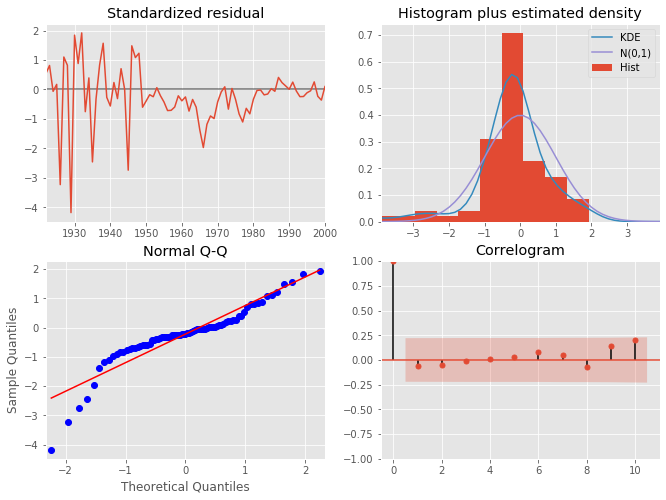

In [55]:
#Fit the SARIMA model and get results.
pdq = (2,1,2)
pdqs = (0,0,0,0)
train, test, results = fit_model(acous_ts,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.05358


<Figure size 1080x504 with 0 Axes>

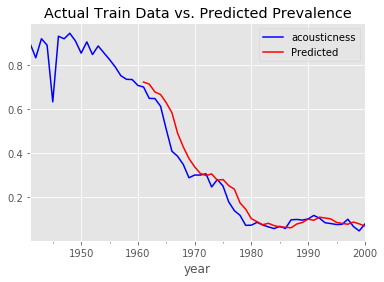

In [56]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.02066


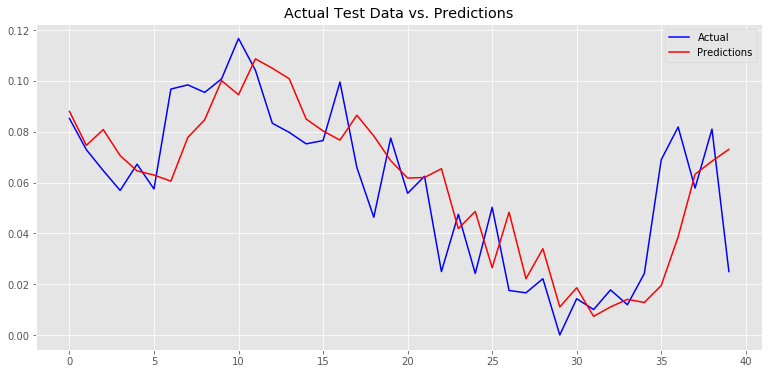

In [58]:
test_RMSE(acous_ts,pdq=pdq,pdqs=pdqs, display=True)

### RMSE Results for Acousticness:

- Train: 0.05358
- Test: 0.02066

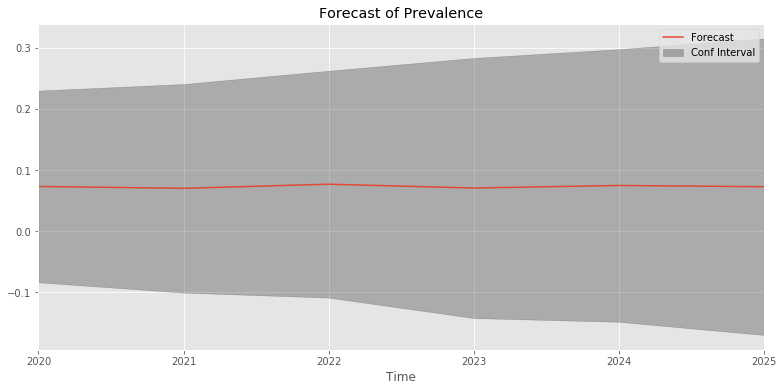

Total expected increase in prevalence in 1 year: 1.1481025008687746%
Total expected increase in prevalence in 3 years: 1.3232997269350408%
Total expected increase in prevalence in 5 year: 1.5252927751240068%


In [72]:
acous_prev=forecast_model(acous_ts,pdq=pdq,pdqs=pdqs)

## Loudness

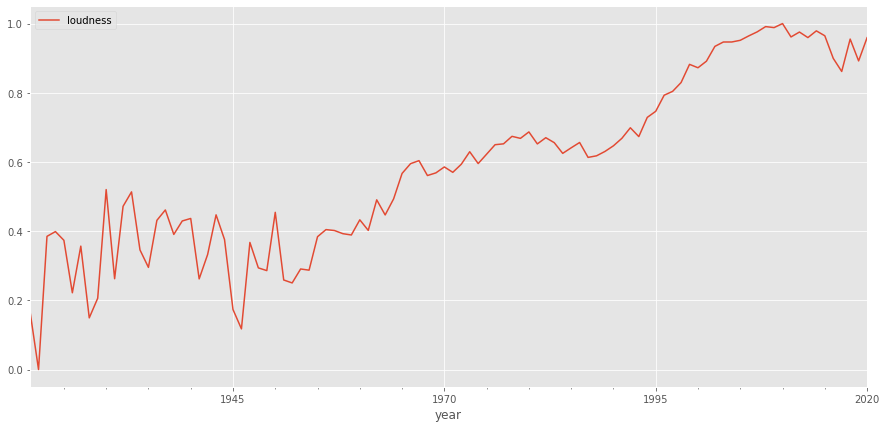

In [73]:
loudness_ts.plot(figsize=(15,7))

In [74]:
#Use auto arima function to find the best non-seasonal and seasonal parameters to fit the model.
results = pm.auto_arima(loudness_ts,information_criterion='aic',
                        start_p=1,start_q=1, max_p=4, max_q=4,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-186.846, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-199.193, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-213.420, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-188.105, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-212.182, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-215.957, Time=0.23 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-215.136, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-215.315, Time=0.38 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-216.619, Time=0.25 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-214.928, Time=0.42 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-212.619, Time=0.54 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-214.567, Time=0.12 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 2.648 seconds


ARIMA(order=(0, 1, 3), scoring_args={}, suppress_warnings=True)

                               SARIMAX Results                                
Dep. Variable:               loudness   No. Observations:                   80
Model:               SARIMAX(0, 1, 3)   Log Likelihood                  82.177
Date:                Wed, 21 Oct 2020   AIC                           -156.353
Time:                        16:18:05   BIC                           -146.875
Sample:                    01-01-1921   HQIC                          -152.556
                         - 01-01-2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5397      0.104     -5.206      0.000      -0.743      -0.337
ma.L2         -0.5229      0.107     -4.895      0.000      -0.732      -0.314
ma.L3          0.5233      0.108      4.852      0.0

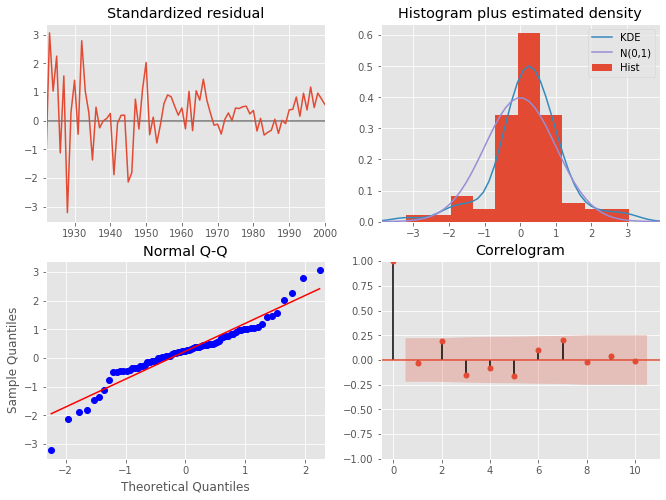

In [75]:
#Fit the ARIMA model and get results.
pdq = (0,1,3)
pdqs = (0,0,0,0)
train, test, results = fit_model(loudness_ts,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.04879


<Figure size 1080x504 with 0 Axes>

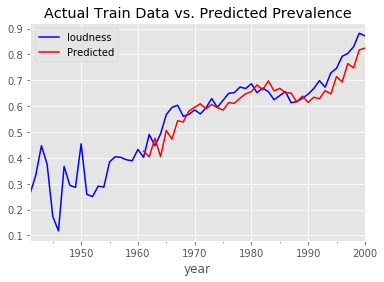

In [76]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.04779


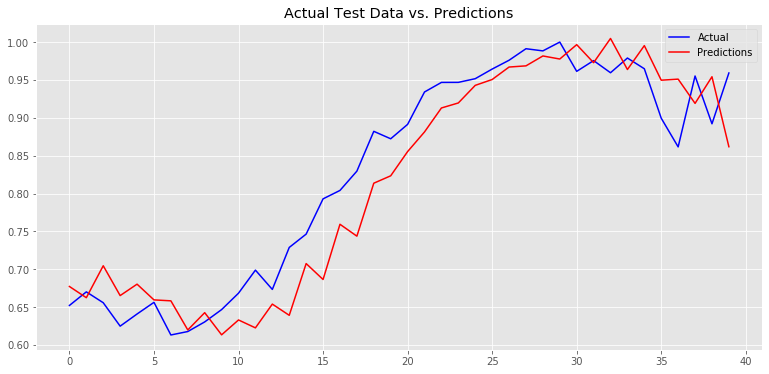

In [78]:
test_RMSE(loudness_ts,pdq=pdq,pdqs=pdqs)

### RMSE for Loudness Model:

- Train: 0.04879
- Test: 0.04779

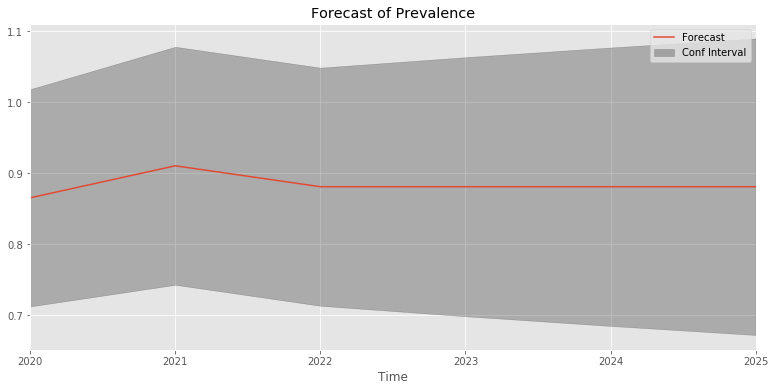

Total expected increase in prevalence in 1 year: 3.5640673062995574%
Total expected increase in prevalence in 3 years: 12.61139645658844%
Total expected increase in prevalence in 5 year: 44.625229244165034%


In [79]:
loudness_prev=forecast_model(loudness_ts,pdq=pdq,pdqs=pdqs)

## Energy Model

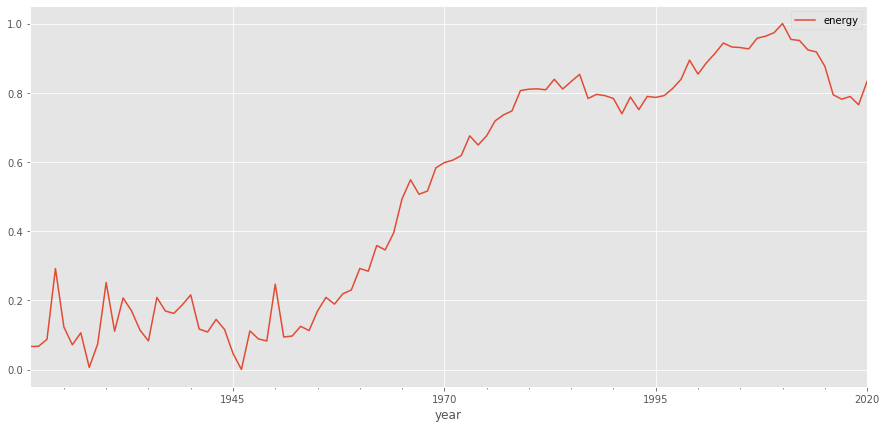

In [80]:
energy_ts.plot(figsize=(15,7))

In [81]:
#Use auto arima function to find the best non-seasonal and seasonal parameters to fit the model.
results = pm.auto_arima(energy_ts,information_criterion='aic',
                        start_p=1,start_q=1, max_p=4, max_q=4,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-276.303, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-283.668, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-285.871, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-276.598, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-283.985, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-282.673, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-283.979, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.876 seconds


ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

                               SARIMAX Results                                
Dep. Variable:                 energy   No. Observations:                   80
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 109.461
Date:                Wed, 21 Oct 2020   AIC                           -214.921
Time:                        16:20:41   BIC                           -210.182
Sample:                    01-01-1921   HQIC                          -213.023
                         - 01-01-2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3408      0.094     -3.607      0.000      -0.526      -0.156
sigma2         0.0037      0.000      8.766      0.000       0.003       0.004
Ljung-Box (Q):                       59.83   Jarque-

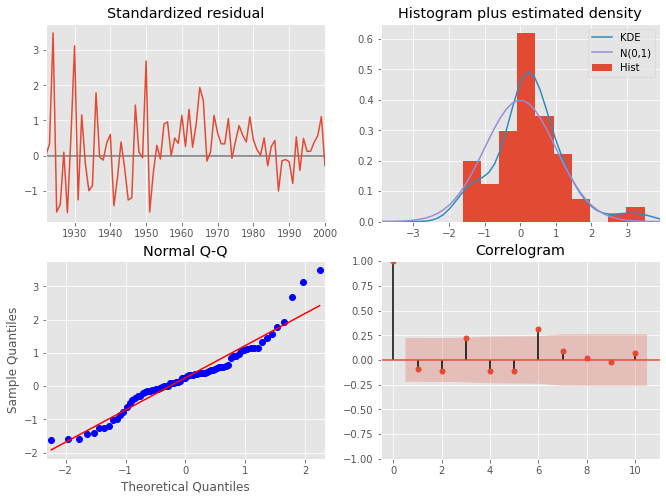

In [82]:
#Fit the ARIMA model and get results.
pdq = (0,1,1)
pdqs = (0,0,0,0)
train, test, results = fit_model(energy_ts,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.04234


<Figure size 1080x504 with 0 Axes>

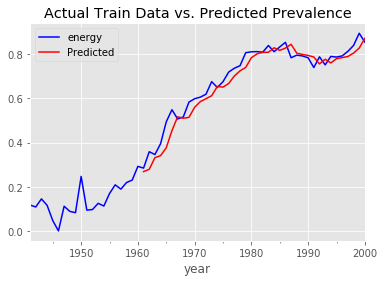

In [83]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.03339


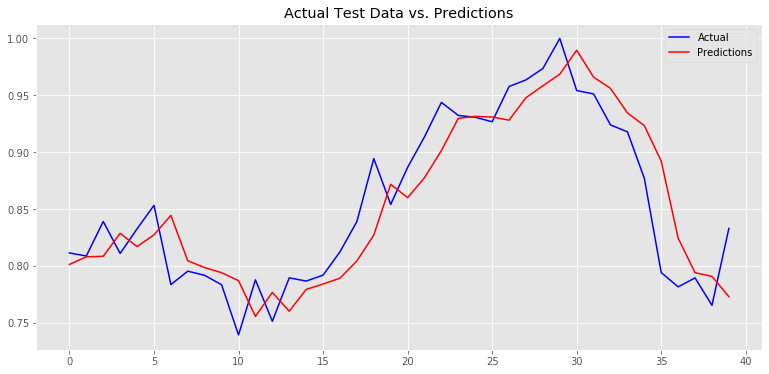

In [85]:
test_RMSE(energy_ts,pdq=pdq,pdqs=pdqs)

### Energy Model RMSE: 
- Train: 0.04234
- Test: 0.03339

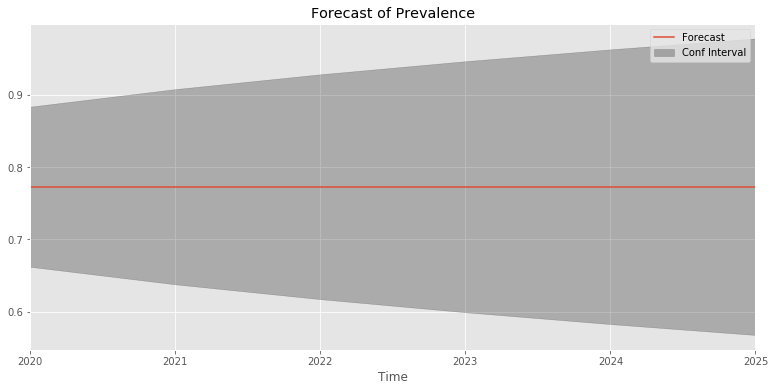

Total expected increase in prevalence in 1 year: 3.1434501550388037%
Total expected increase in prevalence in 3 years: 9.881278877213479%
Total expected increase in prevalence in 5 year: 31.06130761855837%


In [86]:
energy_prev = forecast_model(energy_ts, pdq=pdq,pdqs=pdqs)

## Valence Model

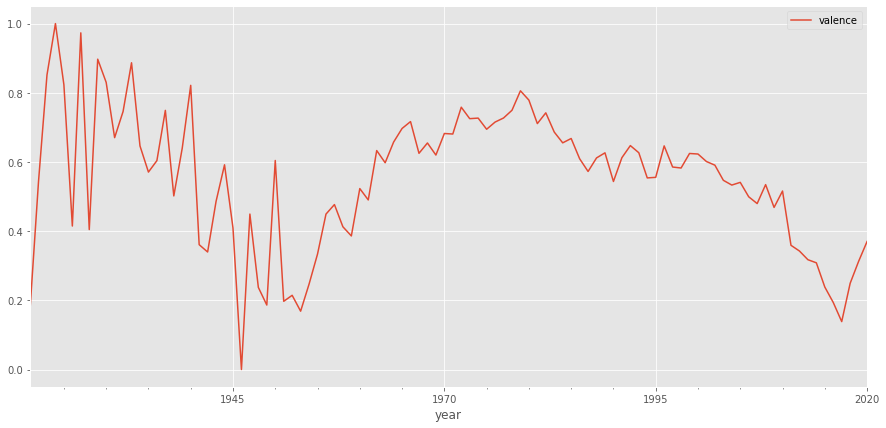

In [87]:
valence_ts.plot(figsize=(15,7))

In [88]:
#Use auto arima function to find the best non-seasonal and seasonal parameters to fit the model.
results = pm.auto_arima(valence_ts,information_criterion='aic',
                        start_p=1,start_q=1, max_p=4, max_q=4,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-37.137, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-84.218, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-63.761, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=178.877, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-91.952, Time=0.31 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-95.015, Time=0.13 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-93.501, Time=0.25 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-93.904, Time=0.41 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-95.046, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-103.214, Time=0.36 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-95.134, Time=0.28 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-92.198, Time=0.45 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-103.406, Time=0.60 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-96.410,

ARIMA(order=(2, 0, 3), scoring_args={}, suppress_warnings=True)

                               SARIMAX Results                                
Dep. Variable:                valence   No. Observations:                   80
Model:               SARIMAX(2, 0, 3)   Log Likelihood                  39.182
Date:                Wed, 21 Oct 2020   AIC                            -66.363
Time:                        16:30:48   BIC                            -52.071
Sample:                    01-01-1921   HQIC                           -60.633
                         - 01-01-2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3584      0.182      7.468      0.000       1.002       1.715
ar.L2         -0.3633      0.182     -1.994      0.046      -0.720      -0.006
ma.L1         -1.2660      0.208     -6.098      0.0

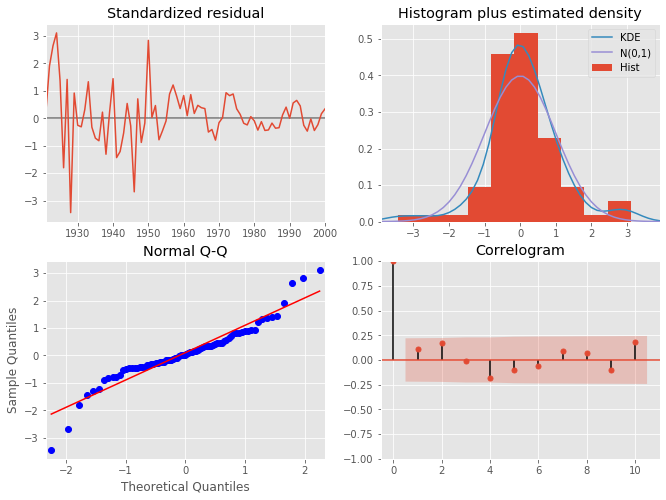

In [93]:
#Fit the ARIMA model and get results.
# Even though
pdq = (2,0,3)
pdqs = (0,0,0,0)
train, test, results = fit_model(valence_ts,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.06194


<Figure size 1080x504 with 0 Axes>

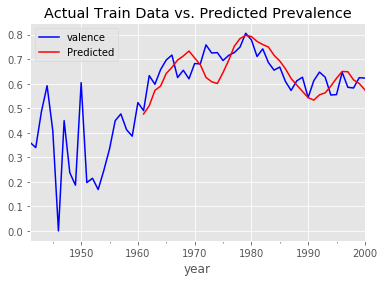

In [94]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.07999


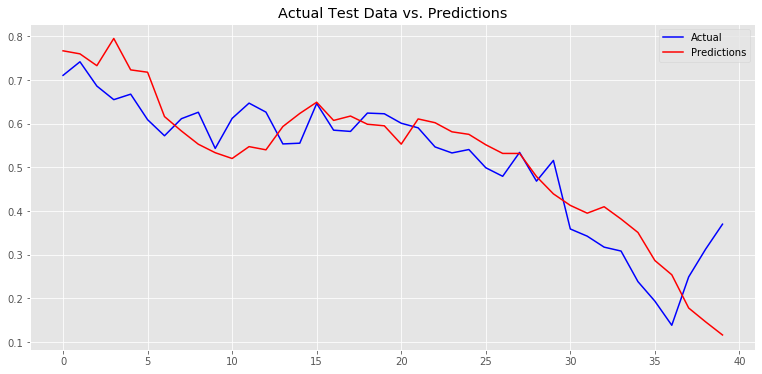

In [96]:
test_RMSE(valence_ts,pdq=pdq,pdqs=pdqs)

### Valence Model RMSE: 

- Train: 0.06194
- Test: 0.07999

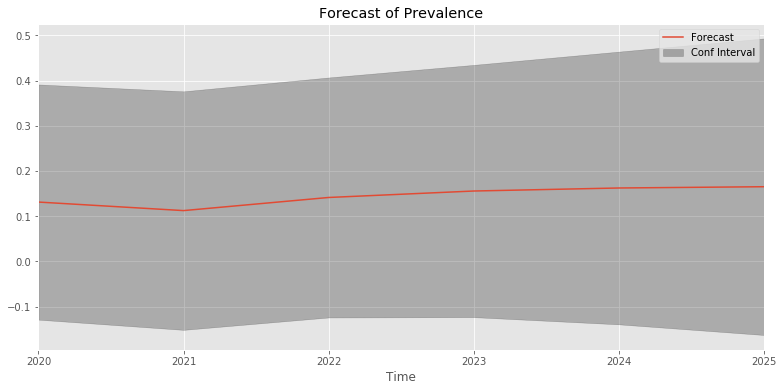

Total expected increase in prevalence in 1 year: 1.258074939442446%
Total expected increase in prevalence in 3 years: 1.6591421290117807%
Total expected increase in prevalence in 5 year: 2.2466610516626586%


In [97]:
valence_prev = forecast_model(valence_ts, pdq=pdq,pdqs=pdqs)

# Now for the Niche Features

## Mode

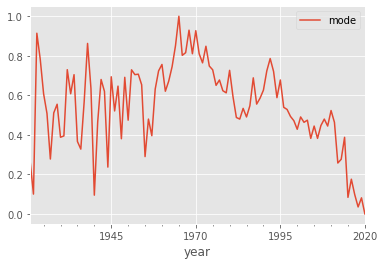

In [98]:
mode_ts.plot()

### Interpretation of this Time Series:

- Between 1920 and 1960 there was a lot of variance between the prevalence of major & minor scales
- Between 1960 and 1995 music trended closer to major scales for the majority of music
- Since 1995 we have seen a steep drop in major scales with a strong trend towards minor scales for the majority of the songs released.

In [99]:
#Use auto arima function to find the best non-seasonal and seasonal parameters to fit the model.
results = pm.auto_arima(mode_ts,information_criterion='aic', seasonal_test = 'df',
                        start_p=1,start_q=1, max_p=4, max_q=4,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-52.149, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-60.854, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-74.879, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-54.127, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-75.838, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-73.856, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-73.955, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-72.999, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-77.279, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-76.454, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-75.298, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-75.400, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-76.680, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-74.427, T

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

                               SARIMAX Results                                
Dep. Variable:                   mode   No. Observations:                   80
Model:               SARIMAX(0, 1, 2)   Log Likelihood                  29.193
Date:                Wed, 21 Oct 2020   AIC                            -52.386
Time:                        16:32:48   BIC                            -45.278
Sample:                    01-01-1921   HQIC                           -49.538
                         - 01-01-2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5995      0.132     -4.528      0.000      -0.859      -0.340
ma.L2         -0.2127      0.123     -1.731      0.083      -0.453       0.028
sigma2         0.0276      0.004      7.543      0.0

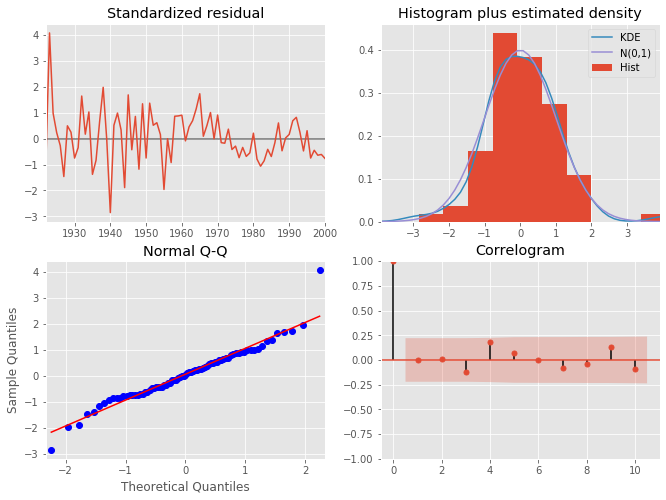

In [100]:
#Fit the ARIMA model and get results.
pdq = (0,1,2)
pdqs = (0,0,0,0)
train, test, results = fit_model(mode_ts,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.10663


<Figure size 1080x504 with 0 Axes>

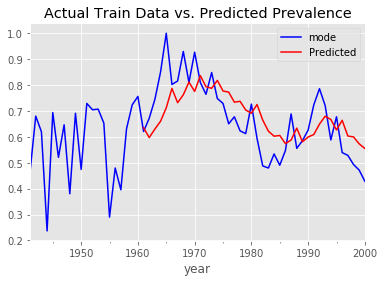

In [103]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.11354


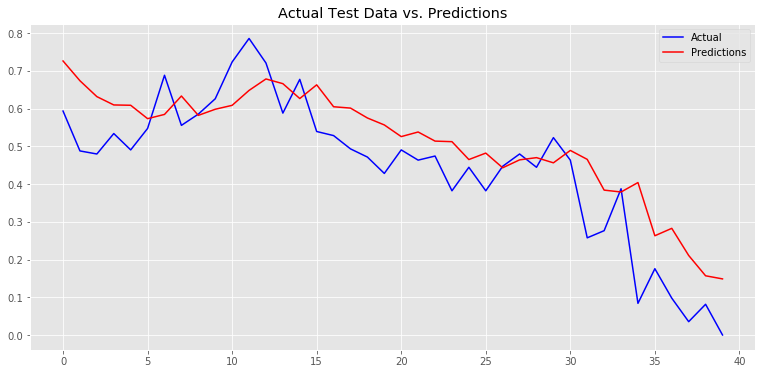

In [105]:
test_RMSE(mode_ts, pdq=pdq,pdqs=pdqs)

### RMSE for Mode Model: 

- Train: 0.10663
- Test: 0.11354

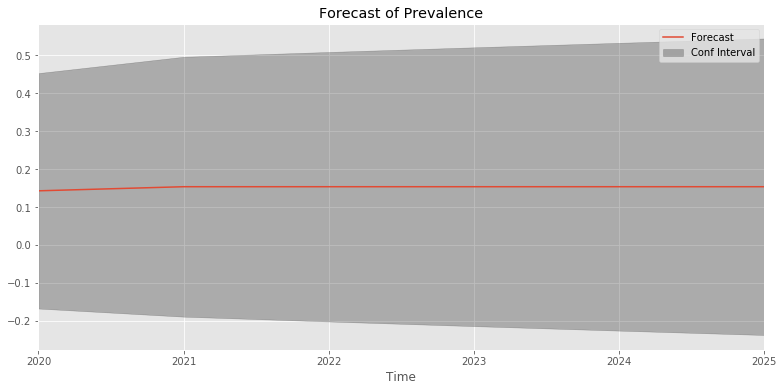

Total expected increase in prevalence in 1 year: 1.3180698699904783%
Total expected increase in prevalence in 3 years: 1.753732405224694%
Total expected increase in prevalence in 5 year: 2.333394776073144%


In [106]:
mode_prev = forecast_model(mode_ts, pdq=pdq, pdqs=pdqs)

## Speechiness Time Series

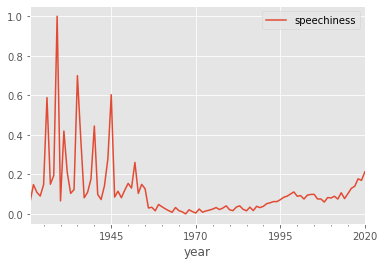

In [107]:
speechiness_ts.plot()

### Speechiness Analysis

- It seems that it was experimented with between 1920 and 1945
- In 1945 it took it's final deep dive, never to climb so high again
- It seems to be somewhat on the climb now
- This features could potentially be used to stand out

In [108]:
#Use auto arima function to find the best non-seasonal and seasonal parameters to fit the model.
results = pm.auto_arima(speechiness_ts,information_criterion='aic', seasonal_test = 'df',
                        start_p=1,start_q=1, max_p=4, max_q=4,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-51.820, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.714, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-109.177, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53.813, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-107.557, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-111.020, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-109.758, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-110.081, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-78.703, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-109.557, Time=0.16 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.084 seconds


ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

                               SARIMAX Results                                
Dep. Variable:            speechiness   No. Observations:                   80
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  37.409
Date:                Wed, 21 Oct 2020   AIC                            -70.819
Time:                        16:33:50   BIC                            -66.080
Sample:                    01-01-1921   HQIC                           -68.920
                         - 01-01-2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8510      0.081    -10.523      0.000      -1.009      -0.692
sigma2         0.0223      0.001     15.244      0.000       0.019       0.025
Ljung-Box (Q):                       27.44   Jarque-

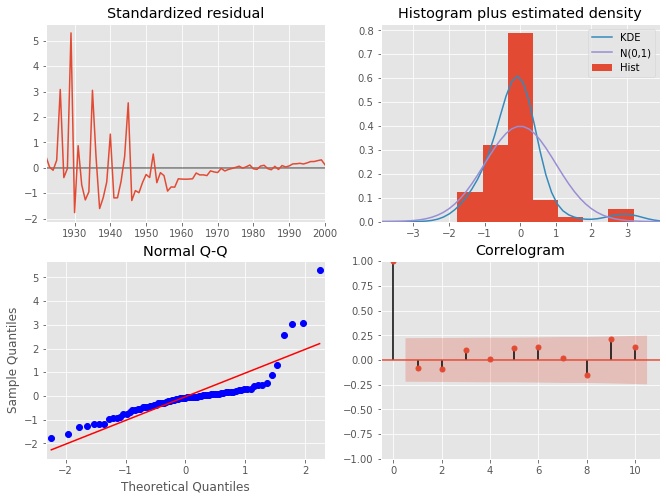

In [109]:
#Fit the ARIMA model and get results.
pdq = (0,1,1)
pdqs = (0,0,0,0)
train, test, results = fit_model(speechiness_ts,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.02896


<Figure size 1080x504 with 0 Axes>

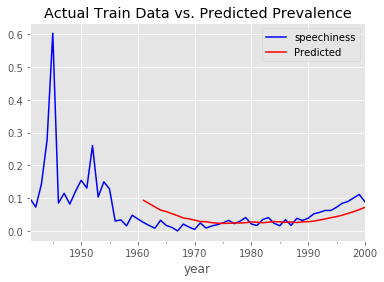

In [110]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.03013


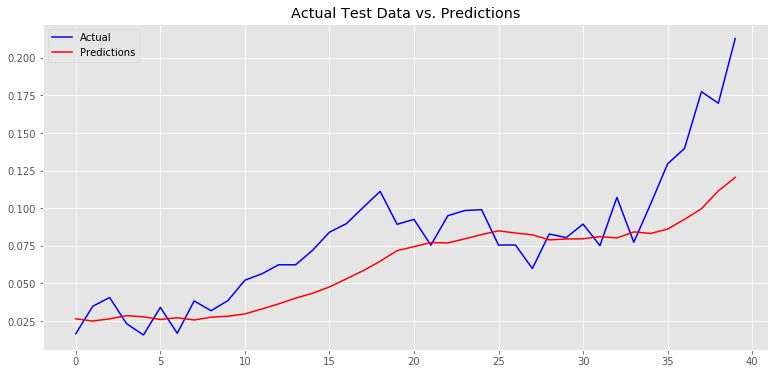

In [112]:
test_RMSE (speechiness_ts, pdq=pdq, pdqs=pdqs)

### RMSE for Speechiness Model:

- Train: 0.02896
- Test: 0.03013

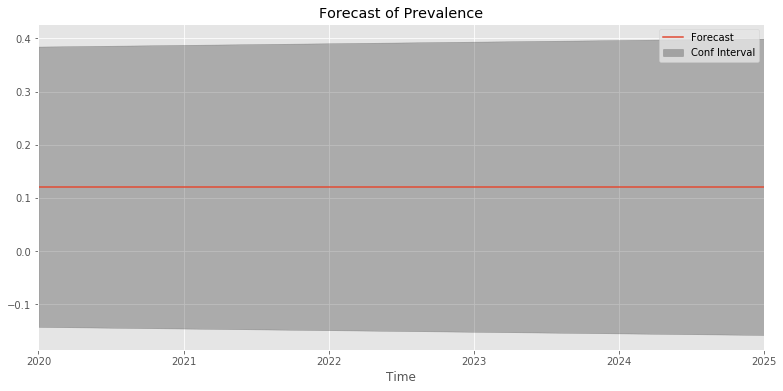

Total expected increase in prevalence in 1 year: 1.2567607036637838%
Total expected increase in prevalence in 3 years: 1.5794474662734888%
Total expected increase in prevalence in 5 year: 1.98498750911385%


In [113]:
speechiness_prev = forecast_model(speechiness_ts, pdq=pdq, pdqs=pdqs)

## Tempo Time Series

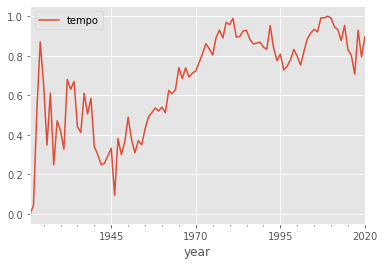

In [114]:
tempo_ts.plot()

### Tempo Analysis

- 1945 was the last year of the lowest tempo with a steady rise in quicker tempos ever since.
- Around the year 1980 and again between 2005-2010 we saw the highest tempos. (Q to answer: What are our max tempos?)

In [115]:
#Use auto arima function to find the best non-seasonal and seasonal parameters to fit the model.
results = pm.auto_arima(tempo_ts,information_criterion='aic', seasonal_test = 'df',
                        start_p=1,start_q=1, max_p=4, max_q=4,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-129.741, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-134.756, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-136.297, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-131.208, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-136.409, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-137.335, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-133.594, Time=0.41 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-132.475, Time=0.41 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-136.117, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-137.018, Time=0.31 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-135.845, Time=0.14 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 2.690 seconds


ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True)

                               SARIMAX Results                                
Dep. Variable:                  tempo   No. Observations:                   80
Model:               SARIMAX(1, 1, 2)   Log Likelihood                  51.559
Date:                Wed, 21 Oct 2020   AIC                            -95.117
Time:                        16:36:50   BIC                            -85.640
Sample:                    01-01-1921   HQIC                           -91.320
                         - 01-01-2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4767      0.337     -1.416      0.157      -1.136       0.183
ma.L1          0.1383      0.351      0.395      0.693      -0.549       0.825
ma.L2         -0.3753      0.128     -2.935      0.0

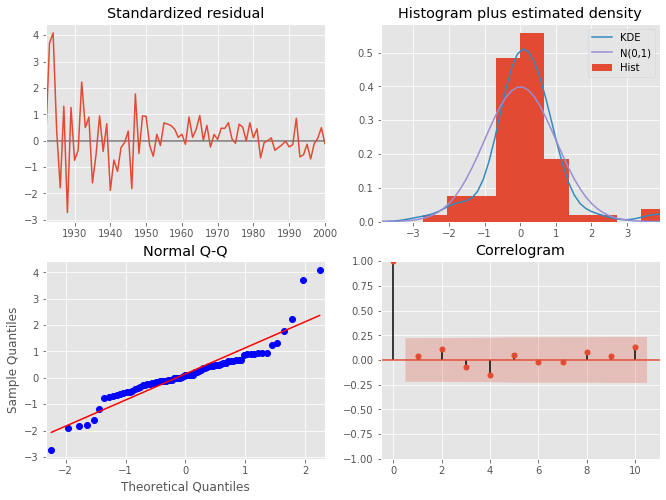

In [116]:
#Fit the ARIMA model and get results.
pdq = (1,1,2)
pdqs = (0,0,0,0)
train, test, results = fit_model(tempo_ts,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.05450


<Figure size 1080x504 with 0 Axes>

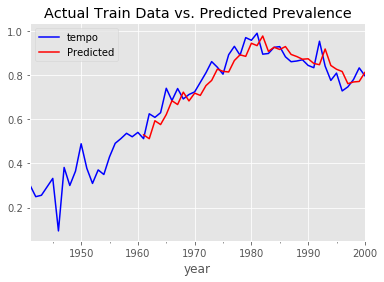

In [117]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.06669


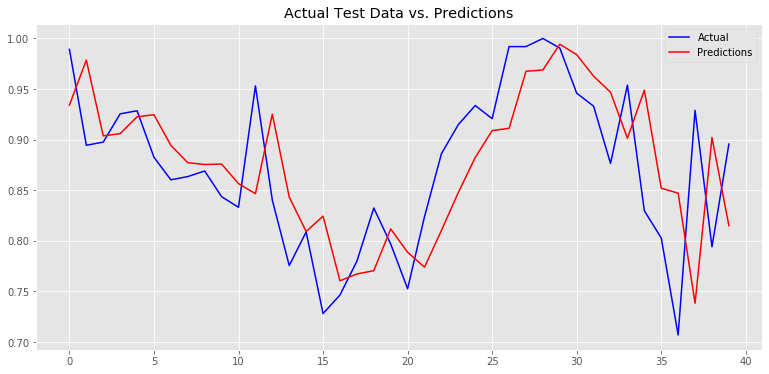

In [119]:
test_RMSE(tempo_ts, pdq=pdq, pdqs=pdqs)

### RMSE for Tempo Model:

- Train: 0.05450 
- Test: 0.06669

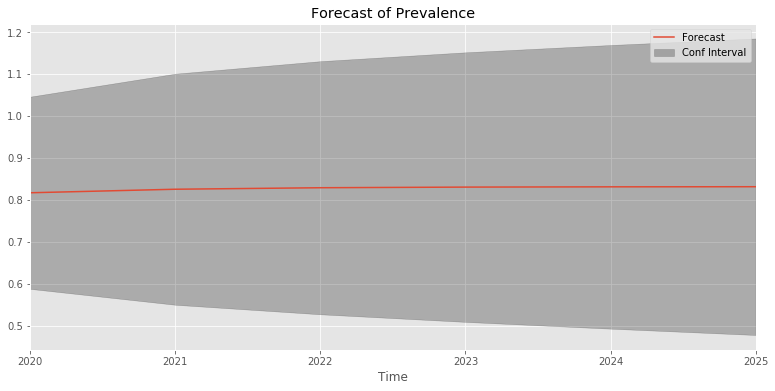

Total expected increase in prevalence in 1 year: 3.3157853907331103%
Total expected increase in prevalence in 3 years: 11.097785751657337%
Total expected increase in prevalence in 5 year: 37.20600103743637%


In [120]:
tempo_prev = forecast_model(tempo_ts, pdq=pdq, pdqs=pdqs)

## Liveness

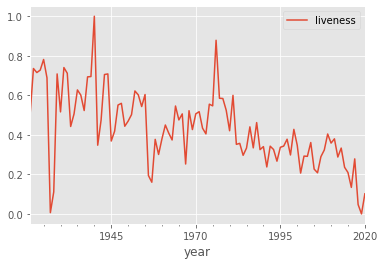

In [121]:
liveness_ts.plot()

### Liveness Analysis

- Liveness had its heyday between 1930 and 1945 and didn't return until 1975. 
- Since 1975 it has been on a pretty steady decline.

In [122]:
#Use auto arima function to find the best non-seasonal and seasonal parameters to fit the model.
results = pm.auto_arima(liveness_ts,information_criterion='aic', seasonal_test = 'df',
                        start_p=1,start_q=1, max_p=4, max_q=4,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-63.310, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-70.478, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-87.354, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-65.256, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-87.386, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-91.503, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-72.335, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-90.098, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-90.099, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-92.080, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-90.101, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-88.132, Time=0.28

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

                               SARIMAX Results                                
Dep. Variable:                  tempo   No. Observations:                   80
Model:               SARIMAX(0, 1, 2)   Log Likelihood                  51.764
Date:                Wed, 21 Oct 2020   AIC                            -97.527
Time:                        16:37:25   BIC                            -90.419
Sample:                    01-01-1921   HQIC                           -94.680
                         - 01-01-2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3369      0.076     -4.435      0.000      -0.486      -0.188
ma.L2         -0.2062      0.104     -1.980      0.048      -0.410      -0.002
sigma2         0.0157      0.002      9.191      0.0

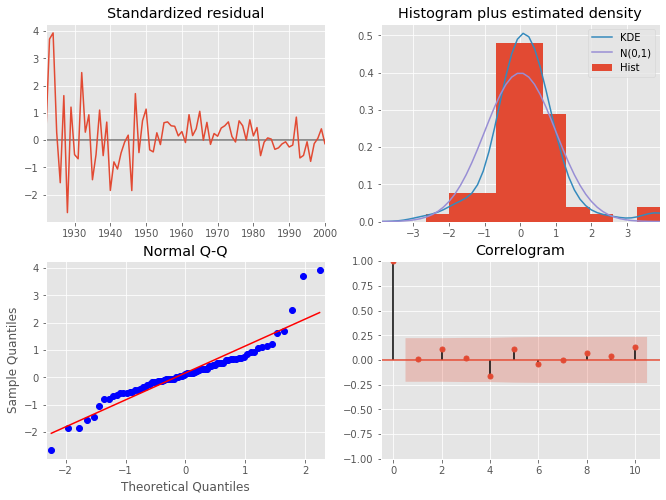

In [123]:
#Fit the ARIMA model and get results.
pdq = (0,1,2)
pdqs = (0,0,0,0)
train, test, results = fit_model(tempo_ts,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.05664


<Figure size 1080x504 with 0 Axes>

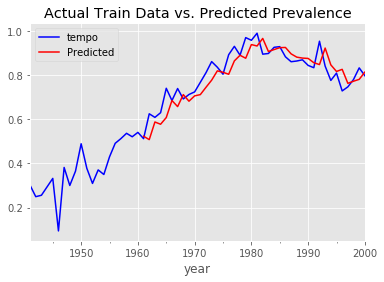

In [125]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.10220


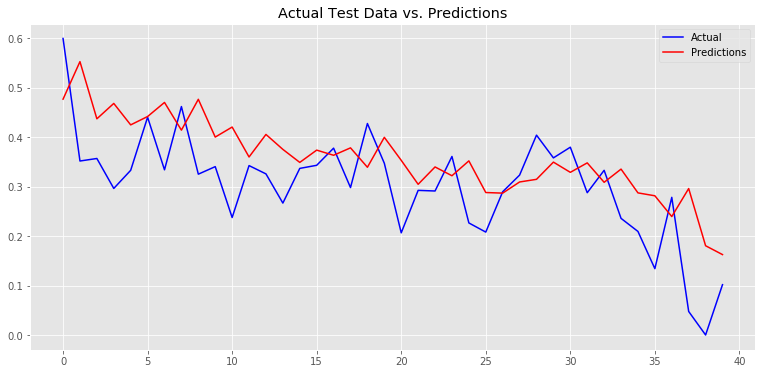

In [127]:
test_RMSE(liveness_ts, pdq=pdq, pdqs=pdqs)

### RMSE for Liveness Model:

- Train: 0.05664
- Test: 0.10220

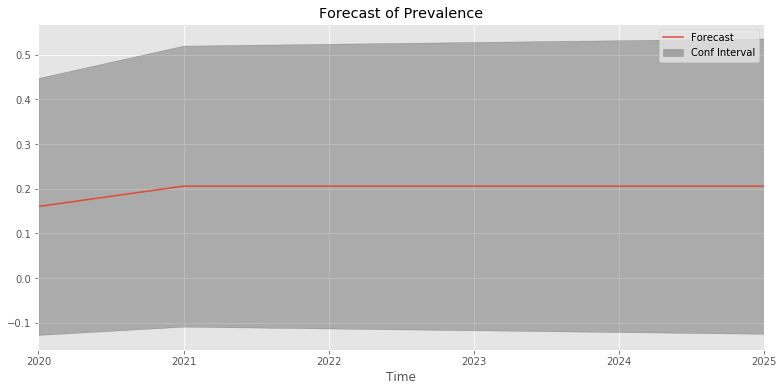

Total expected increase in prevalence in 1 year: 1.399007677952819%
Total expected increase in prevalence in 3 years: 2.0339519111230238%
Total expected increase in prevalence in 5 year: 2.95706767157608%


In [130]:
liveness_prev = forecast_model(liveness_ts, pdq=pdq, pdqs=pdqs)

# Compile Into DataFrames & Choose Best Features + Model

## Popular Features' Forecast Analysis

In [131]:
#put forecasts into a data frame and order them in descending order.
total_prev_pop = [acous_prev,loudness_prev,energy_prev,valence_prev]

In [132]:
type(total_prev_pop)

list

In [133]:
total_prev_pop = pd.DataFrame(total_prev_pop,columns=['1-year','3-year','5-year'])
total_prev_pop.sort_values('5-year',ascending=False)

1-year     3-year     5-year
1  3.564067  12.611396  44.625229
2  3.143450   9.881279  31.061308
3  1.258075   1.659142   2.246661
0  1.148103   1.323300   1.525293

- **Loudness**: 44.6% Increase over 5 Years
- **Energy**: 31.06% Increase over 5 Years
- **Valence**: 2.24% Increase over 5 Years
- **Acousticness**: 1.52% Increase over 5 Years

### Conclusion: The prevalence of Loudness & Energy will grow the most of the 4 features that most likely predict popularity. 

If you are an executive looking to emphasize certain features in the artists sponsored by your label, you may want to pursue these features if following trends is your thing however if you are looking to break the mold, investing in acoustic artists may be ideal as the prevalence of acousticness is quite low right now. 

## Niche Features' Forecast Analysis

In [134]:
total_prev_niche = [mode_prev, speechiness_prev, tempo_prev, liveness_prev]

In [135]:
total_prev_niche[0]

[1.3180698699904783, 1.753732405224694, 2.333394776073144]

In [136]:
total_prev_niche = pd.DataFrame(total_prev_niche,columns=['1-year','3-year','5-year'])
total_prev_niche.sort_values('5-year',ascending=False)

1-year     3-year     5-year
2  3.315785  11.097786  37.206001
3  1.399008   2.033952   2.957068
0  1.318070   1.753732   2.333395
1  1.256761   1.579447   1.984988

- **Tempo**: 37.2% Increase over 5 Years
- **Liveness**: 2.95% Increase over 5 Years
- **Mode**: 2.33% Move Towards Major Key over 5 Years (Can be read as: Scales will stay in the minor)
- **Speechiness**: 1.98% Increase over 5 Years

# LSTM Neural Network

Final analysis will be with a Long-Short-Term-Memory Neural Network--The definition and explanation of LSTMs will be in the ReadMe

## Import Libraries & Data relevant to LSTM analysis

In [138]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from pylab import rcParams
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style = 'whitegrid', palette='muted', font_scale = 1.5)

rcParams['figure.figsize']= 22,10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [139]:
df = pd.read_csv('data.csv', parse_dates=['year'], index_col = 'year')
df.head()

acousticness                                   artists  \
year                                                                 
1928-01-01         0.995                       ['Carl Woitschach']   
1928-01-01         0.994  ['Robert Schumann', 'Vladimir Horowitz']   
1928-01-01         0.604                   ['Seweryn Goszczyński']   
1928-01-01         0.995                      ['Francisco Canaro']   
1928-01-01         0.990  ['Frédéric Chopin', 'Vladimir Horowitz']   

            danceability  duration_ms  energy  explicit  \
year                                                      
1928-01-01         0.708       158648  0.1950         0   
1928-01-01         0.379       282133  0.0135         0   
1928-01-01         0.749       104300  0.2200         0   
1928-01-01         0.781       180760  0.1300         0   
1928-01-01         0.210       687733  0.2040         0   

                                id  instrumentalness  key  liveness  loudness  \
year                                                                            
1928-01-01  6KbQ3uYMLKb5jDxLF7wYDD             0.563   10    0.1510   -12.428   
1928-01-01  6KuQTIu1KoTTkLXKrwlLPV             0.901    8    0.0763   -28.454   
1928-01-01  6L63VW0PibdM1HDSBoqnoM             0.000    5    0.1190   -19.924   
1928-01-01  6M94FkXd15sOAOQYRnWPN8             0.887    1    0.1110   -14.734   
1928-01-01  6N6tiFZ9vLTSOIxkj8qKrd             0.908   11    0.0980   -16.829   

            mode                                           name  popularity  \
year                                                                          
1928-01-01     1                    Singende Bataillone 1. Teil           0   
1928-01-01     1       Fantasiestücke, Op. 111: Più tosto lento           0   
1928-01-01     0                 Chapter 1.18 - Zamek kaniowski           0   
1928-01-01     0  Bebamos Juntos - Instrumental (Remasterizado)           0   
1928-01-01     1    Polonaise-Fantaisie in A-Flat Major, Op. 61           1   

           release_date  speechiness    tempo  valence  
year                                                    
1928-01-01         1928       0.0506  118.469   0.7790  
1928-01-01         1928       0.0462   83.972   0.0767  
1928-01-01         1928       0.9290  107.177   0.8800  
1928-01-01   1928-09-25       0.0926  108.003   0.7200  
1928-01-01         1928       0.0424   62.149   0.0693

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 169909 entries, 1928-01-01 to 2020-01-01
Data columns (total 18 columns):
acousticness        169909 non-null float64
artists             169909 non-null object
danceability        169909 non-null float64
duration_ms         169909 non-null int64
energy              169909 non-null float64
explicit            169909 non-null int64
id                  169909 non-null object
instrumentalness    169909 non-null float64
key                 169909 non-null int64
liveness            169909 non-null float64
loudness            169909 non-null float64
mode                169909 non-null int64
name                169909 non-null object
popularity          169909 non-null int64
release_date        169909 non-null object
speechiness         169909 non-null float64
tempo               169909 non-null float64
valence             169909 non-null float64
dtypes: float64(9), int64(5), object(4)
memory usage: 24.6+ MB


In [141]:
df.isna().sum()

acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
valence             0
dtype: int64

### Delete non-numeric data

In [142]:
del df['artists']

In [143]:
del df['id']

In [144]:
del df['name']

In [145]:
del df['release_date']

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 169909 entries, 1928-01-01 to 2020-01-01
Data columns (total 14 columns):
acousticness        169909 non-null float64
danceability        169909 non-null float64
duration_ms         169909 non-null int64
energy              169909 non-null float64
explicit            169909 non-null int64
instrumentalness    169909 non-null float64
key                 169909 non-null int64
liveness            169909 non-null float64
loudness            169909 non-null float64
mode                169909 non-null int64
popularity          169909 non-null int64
speechiness         169909 non-null float64
tempo               169909 non-null float64
valence             169909 non-null float64
dtypes: float64(9), int64(5)
memory usage: 19.4 MB


In [147]:
df.index

DatetimeIndex(['1928-01-01', '1928-01-01', '1928-01-01', '1928-01-01',
               '1928-01-01', '1928-01-01', '1928-01-01', '1928-01-01',
               '1928-01-01', '1928-01-01',
               ...
               '2020-01-01', '2020-01-01', '2020-01-01', '2020-01-01',
               '2020-01-01', '2020-01-01', '2020-01-01', '2020-01-01',
               '2020-01-01', '2020-01-01'],
              dtype='datetime64[ns]', name='year', length=169909, freq=None)

In [148]:
df = df.astype('float64')

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 169909 entries, 1928-01-01 to 2020-01-01
Data columns (total 14 columns):
acousticness        169909 non-null float64
danceability        169909 non-null float64
duration_ms         169909 non-null float64
energy              169909 non-null float64
explicit            169909 non-null float64
instrumentalness    169909 non-null float64
key                 169909 non-null float64
liveness            169909 non-null float64
loudness            169909 non-null float64
mode                169909 non-null float64
popularity          169909 non-null float64
speechiness         169909 non-null float64
tempo               169909 non-null float64
valence             169909 non-null float64
dtypes: float64(14)
memory usage: 19.4 MB


In [150]:
df.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity',
       'speechiness', 'tempo', 'valence'],
      dtype='object')

### Run cursory analysis before beginning the modeling process

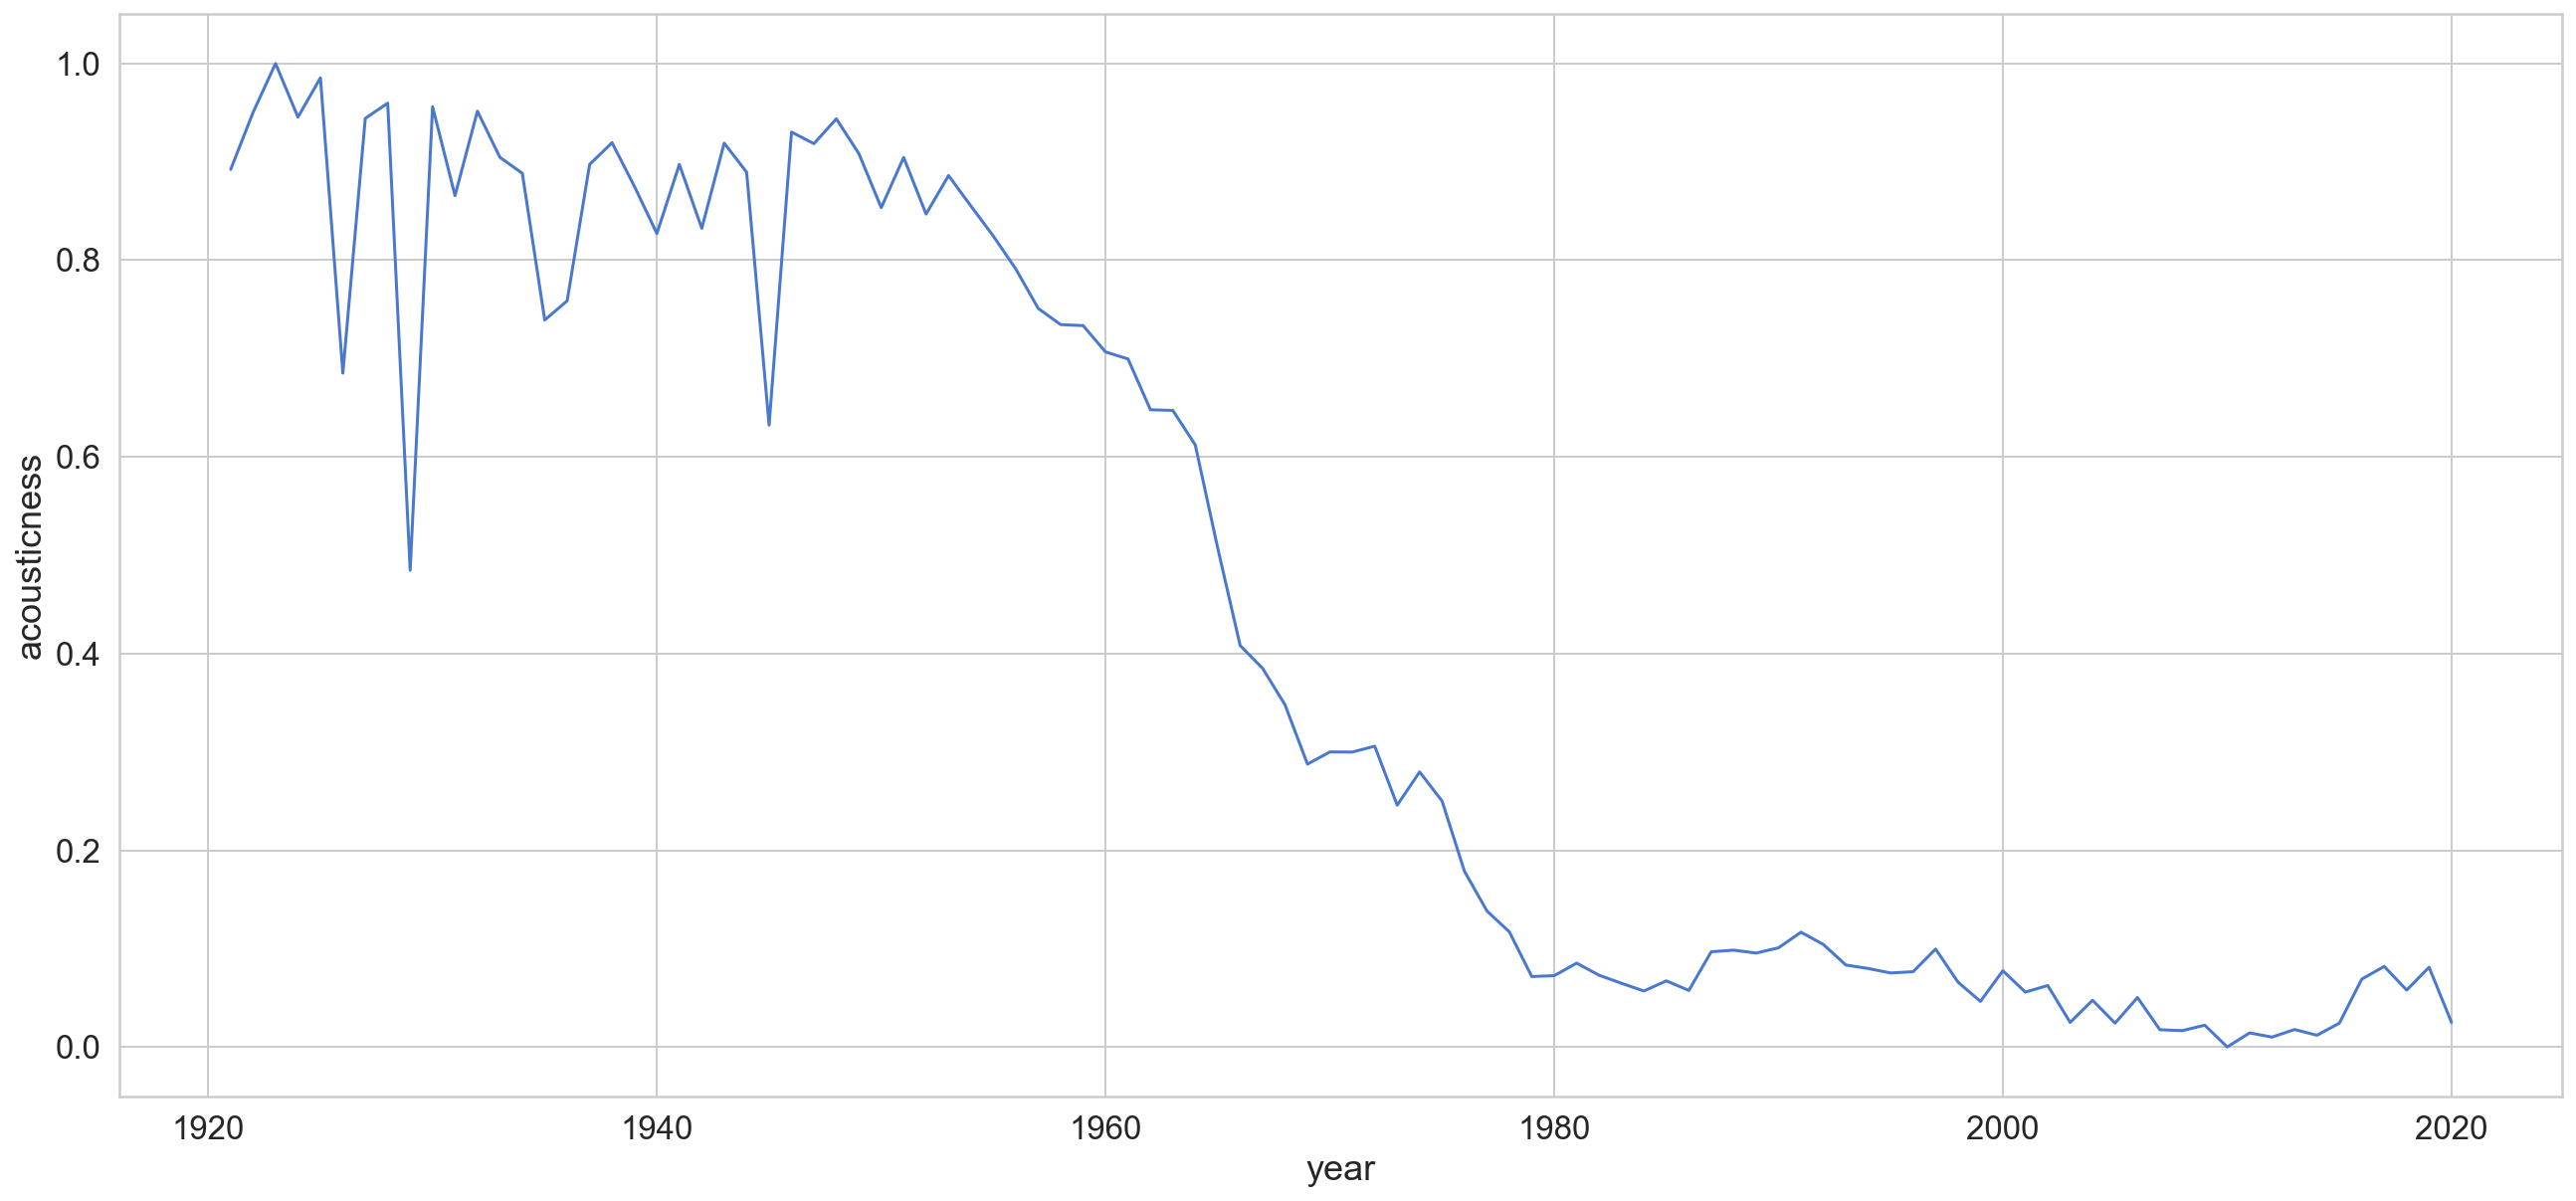

In [153]:
sns.lineplot(x = acous_ts.index, y = 'acousticness', data = acous_ts);

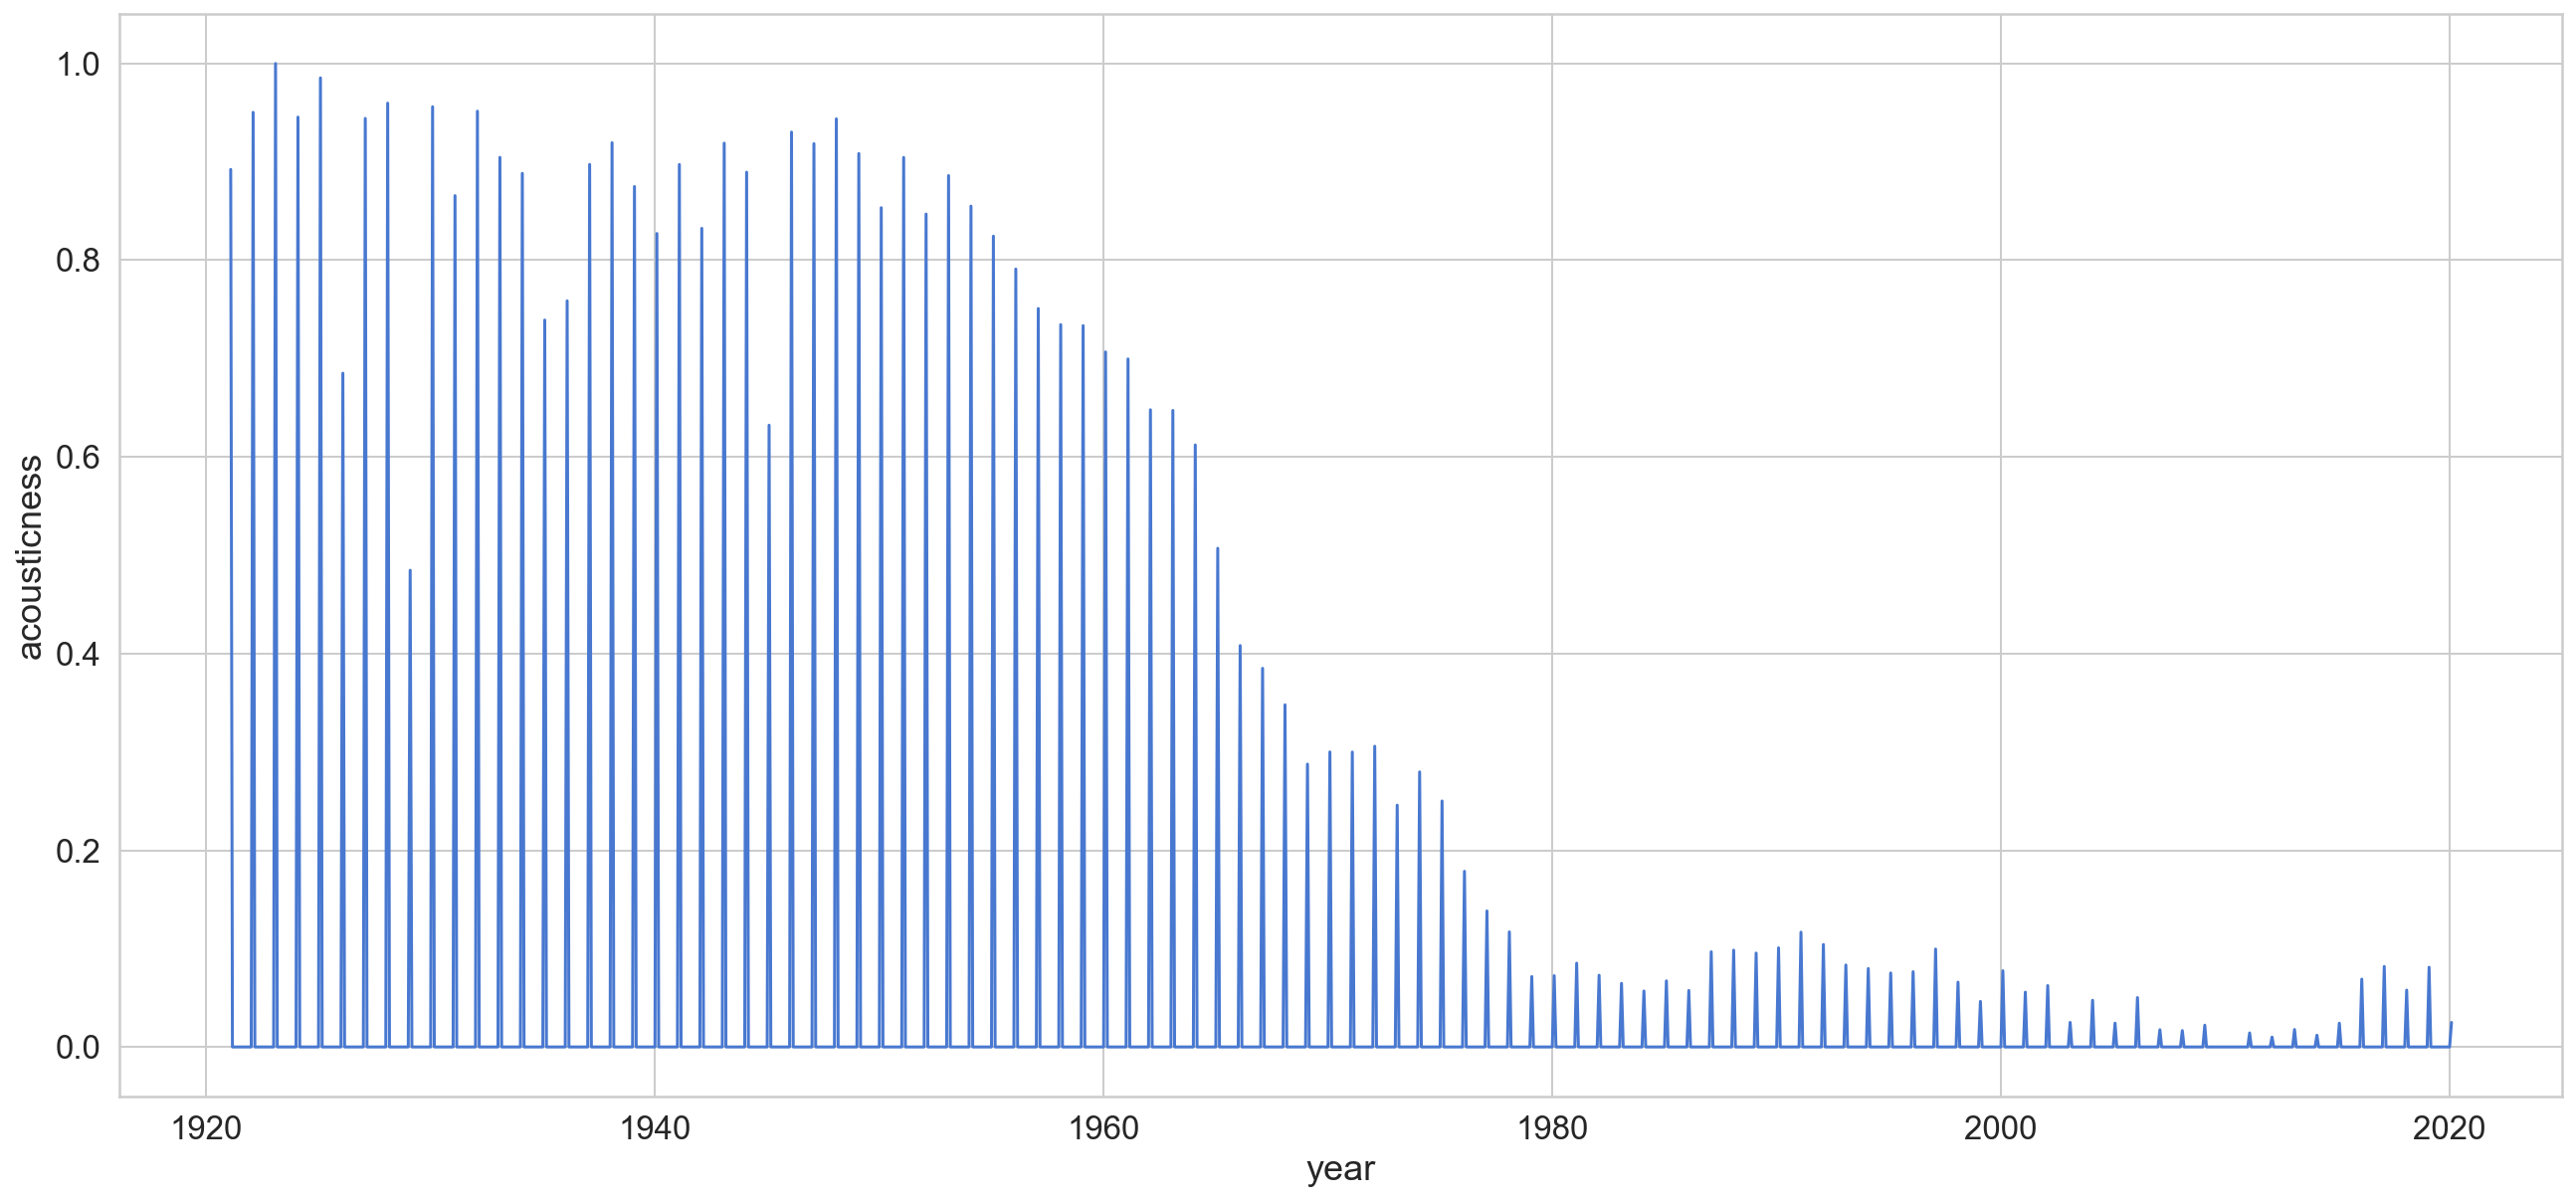

In [154]:
df_by_month = acous_ts.resample('M').sum()

sns.lineplot(x = df_by_month.index, y='acousticness', data = df_by_month)

## Use Alternative Method to Train-Test Split

Same results, just wanted to try using different code

### Note: We are using the Acousticness Time Series Here

In [382]:
train_size = int(len(acous_ts) * 0.8)
test_size = len(acous_ts) - train_size

train, test = acous_ts.iloc[0:train_size], acous_ts.iloc[train_size:len(acous_ts)]

print(train.shape, test.shape)

(80, 1) (20, 1)


## Write Function to Create a Dataset for the X & y Train & Test

This function is important because it involves time steps (a default of 1)

This is further explained in the ReadMe

In [383]:
def create_dataset (X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i: (i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [384]:
TIME_STEPS = 5 # five years

X_train, y_train = create_dataset(train, train.acousticness, time_steps = TIME_STEPS)
X_test, y_test = create_dataset(test, test.acousticness, time_steps = TIME_STEPS)

In [385]:
# (samples, time_steps, features)

print (X_train.shape, y_train.shape)

(75, 5, 1) (75,)


In [386]:
print (X_test.shape, y_test.shape)

(15, 5, 1) (15,)


In [387]:
X_train[0][0]

array([0.89231714])

## Build the Model:

1. Because it is Time Series we will use the Sequential Method from Keras
1. We will specify an LSTM for our Input Layer with 128 Units, we turn our return_sequences on, and we ensure a correct shape
1. Our second layer will have 64 units
1. Our Dropout layer is important as it will penalize a more complex model
1. Finally our output layer will be Dense (1 Unit signifies this is our output layer)

In [389]:
model = keras.Sequential()

model.add(LSTM(units = 64, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))

model.add(LSTM(units = 30, return_sequences = False))

model.add(Dropout(0.25))

model.add(Dense(units=1, activation = 'linear'))

In [390]:
from keras.optimizers import Adam

### Once the model is built, but before it is fit, we will compile the model.

- Compiling simply means we are configuring the model with losses and metrics.
    - We are measuring loss as mean squared error
    - Our optimizer is Adam which is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
        - In other words, Adam provides an optimization algorithm that can handle sparse gradients on noisy problems. 
    - The learning rate is set to 0.01, the learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated.

In [391]:
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate=0.01), metrics=['accuracy'])

In [392]:
type(X_train)

numpy.ndarray

In [393]:
type(y_train)

numpy.ndarray

## Let the LSTM magic begin! 

- We set our epochs to 40
    - One Epoch is when an entire dataset is passed forward and backward through the neural network only once. 
- We set our batch size to 10
    - The batch size is the number of samples that will be propagated through the network.
- Our validation split is 0.1
    - Keras proportionally split your training set by the value of the variable. The first set is used for training and the 2nd set for validation after each epoch.
- Shuffle is set to False because this is a time series model and so we want our data in order

In [394]:
history = model.fit(
    X_train, y_train,
    epochs = 40,
    batch_size = 10,
    validation_split = 0.2,
    shuffle=False
)

Epoch 1/40
6/6 [==============================] - 1s 158ms/step - loss: 0.2126 - val_loss: 0.0026
Epoch 2/40
6/6 [==============================] - 0s 15ms/step - loss: 0.1270 - val_loss: 0.0315
Epoch 3/40
6/6 [==============================] - 0s 13ms/step - loss: 0.0496 - val_loss: 0.0300
Epoch 4/40
6/6 [==============================] - 0s 16ms/step - loss: 0.0230 - val_loss: 0.0038
Epoch 5/40
6/6 [==============================] - 0s 12ms/step - loss: 0.0276 - val_loss: 5.4596e-04
Epoch 6/40
6/6 [==============================] - 0s 14ms/step - loss: 0.0234 - val_loss: 0.0174
Epoch 7/40
6/6 [==============================] - 0s 14ms/step - loss: 0.0289 - val_loss: 0.0221
Epoch 8/40
6/6 [==============================] - 0s 13ms/step - loss: 0.0218 - val_loss: 0.0248
Epoch 9/40
6/6 [==============================] - 0s 14ms/step - loss: 0.0246 - val_loss: 0.0067
Epoch 10/40
6/6 [==============================] - 0s 13ms/step - loss: 0.0180 - val_loss: 0.0044
Epoch 11/40
6/6 [=======

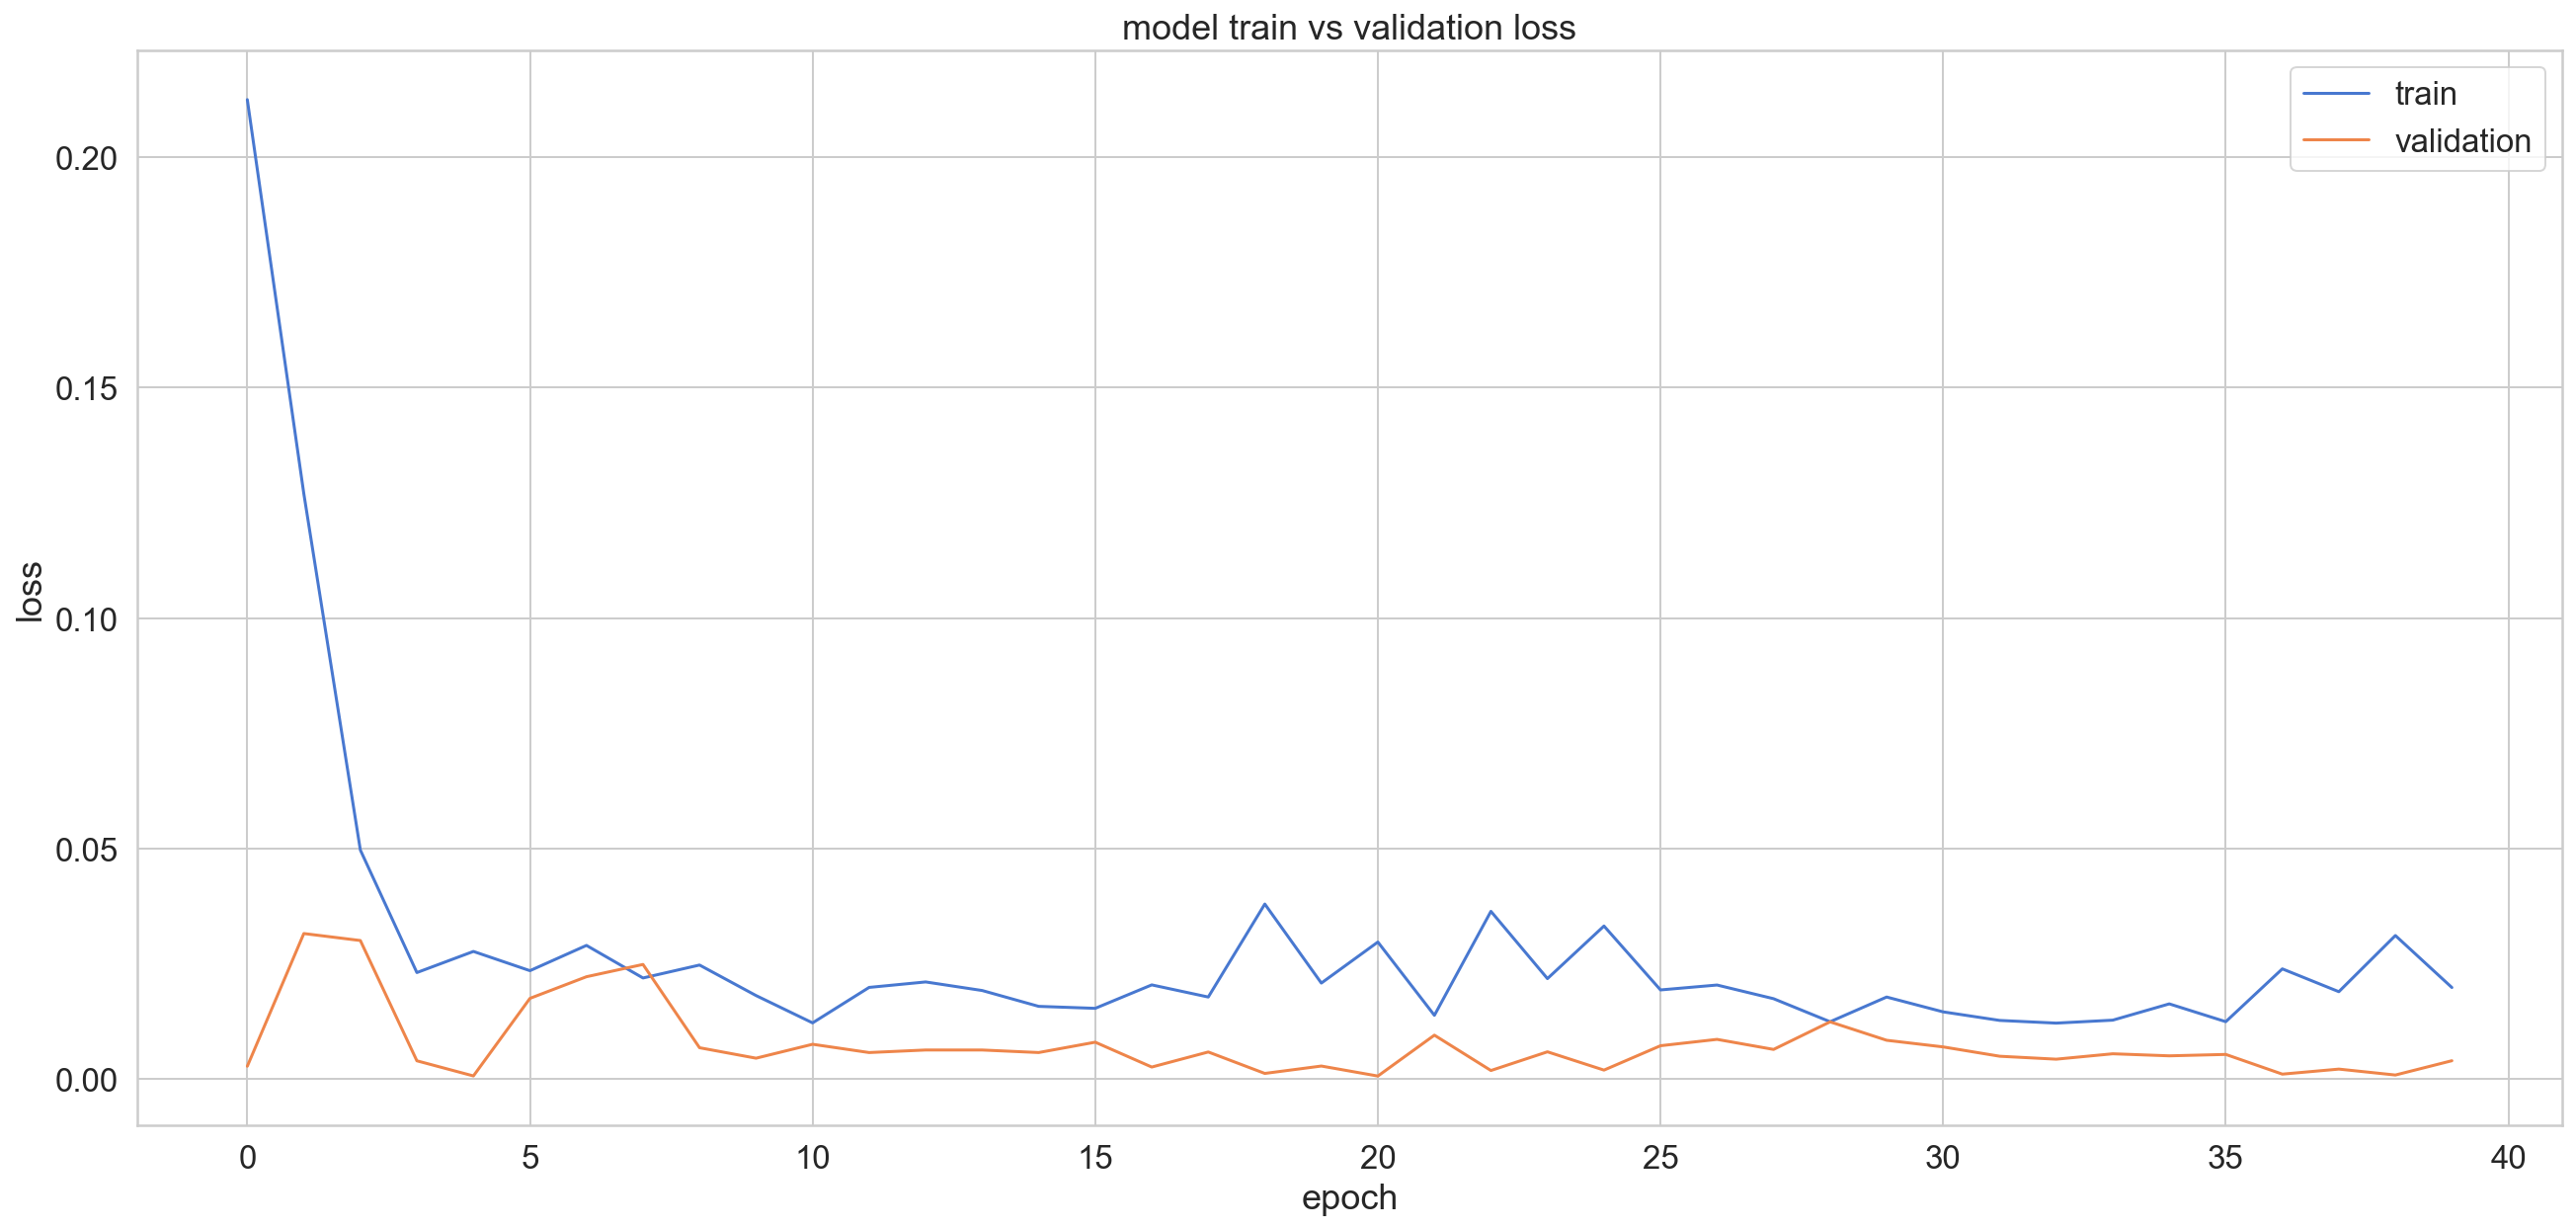

In [395]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [396]:
y_pred = model.predict(X_test)

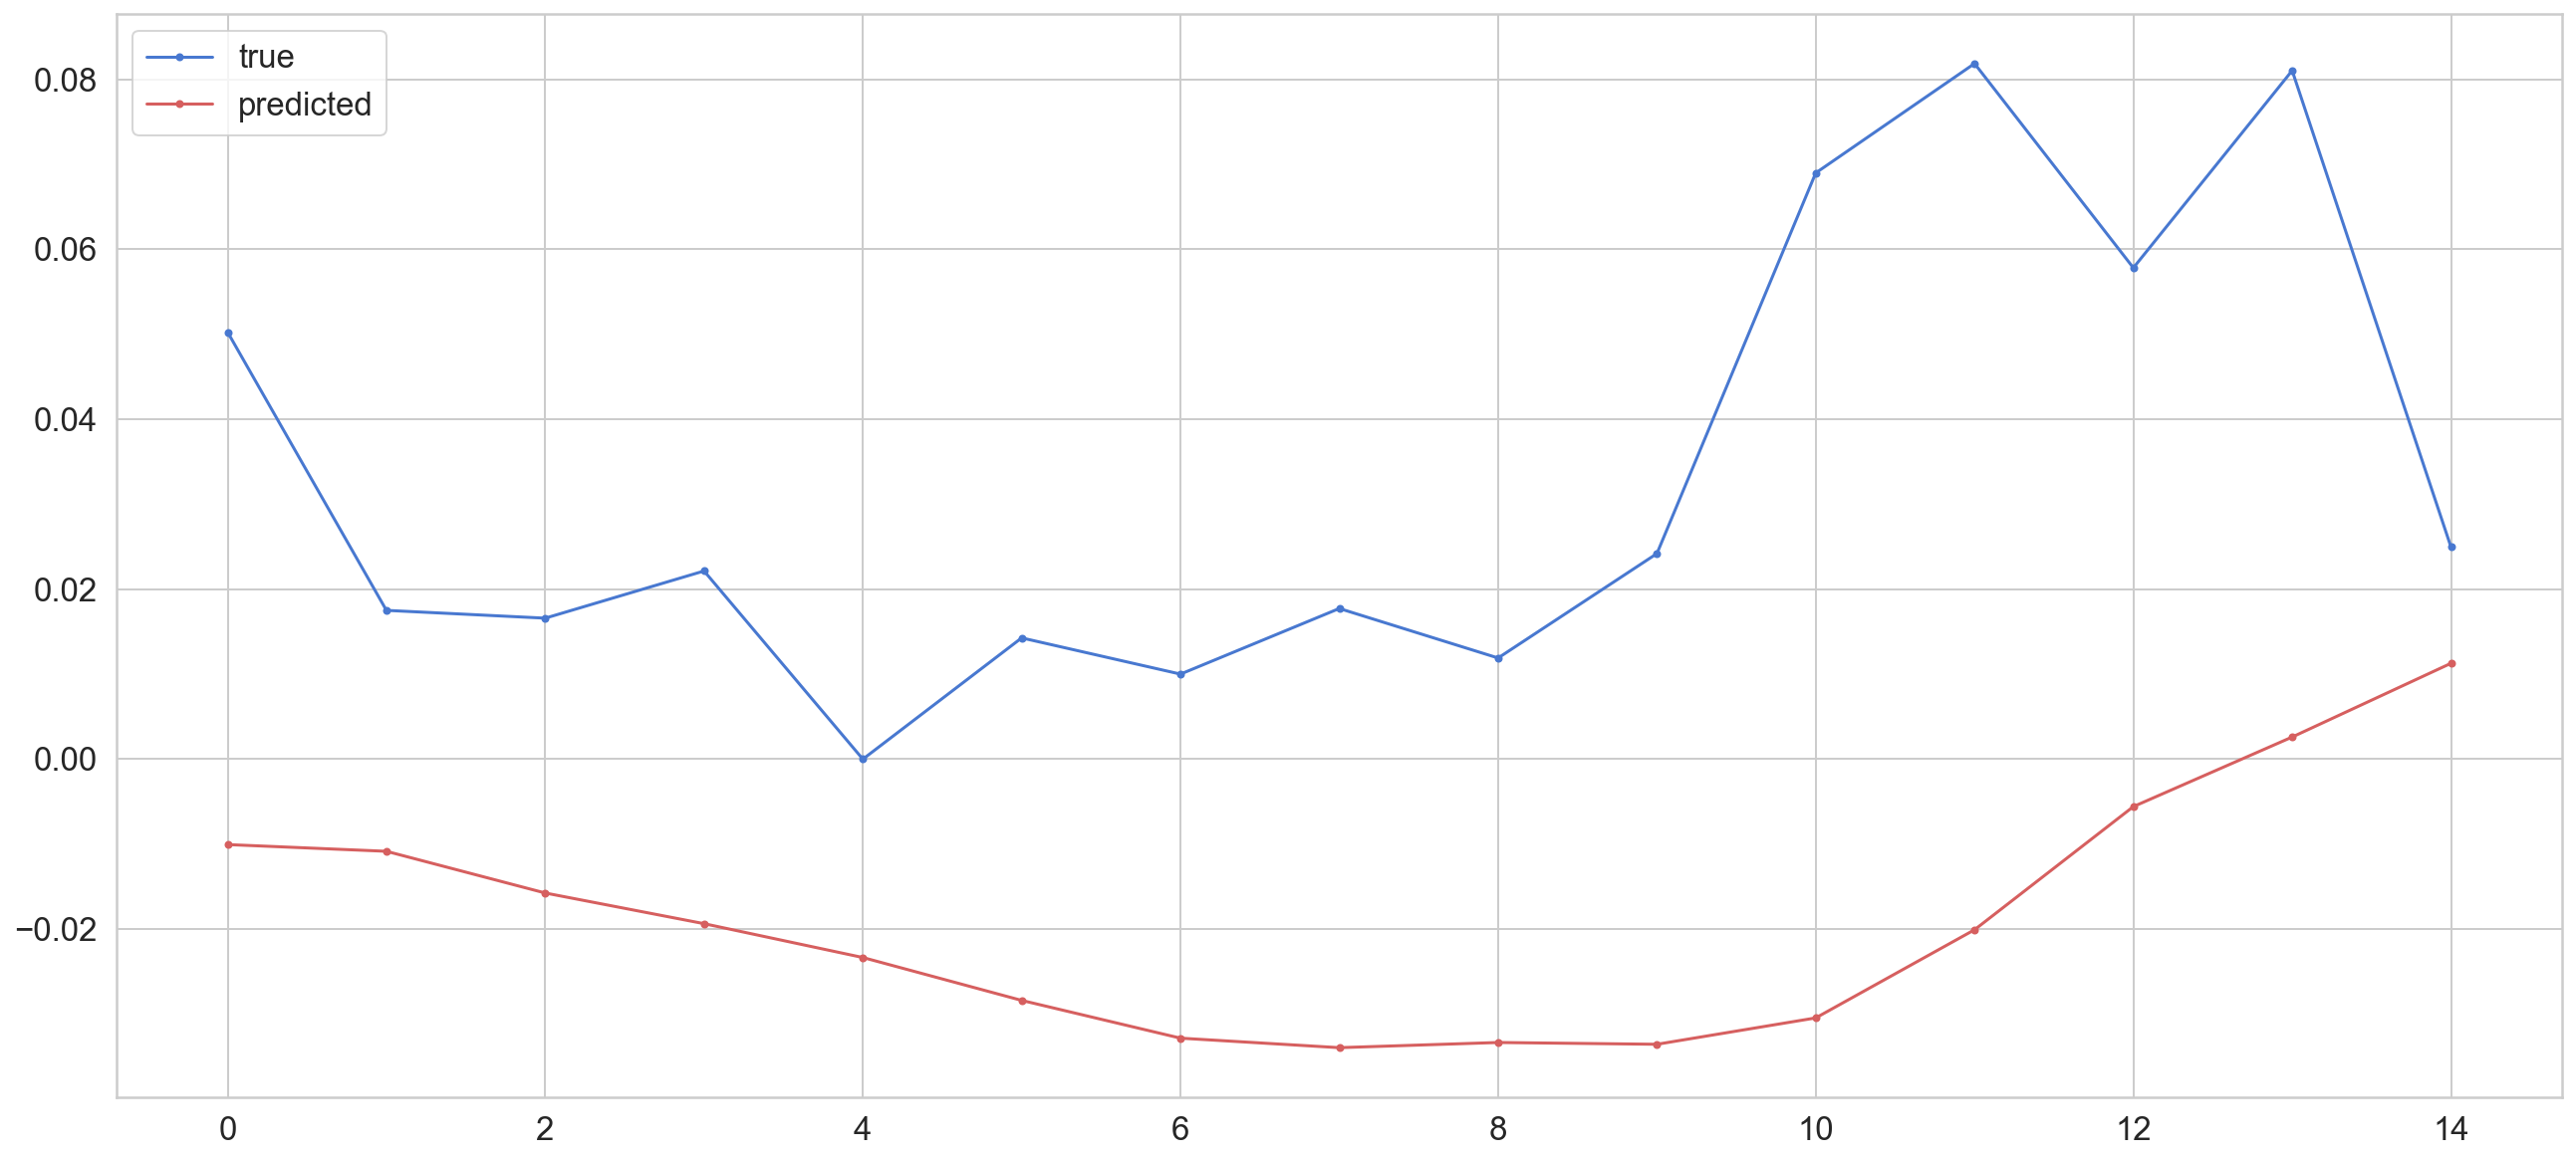

In [397]:
plt.plot(y_test, marker='.', label='true')
plt.plot(y_pred, 'r',marker='.', label='predicted')
plt.legend();

In [428]:
train_size = int(len(energy_ts) * 0.8)
test_size = len(energy_ts) - train_size

train, test = energy_ts.iloc[0:train_size], energy_ts.iloc[train_size:len(energy_ts)]

print(train.shape, test.shape)

(80, 1) (20, 1)


In [429]:
energy_ts.head()

energy
year                
1921-01-01  0.066466
1922-01-01  0.066962
1923-01-01  0.087209
1924-01-01  0.291720
1925-01-01  0.122834

In [430]:
TIME_STEPS = 5 # seven years

X_train, y_train = create_dataset(train, train.energy, time_steps = TIME_STEPS)
X_test, y_test = create_dataset(test, test.energy, time_steps = TIME_STEPS)

In [431]:
model = keras.Sequential()

model.add(LSTM(units = 64, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))

model.add(LSTM(units = 30, return_sequences = False))

model.add(Dropout(0.25))

model.add(Dense(units=1, activation = 'linear'))

In [432]:
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate=0.01))

In [433]:
history = model.fit(
    X_train, y_train,
    epochs = 100,
    batch_size = 30,
    validation_split = 0.1,
    shuffle=False
)

Epoch 1/100
3/3 [==============================] - 1s 251ms/step - loss: 0.0619 - val_loss: 0.1179
Epoch 2/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0921 - val_loss: 0.0800
Epoch 3/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0421 - val_loss: 0.0240
Epoch 4/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0112 - val_loss: 0.0101
Epoch 5/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0155 - val_loss: 0.0150
Epoch 6/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0225 - val_loss: 0.0232
Epoch 7/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0112 - val_loss: 0.0106
Epoch 8/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0228 - val_loss: 0.0017
Epoch 9/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0125 - val_loss: 0.0492
Epoch 10/100
3/3 [==============================] - 0s 26ms/step - loss: 0.0299 - val_loss: 0.0366
Epoch 11/100
3/3 [

Epoch 84/100
3/3 [==============================] - 0s 29ms/step - loss: 0.0065 - val_loss: 0.0031
Epoch 85/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0057 - val_loss: 0.0018
Epoch 86/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0051 - val_loss: 0.0030
Epoch 87/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0050 - val_loss: 0.0025
Epoch 88/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0046 - val_loss: 0.0013
Epoch 89/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0056 - val_loss: 0.0022
Epoch 90/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0062 - val_loss: 0.0092
Epoch 91/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0062 - val_loss: 0.0037
Epoch 92/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0048 - val_loss: 0.0026
Epoch 93/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0053 - val_loss: 0.0063
Epoch 94/1

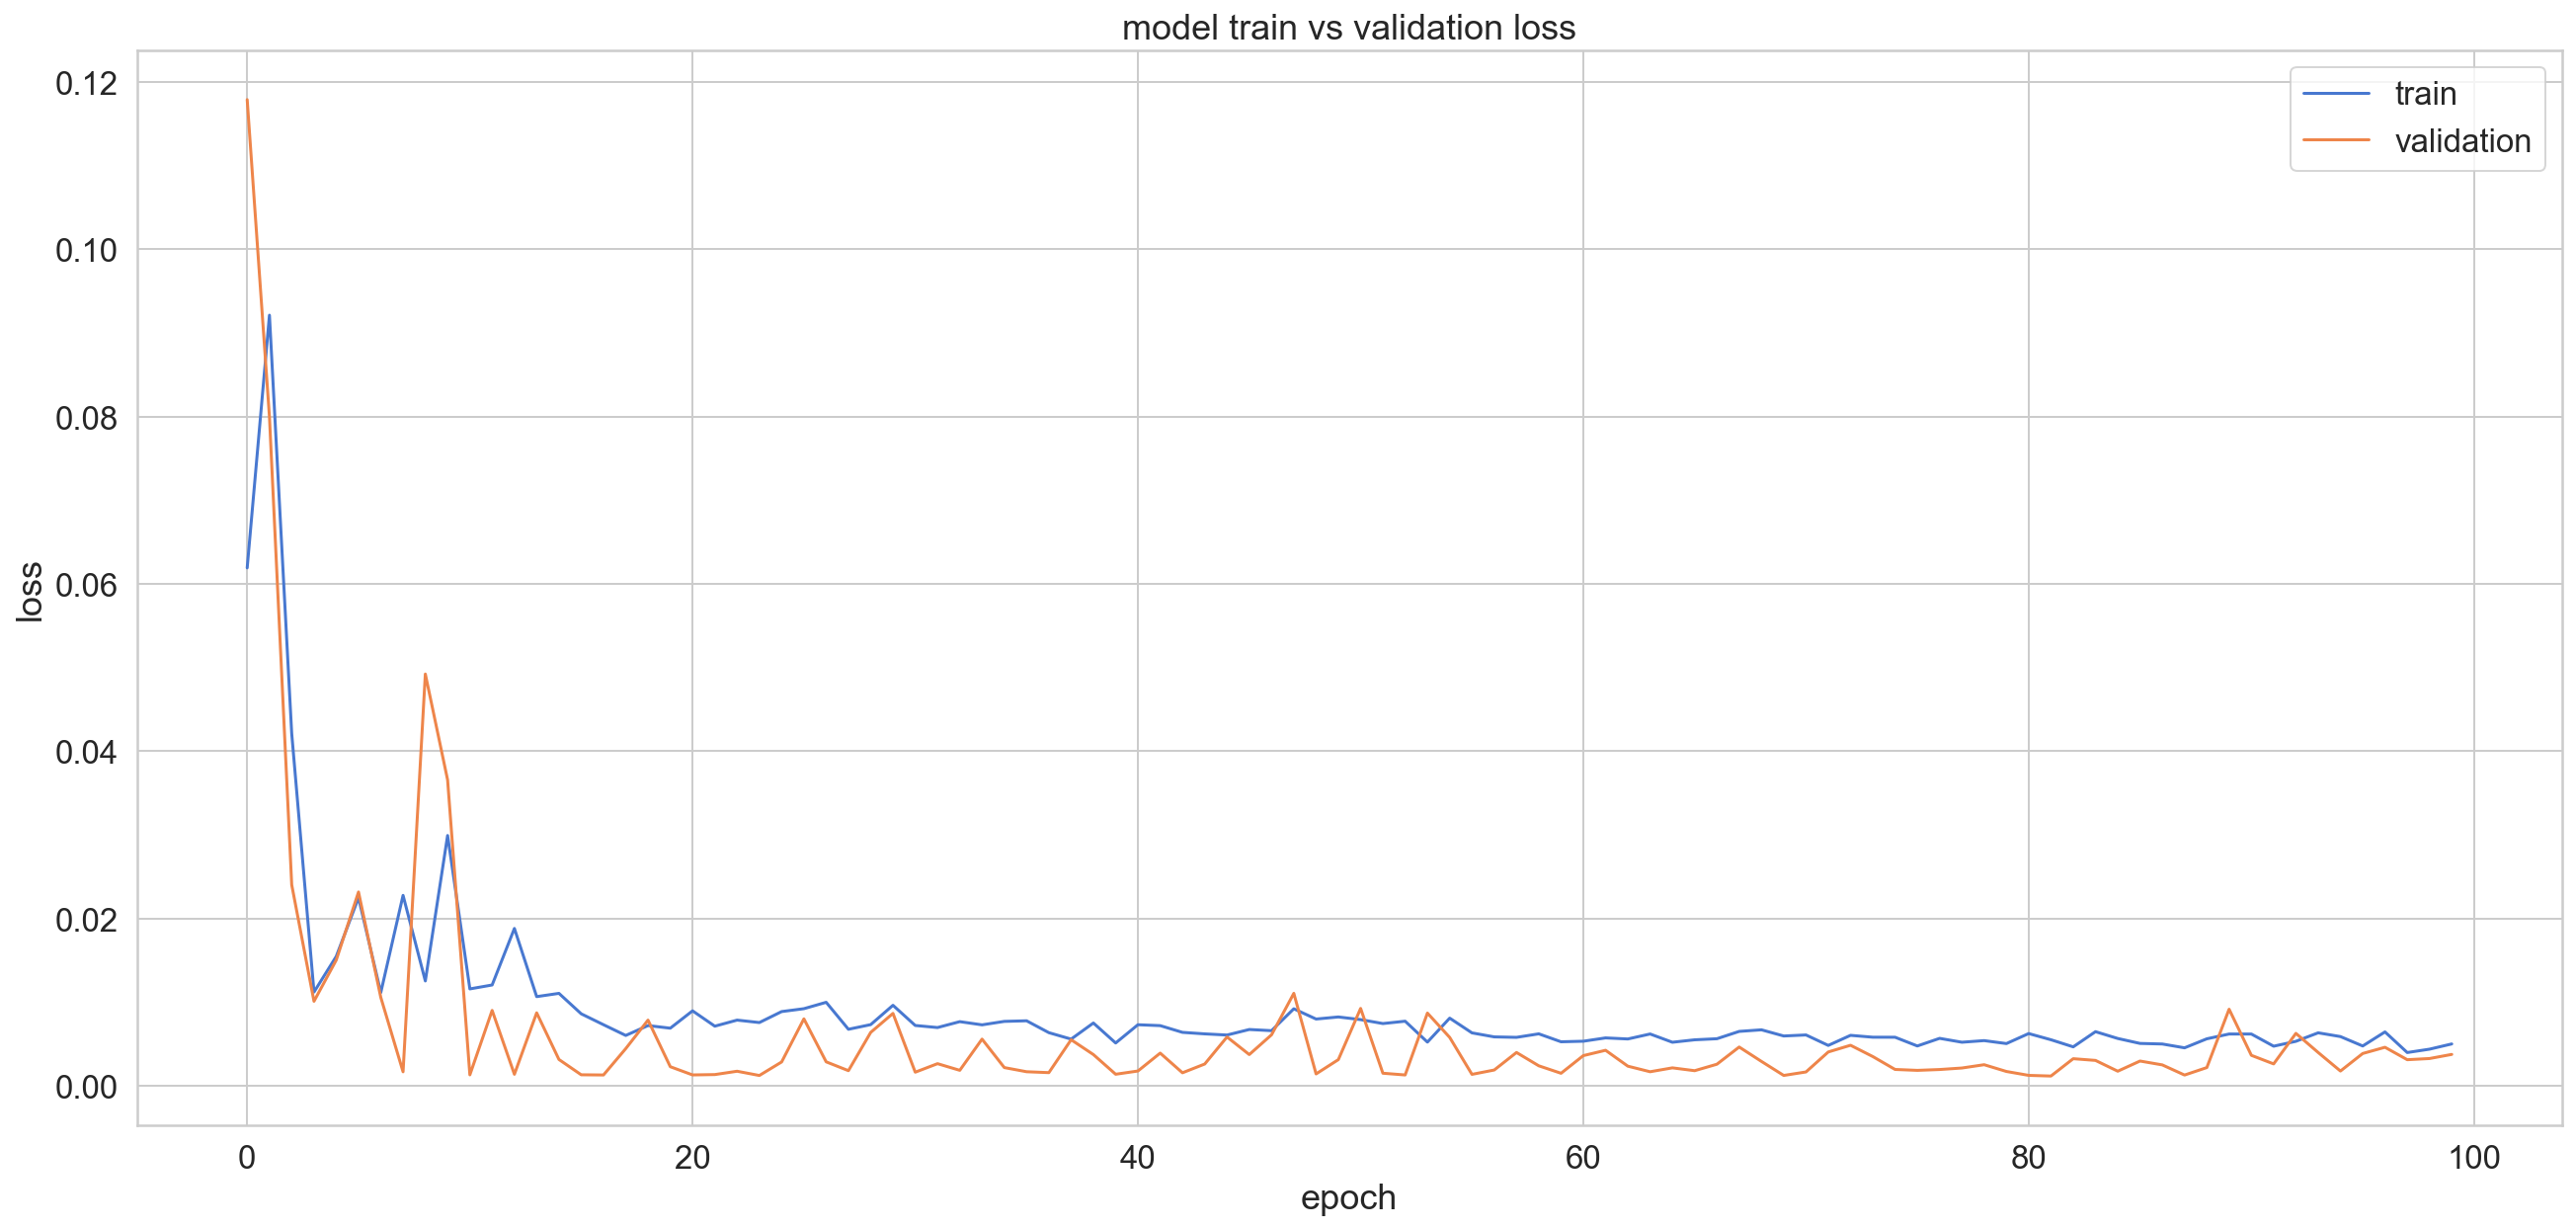

In [434]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [435]:
y_pred = model.predict(X_test)

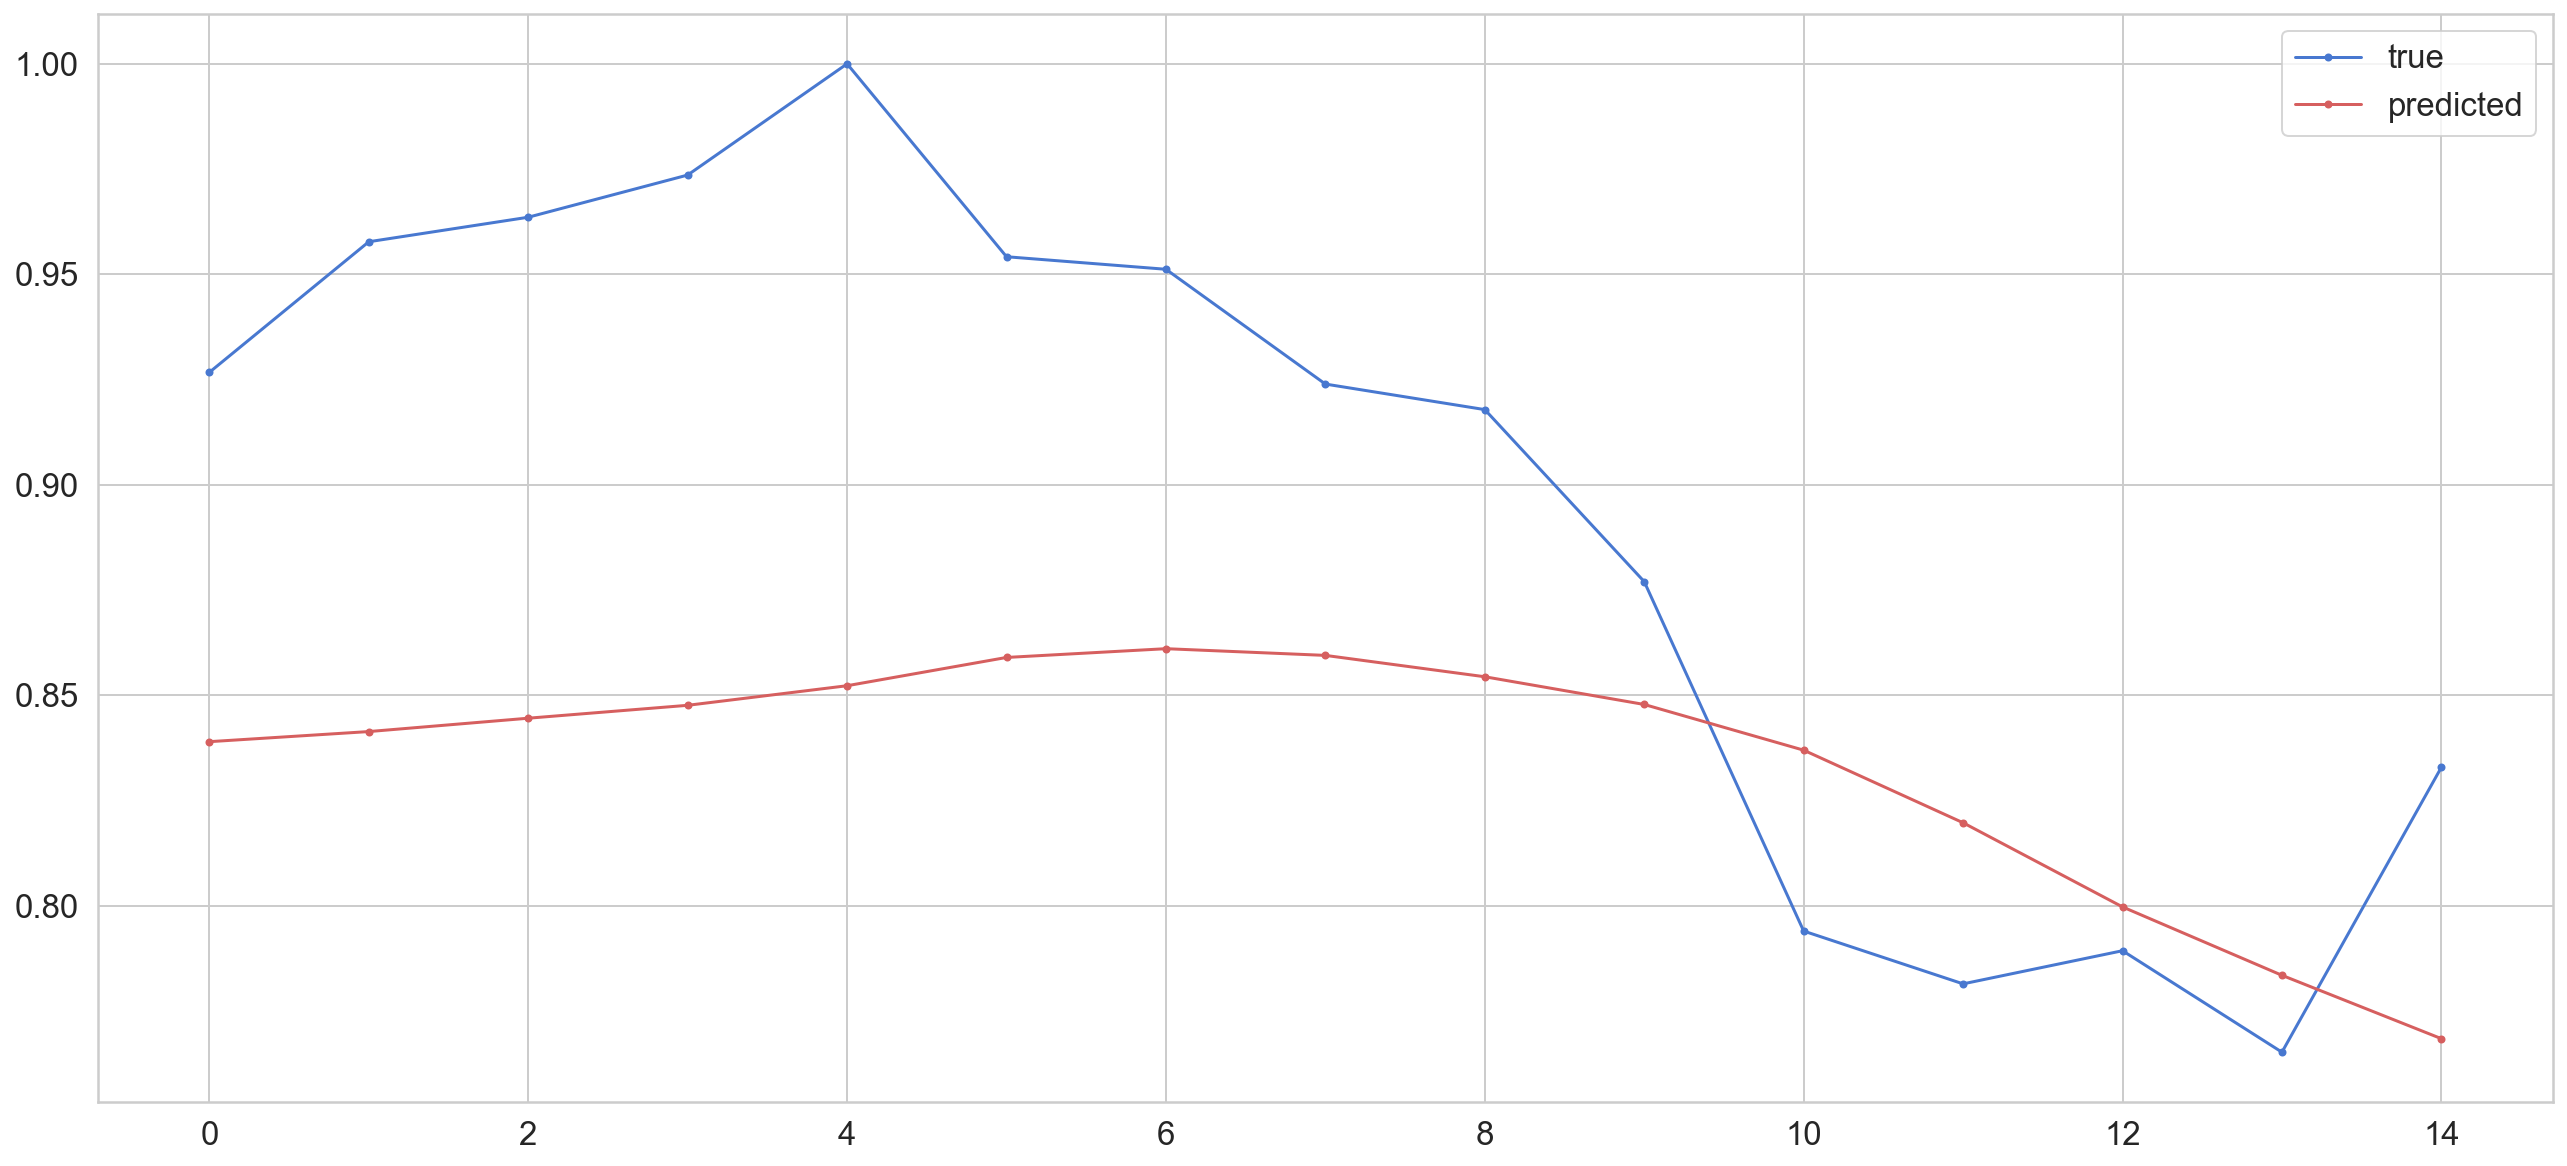

In [436]:
plt.plot(y_test, marker='.', label='true')
plt.plot(y_pred, 'r',marker='.', label='predicted')
plt.legend();

## What if we gave our LSTM more information to work with?

Let's concatenate the four dataframes inside of df_ts (the 4 popular features' time series) and build a network with these features.

In [437]:
df_tss = pd.concat(df_ts, axis=1)

In [438]:
df_tss.head()

acousticness  loudness    energy   valence
year                                                  
1921-01-01      0.892317  0.166953  0.066466  0.175866
1922-01-01      0.950385  0.000000  0.066962  0.543930
1923-01-01      1.000000  0.384927  0.087209  0.851547
1924-01-01      0.945488  0.398669  0.291720  1.000000
1925-01-01      0.985411  0.373488  0.122834  0.823213

In [439]:
type(df_tss)

pandas.core.frame.DataFrame

In [440]:
df_tss.shape

(100, 4)

In [663]:
train_size = int(len(df_tss) * 0.8)
test_size = len(df_tss) - train_size

train, test = df_tss.iloc[0:train_size], df_tss.iloc[train_size:len(df_tss)]

print(train.shape, test.shape)

(80, 4) (20, 4)


In [664]:
TIME_STEPS = 5 # five years

X_train, y_train = create_dataset(train, train.acousticness, time_steps = TIME_STEPS)
X_test, y_test = create_dataset(test, test.acousticness, time_steps = TIME_STEPS)

In [665]:
model = keras.Sequential()

model.add(LSTM(units = 64, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))

model.add(LSTM(units = 32, return_sequences = False))

model.add(Dropout(0.25))

model.add(Dense(units=1, activation = 'linear'))

In [666]:
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate=0.01))

In [667]:
history = model.fit(
    X_train, y_train,
    epochs = 100,
    batch_size = 64,
    validation_split = 0.1,
    shuffle=False
)

Epoch 1/100
2/2 [==============================] - 1s 359ms/step - loss: 0.5120 - val_loss: 0.0155
Epoch 2/100
2/2 [==============================] - 0s 30ms/step - loss: 0.1699 - val_loss: 0.0147
Epoch 3/100
2/2 [==============================] - 0s 22ms/step - loss: 0.0432 - val_loss: 0.0028
Epoch 4/100
2/2 [==============================] - 0s 23ms/step - loss: 0.0470 - val_loss: 0.0155
Epoch 5/100
2/2 [==============================] - 0s 33ms/step - loss: 0.0153 - val_loss: 0.0109
Epoch 6/100
2/2 [==============================] - 0s 26ms/step - loss: 0.0184 - val_loss: 0.0273
Epoch 7/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0352 - val_loss: 0.0182
Epoch 8/100
2/2 [==============================] - 0s 28ms/step - loss: 0.0476 - val_loss: 0.0071
Epoch 9/100
2/2 [==============================] - 0s 26ms/step - loss: 0.0522 - val_loss: 0.0024
Epoch 10/100
2/2 [==============================] - 0s 24ms/step - loss: 0.0286 - val_loss: 0.0013
Epoch 11/100
2/2 [

Epoch 82/100
2/2 [==============================] - 0s 29ms/step - loss: 0.0102 - val_loss: 6.5658e-04
Epoch 83/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0128 - val_loss: 0.0011
Epoch 84/100
2/2 [==============================] - 0s 38ms/step - loss: 0.0106 - val_loss: 0.0014
Epoch 85/100
2/2 [==============================] - 0s 28ms/step - loss: 0.0085 - val_loss: 0.0011
Epoch 86/100
2/2 [==============================] - 0s 29ms/step - loss: 0.0104 - val_loss: 7.1651e-04
Epoch 87/100
2/2 [==============================] - 0s 26ms/step - loss: 0.0124 - val_loss: 5.0034e-04
Epoch 88/100
2/2 [==============================] - 0s 32ms/step - loss: 0.0092 - val_loss: 4.1232e-04
Epoch 89/100
2/2 [==============================] - 0s 32ms/step - loss: 0.0086 - val_loss: 5.7598e-04
Epoch 90/100
2/2 [==============================] - 0s 26ms/step - loss: 0.0105 - val_loss: 6.3775e-04
Epoch 91/100
2/2 [==============================] - 0s 34ms/step - loss: 0.0080 - val

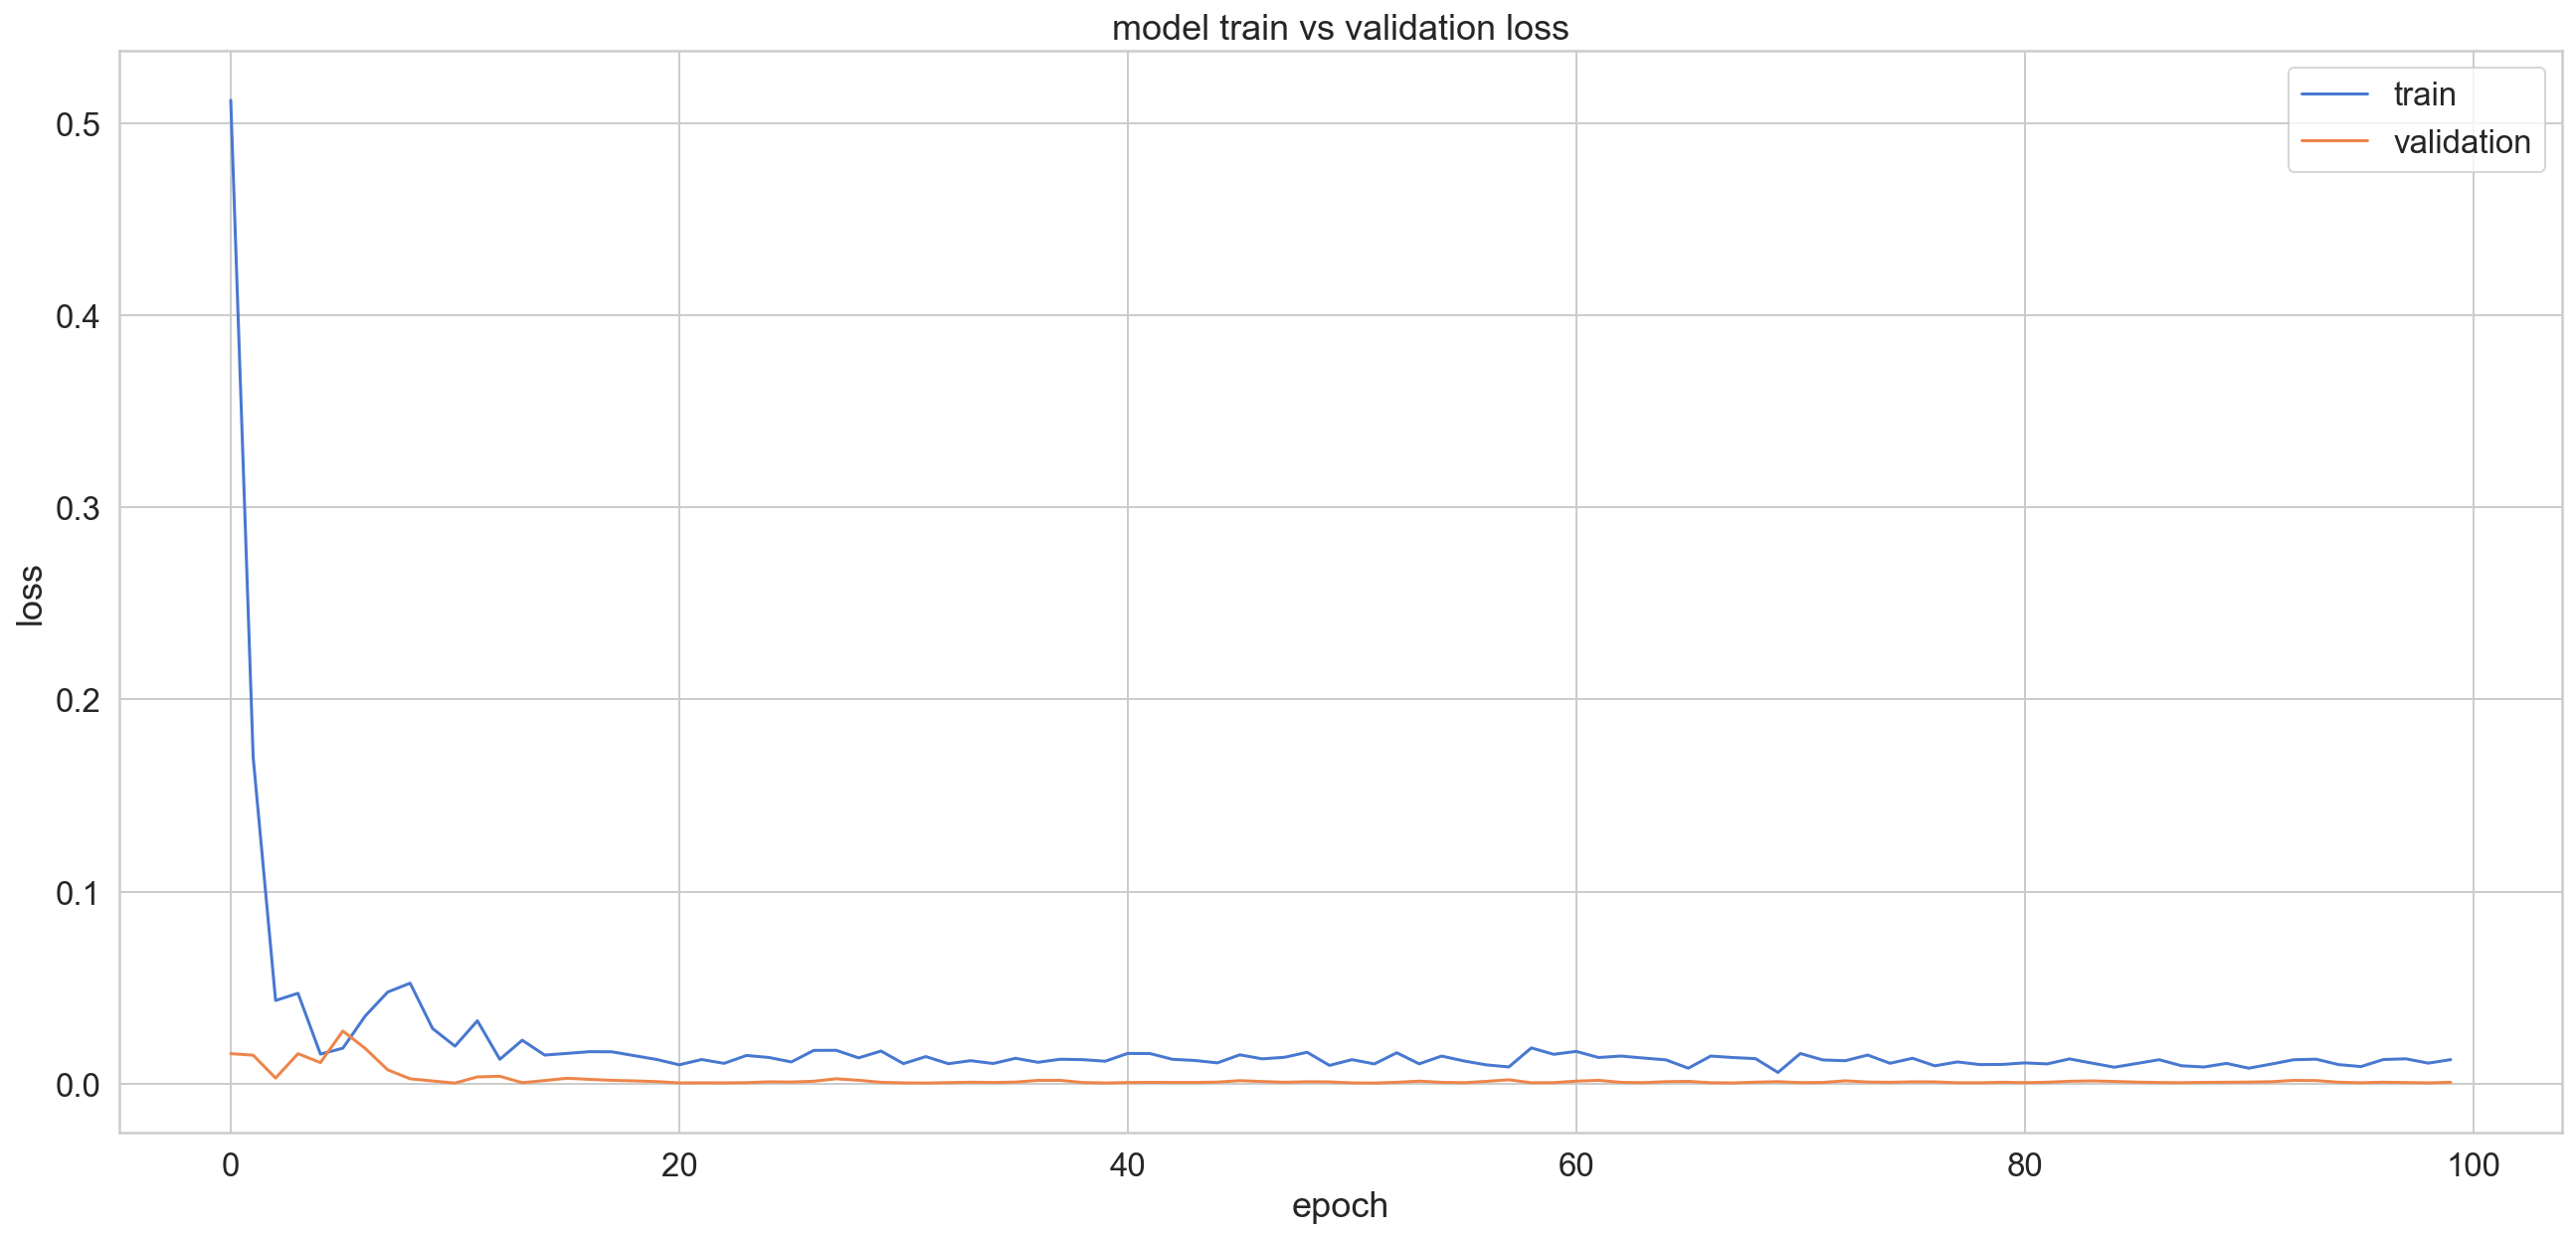

In [668]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [669]:
y_pred = model.predict(X_test)

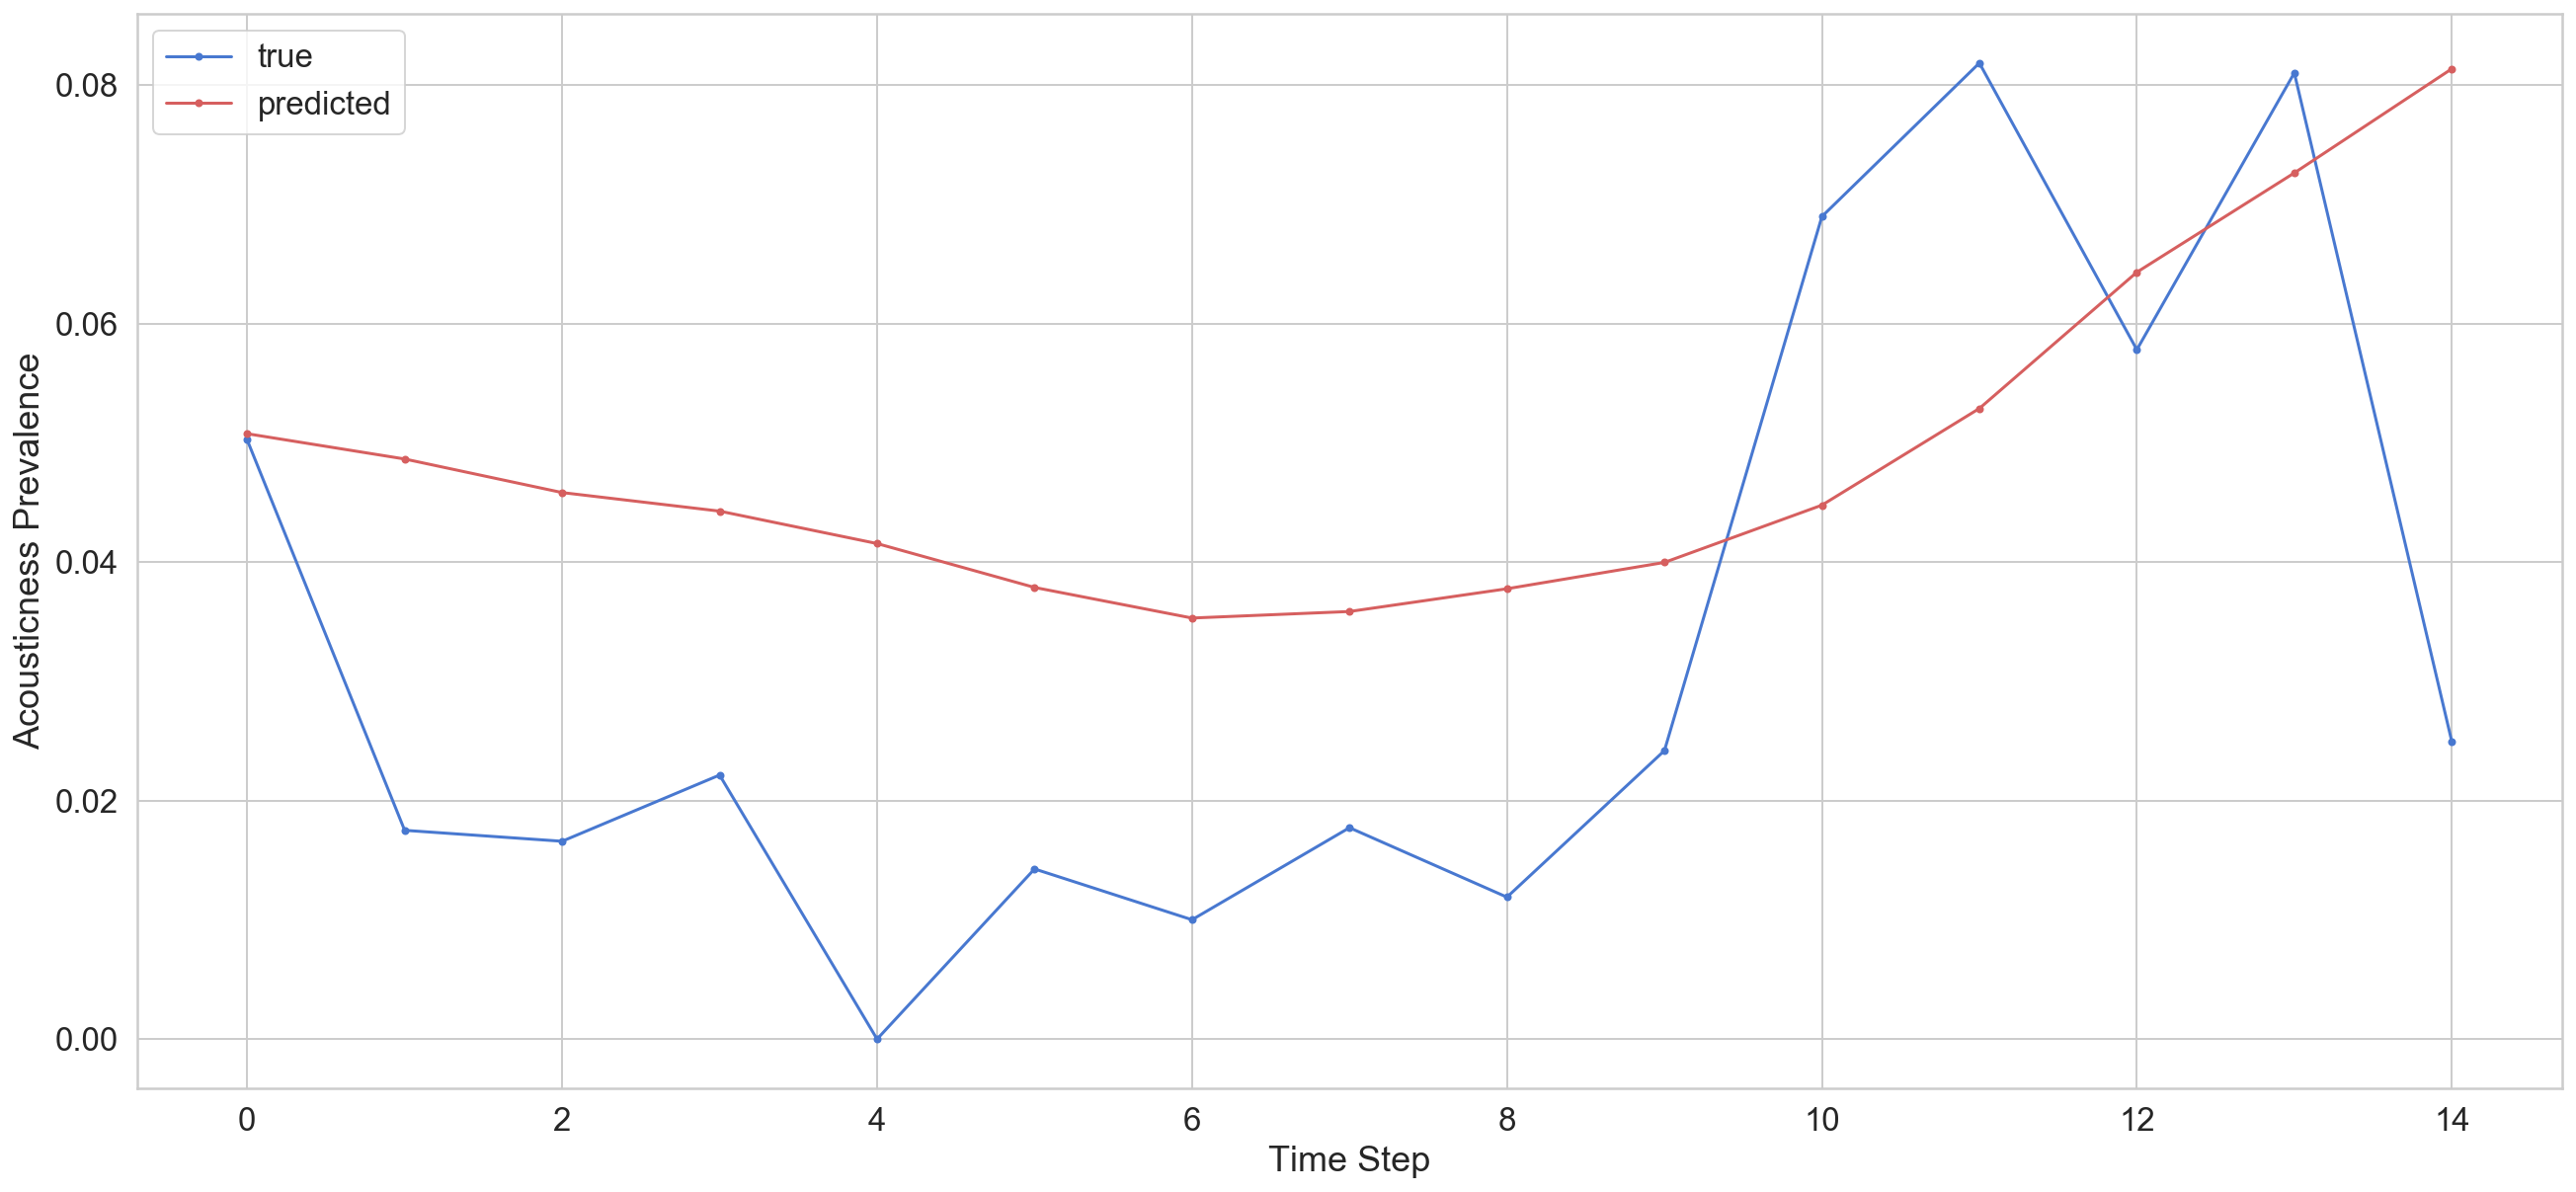

In [670]:
plt.plot(y_test, marker='.', label='true')
plt.plot(y_pred, 'r',marker='.', label='predicted')
plt.ylabel('Acousticness Prevalence')
plt.xlabel('Time Step')
plt.legend();

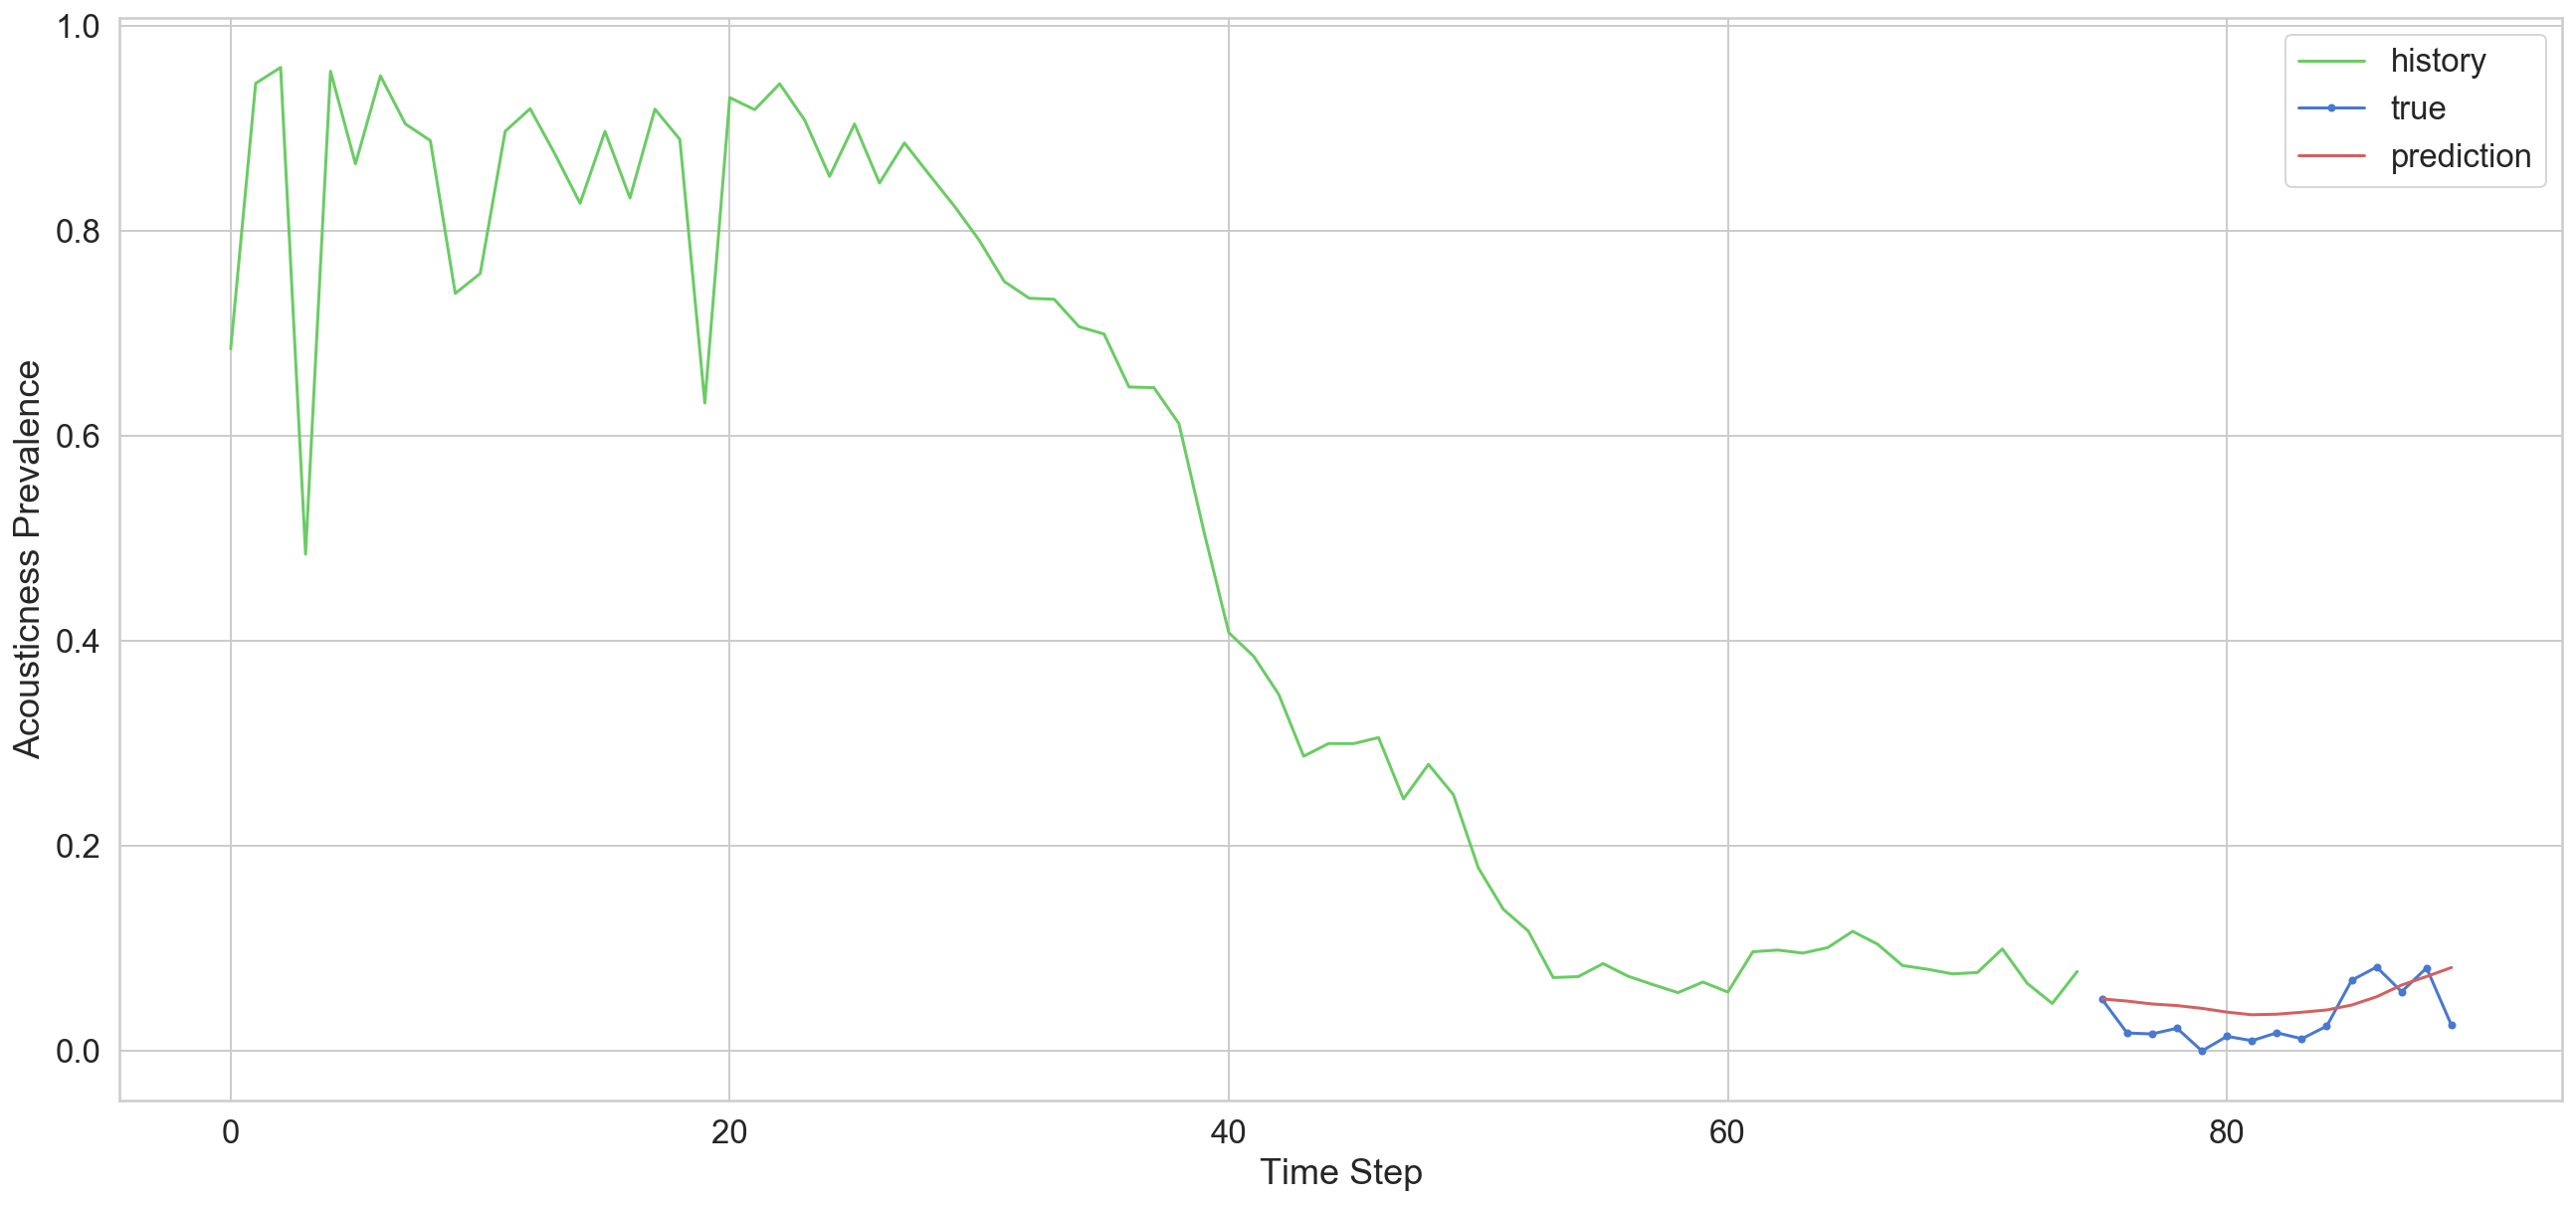

In [671]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Acousticness Prevalence')
plt.xlabel('Time Step')
plt.legend()
plt.show();

## Energy LSTM

In [672]:
train_size = int(len(df_tss) * 0.8)
test_size = len(df_tss) - train_size

train, test = df_tss.iloc[0:train_size], df_tss.iloc[train_size:len(df_tss)]

print(train.shape, test.shape)

(80, 4) (20, 4)


In [673]:
TIME_STEPS = 5 # five years

X_train, y_train = create_dataset(train, train.energy, time_steps = TIME_STEPS)
X_test, y_test = create_dataset(test, test.energy, time_steps = TIME_STEPS)

In [674]:
model = keras.Sequential()

model.add(LSTM(units = 64, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))

model.add(LSTM(units = 32, return_sequences = False))

model.add(Dropout(0.25))

model.add(Dense(units=1, activation = 'linear'))

In [675]:
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate=0.01), metrics=['accuracy'])

In [676]:
history = model.fit(
    X_train, y_train,
    epochs = 100,
    batch_size = 64,
    validation_split = 0.1,
    shuffle=False
)

Epoch 1/100
2/2 [==============================] - 1s 454ms/step - loss: 0.2702 - accuracy: 0.0149 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 2/100
2/2 [==============================] - 0s 27ms/step - loss: 0.1796 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 3/100
2/2 [==============================] - 0s 24ms/step - loss: 0.0428 - accuracy: 0.0149 - val_loss: 0.0193 - val_accuracy: 0.0000e+00
Epoch 4/100
2/2 [==============================] - 0s 27ms/step - loss: 0.0165 - accuracy: 0.0149 - val_loss: 0.0129 - val_accuracy: 0.0000e+00
Epoch 5/100
2/2 [==============================] - 0s 37ms/step - loss: 0.0386 - accuracy: 0.0149 - val_loss: 6.3693e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
2/2 [==============================] - 0s 29ms/step - loss: 0.0213 - accuracy: 0.0149 - val_loss: 7.0475e-04 - val_accuracy: 0.0000e+00
Epoch 7/100
2/2 [==============================] - 0s 28ms/step - loss: 0.0091 - accuracy: 0.0149 - val_loss: 0.0066 - val_

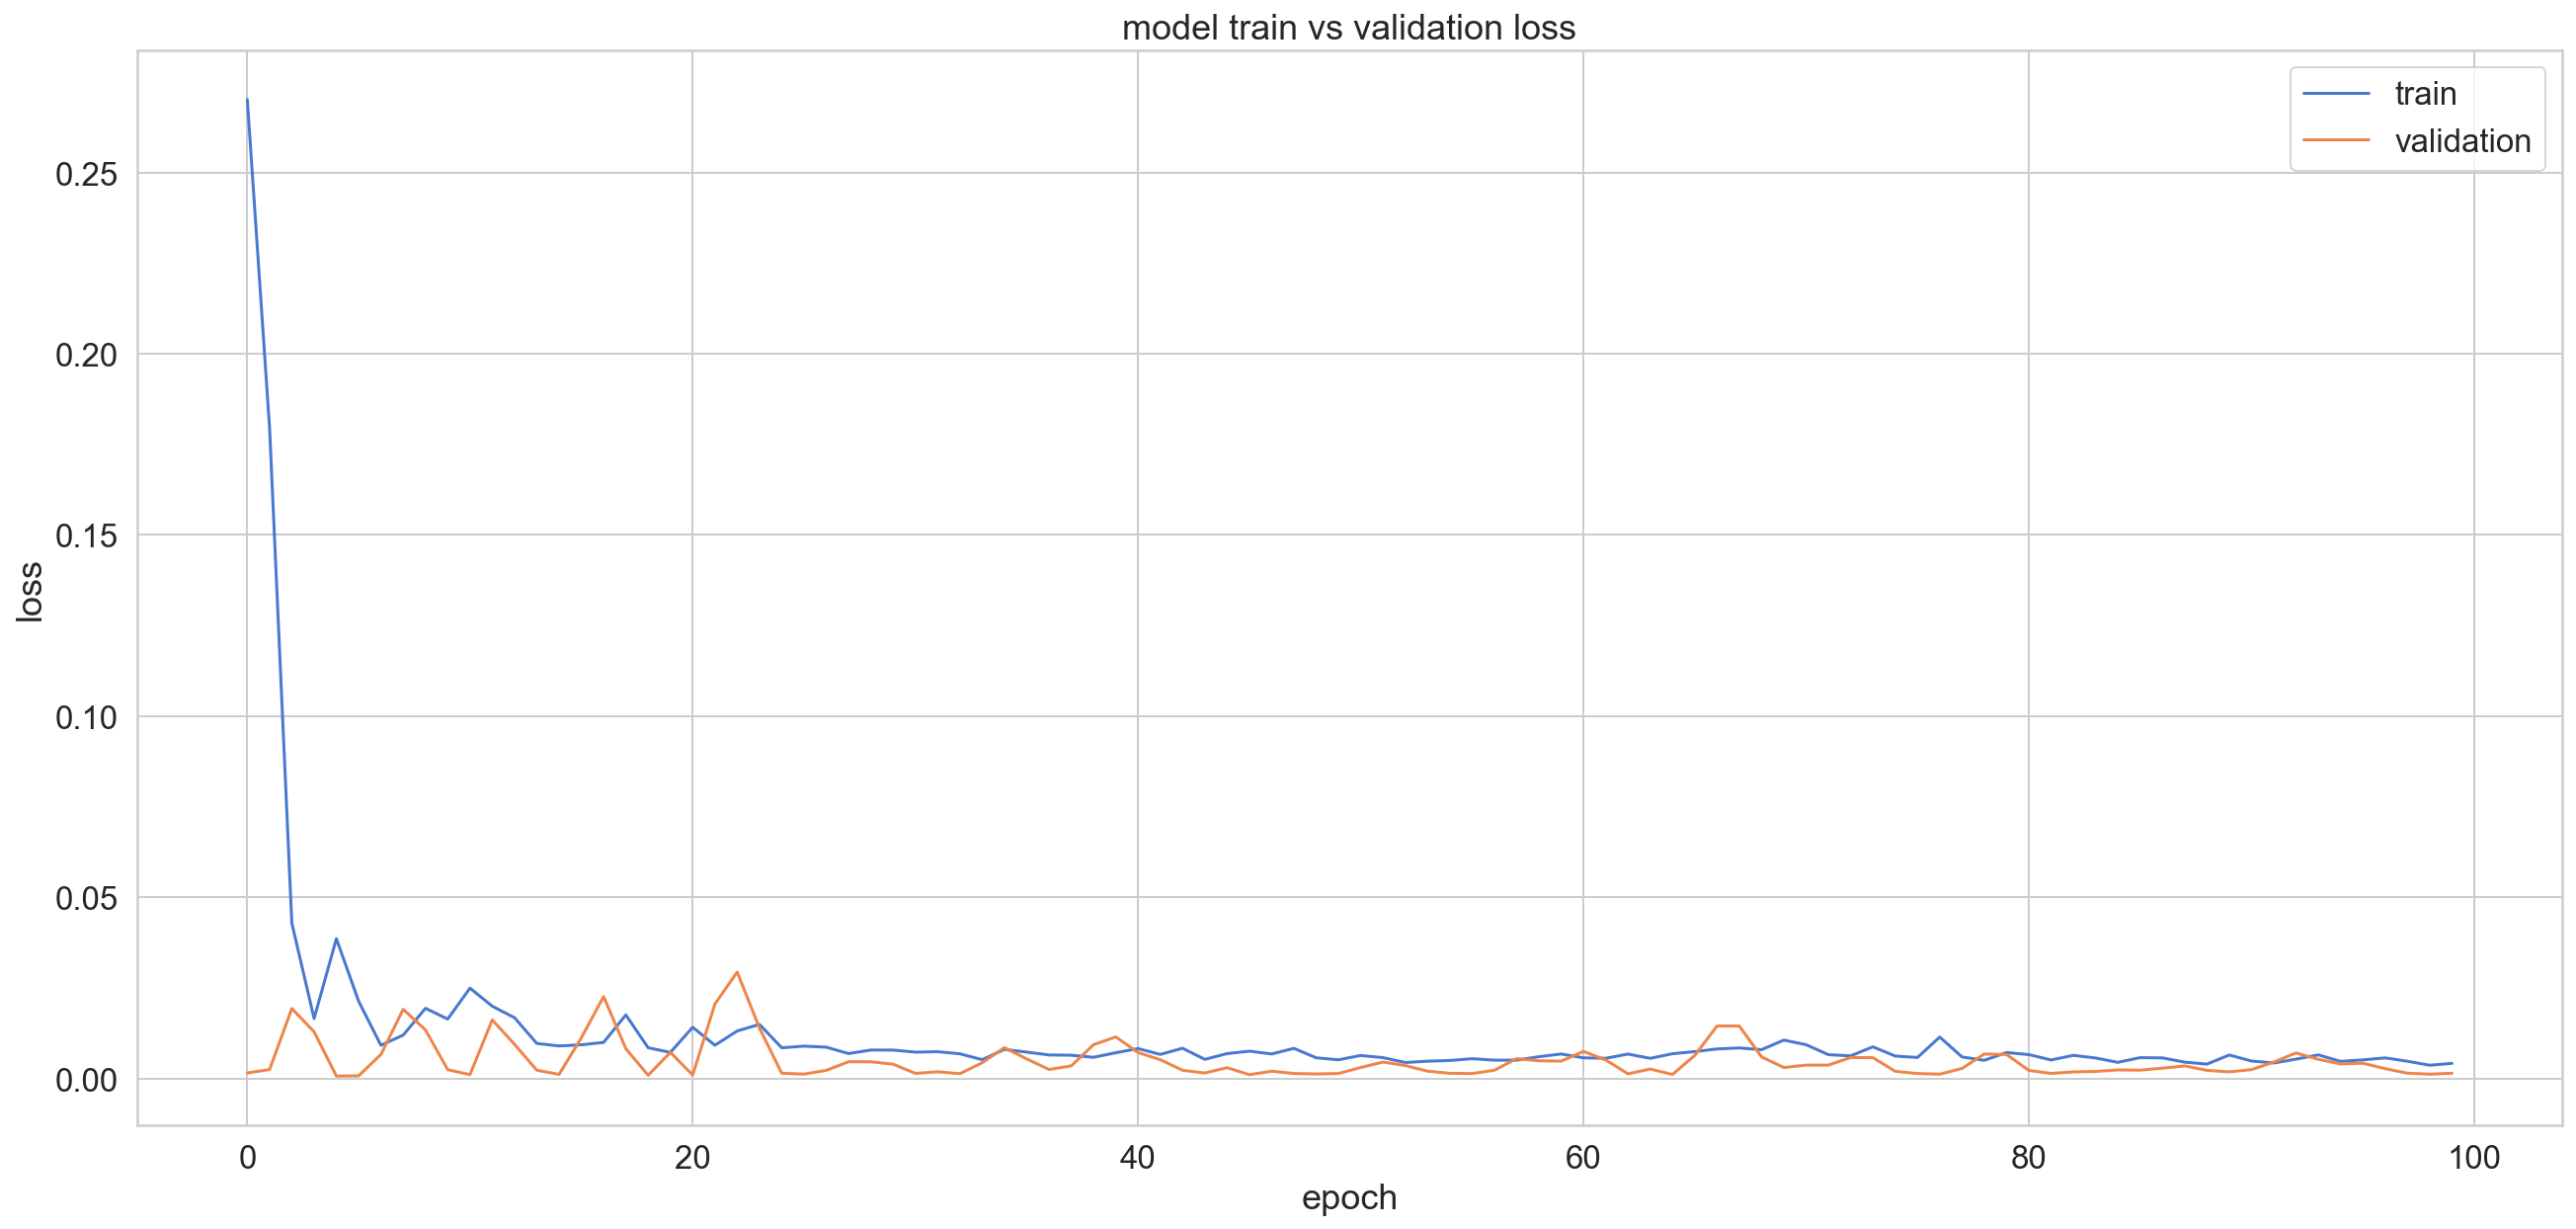

In [677]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [678]:
y_pred = model.predict(X_test)

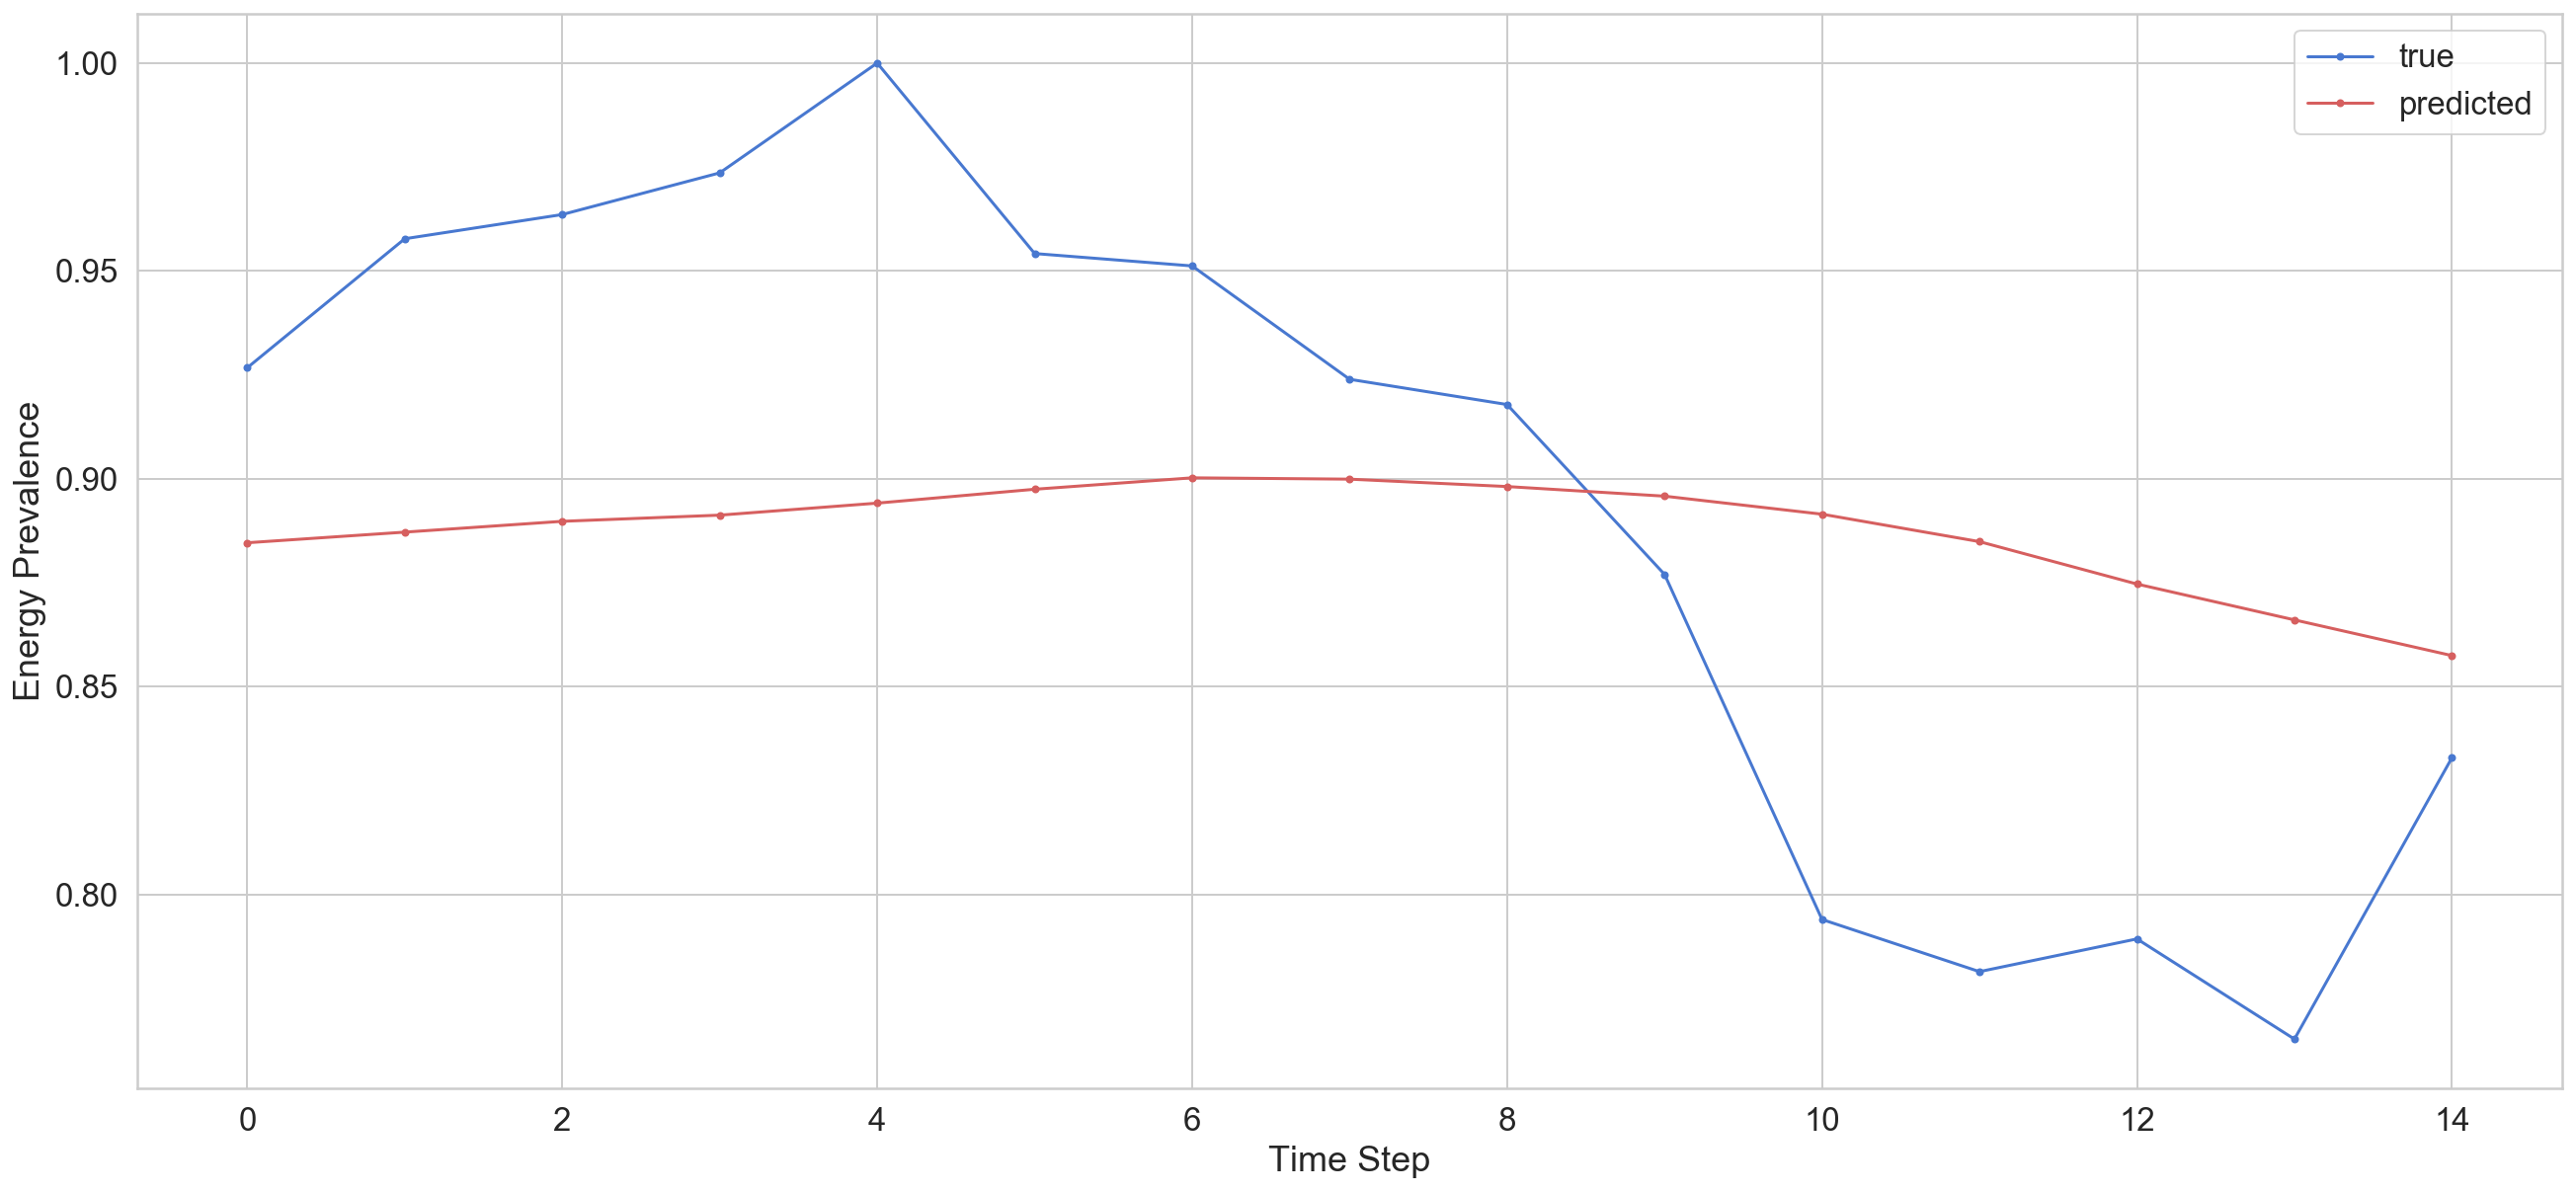

In [679]:
plt.plot(y_test, marker='.', label='true')
plt.plot(y_pred, 'r',marker='.', label='predicted')
plt.ylabel('Energy Prevalence')
plt.xlabel('Time Step')
plt.legend();

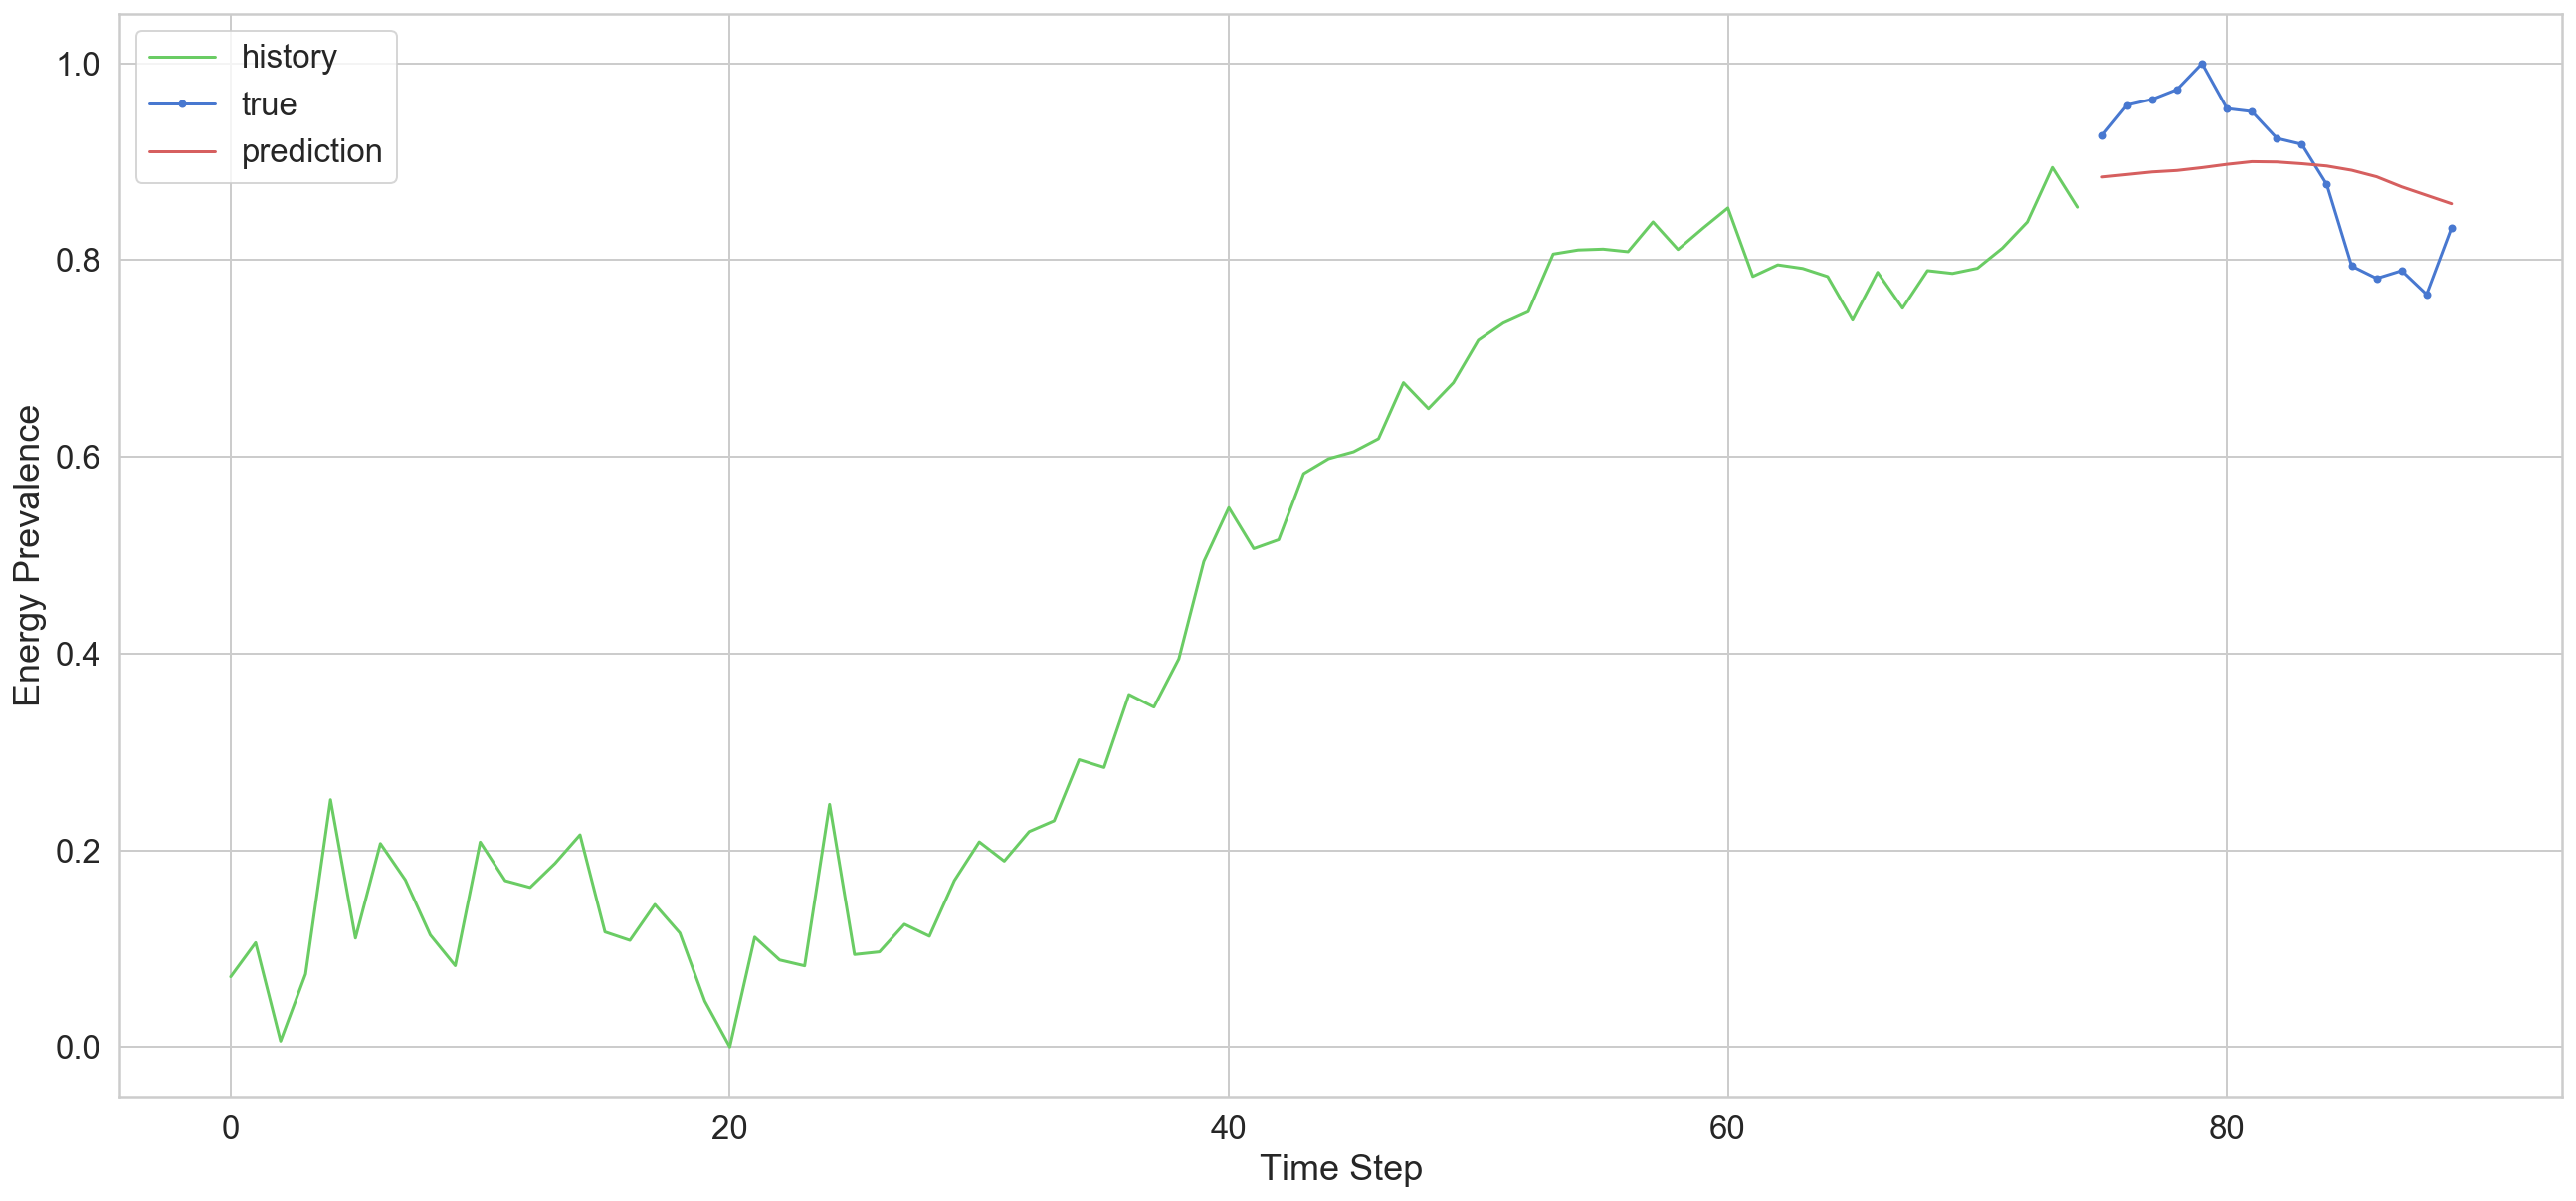

In [680]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Energy Prevalence')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [536]:
df_tss2 = pd.concat(df_ts2, axis=1)

In [726]:
train_size = int(len(df_tss2) * 0.8)
test_size = len(df_tss2) - train_size

train, test = df_tss2.iloc[0:train_size], df_tss2.iloc[train_size:len(df_tss2)]

print(train.shape, test.shape)

(80, 4) (20, 4)


In [727]:
TIME_STEPS = 5 # five years

X_train, y_train = create_dataset(train, train.speechiness, time_steps = TIME_STEPS)
X_test, y_test = create_dataset(test, test.speechiness, time_steps = TIME_STEPS)

In [728]:
model = keras.Sequential()

model.add(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))

model.add(LSTM(units = 64, return_sequences = False))

model.add(Dropout(0.25))

model.add(Dense(units=1, activation = 'linear'))

In [729]:
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate=0.01))

In [730]:
history = model.fit(
    X_train, y_train,
    epochs = 200,
    batch_size = 64,
    validation_split = 0.1,
    shuffle=False
)

Epoch 1/200
2/2 [==============================] - 1s 372ms/step - loss: 0.0724 - val_loss: 0.0012
Epoch 2/200
2/2 [==============================] - 0s 40ms/step - loss: 0.0326 - val_loss: 0.0371
Epoch 3/200
2/2 [==============================] - 0s 34ms/step - loss: 0.0695 - val_loss: 2.2080e-04
Epoch 4/200
2/2 [==============================] - 0s 33ms/step - loss: 0.0354 - val_loss: 0.0069
Epoch 5/200
2/2 [==============================] - 0s 33ms/step - loss: 0.0377 - val_loss: 4.5571e-04
Epoch 6/200
2/2 [==============================] - 0s 30ms/step - loss: 0.0316 - val_loss: 0.0020
Epoch 7/200
2/2 [==============================] - 0s 30ms/step - loss: 0.0356 - val_loss: 0.0038
Epoch 8/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0361 - val_loss: 0.0020
Epoch 9/200
2/2 [==============================] - 0s 33ms/step - loss: 0.0330 - val_loss: 3.0459e-04
Epoch 10/200
2/2 [==============================] - 0s 30ms/step - loss: 0.0278 - val_loss: 4.4487e-04
Ep

2/2 [==============================] - 0s 33ms/step - loss: 0.0062 - val_loss: 7.0065e-04
Epoch 165/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0044 - val_loss: 7.6636e-04
Epoch 166/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0037 - val_loss: 8.6549e-04
Epoch 167/200
2/2 [==============================] - 0s 32ms/step - loss: 0.0055 - val_loss: 9.9525e-04
Epoch 168/200
2/2 [==============================] - 0s 41ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 169/200
2/2 [==============================] - 0s 49ms/step - loss: 0.0038 - val_loss: 0.0011
Epoch 170/200
2/2 [==============================] - 0s 39ms/step - loss: 0.0026 - val_loss: 8.4982e-04
Epoch 171/200
2/2 [==============================] - 0s 40ms/step - loss: 0.0036 - val_loss: 7.1295e-04
Epoch 172/200
2/2 [==============================] - 0s 34ms/step - loss: 0.0030 - val_loss: 9.3303e-04
Epoch 173/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0030 - val

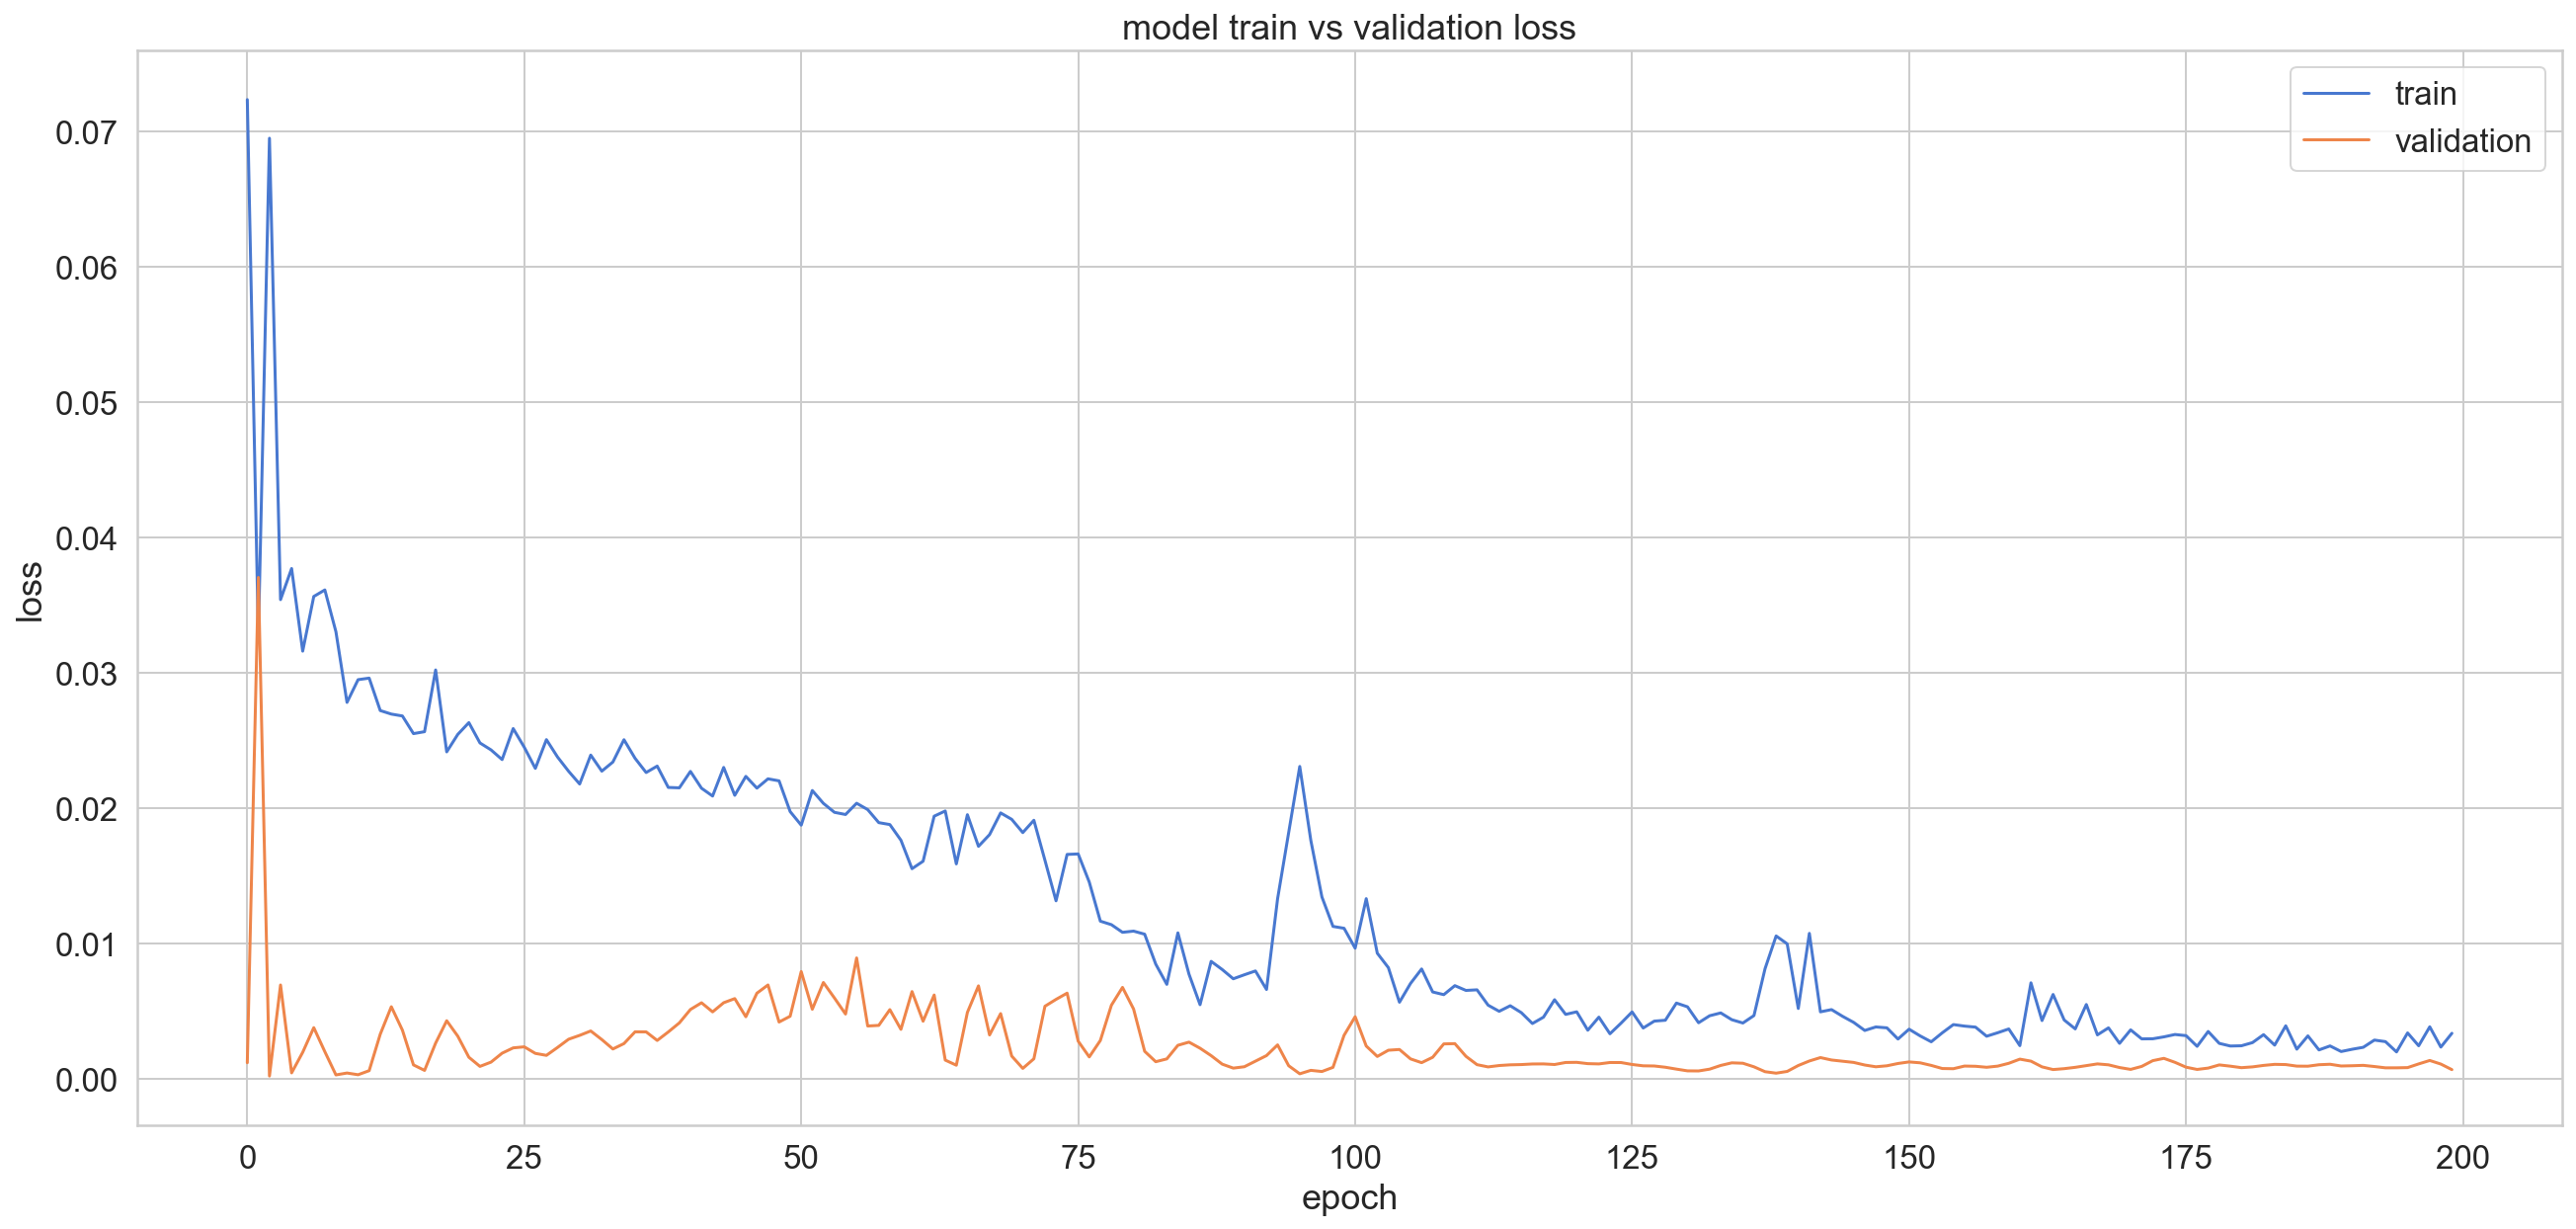

In [731]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [732]:
y_pred = model.predict(X_test)

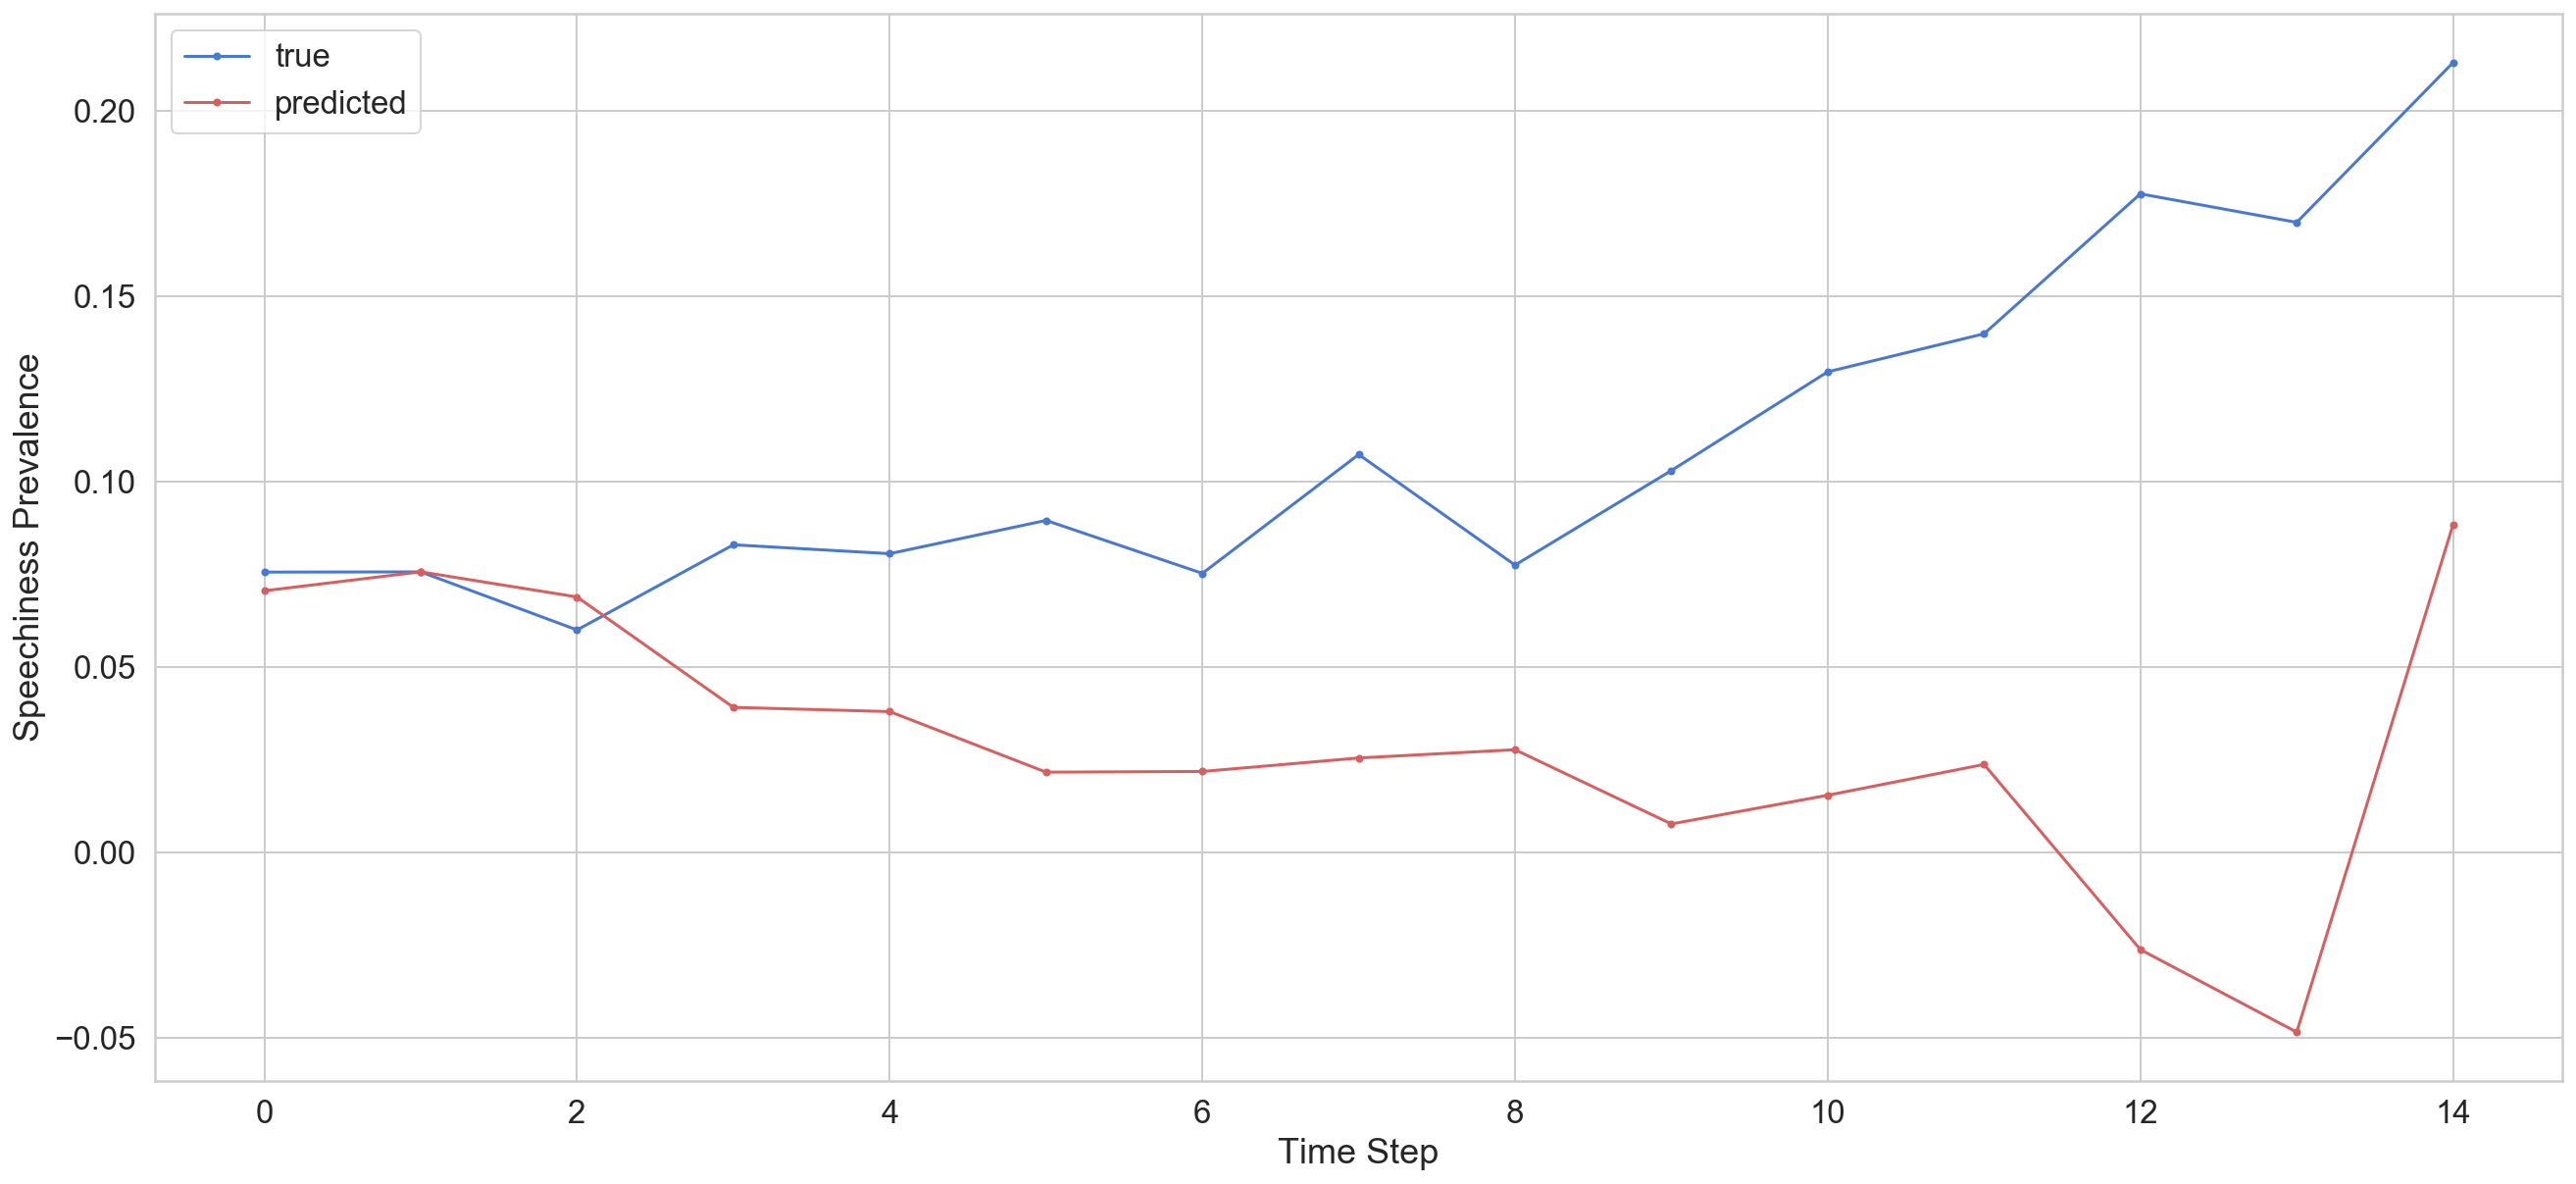

In [733]:
plt.plot(y_test, marker='.', label='true')
plt.plot(y_pred, 'r',marker='.', label='predicted')
plt.ylabel('Speechiness Prevalence')
plt.xlabel('Time Step')
plt.legend();

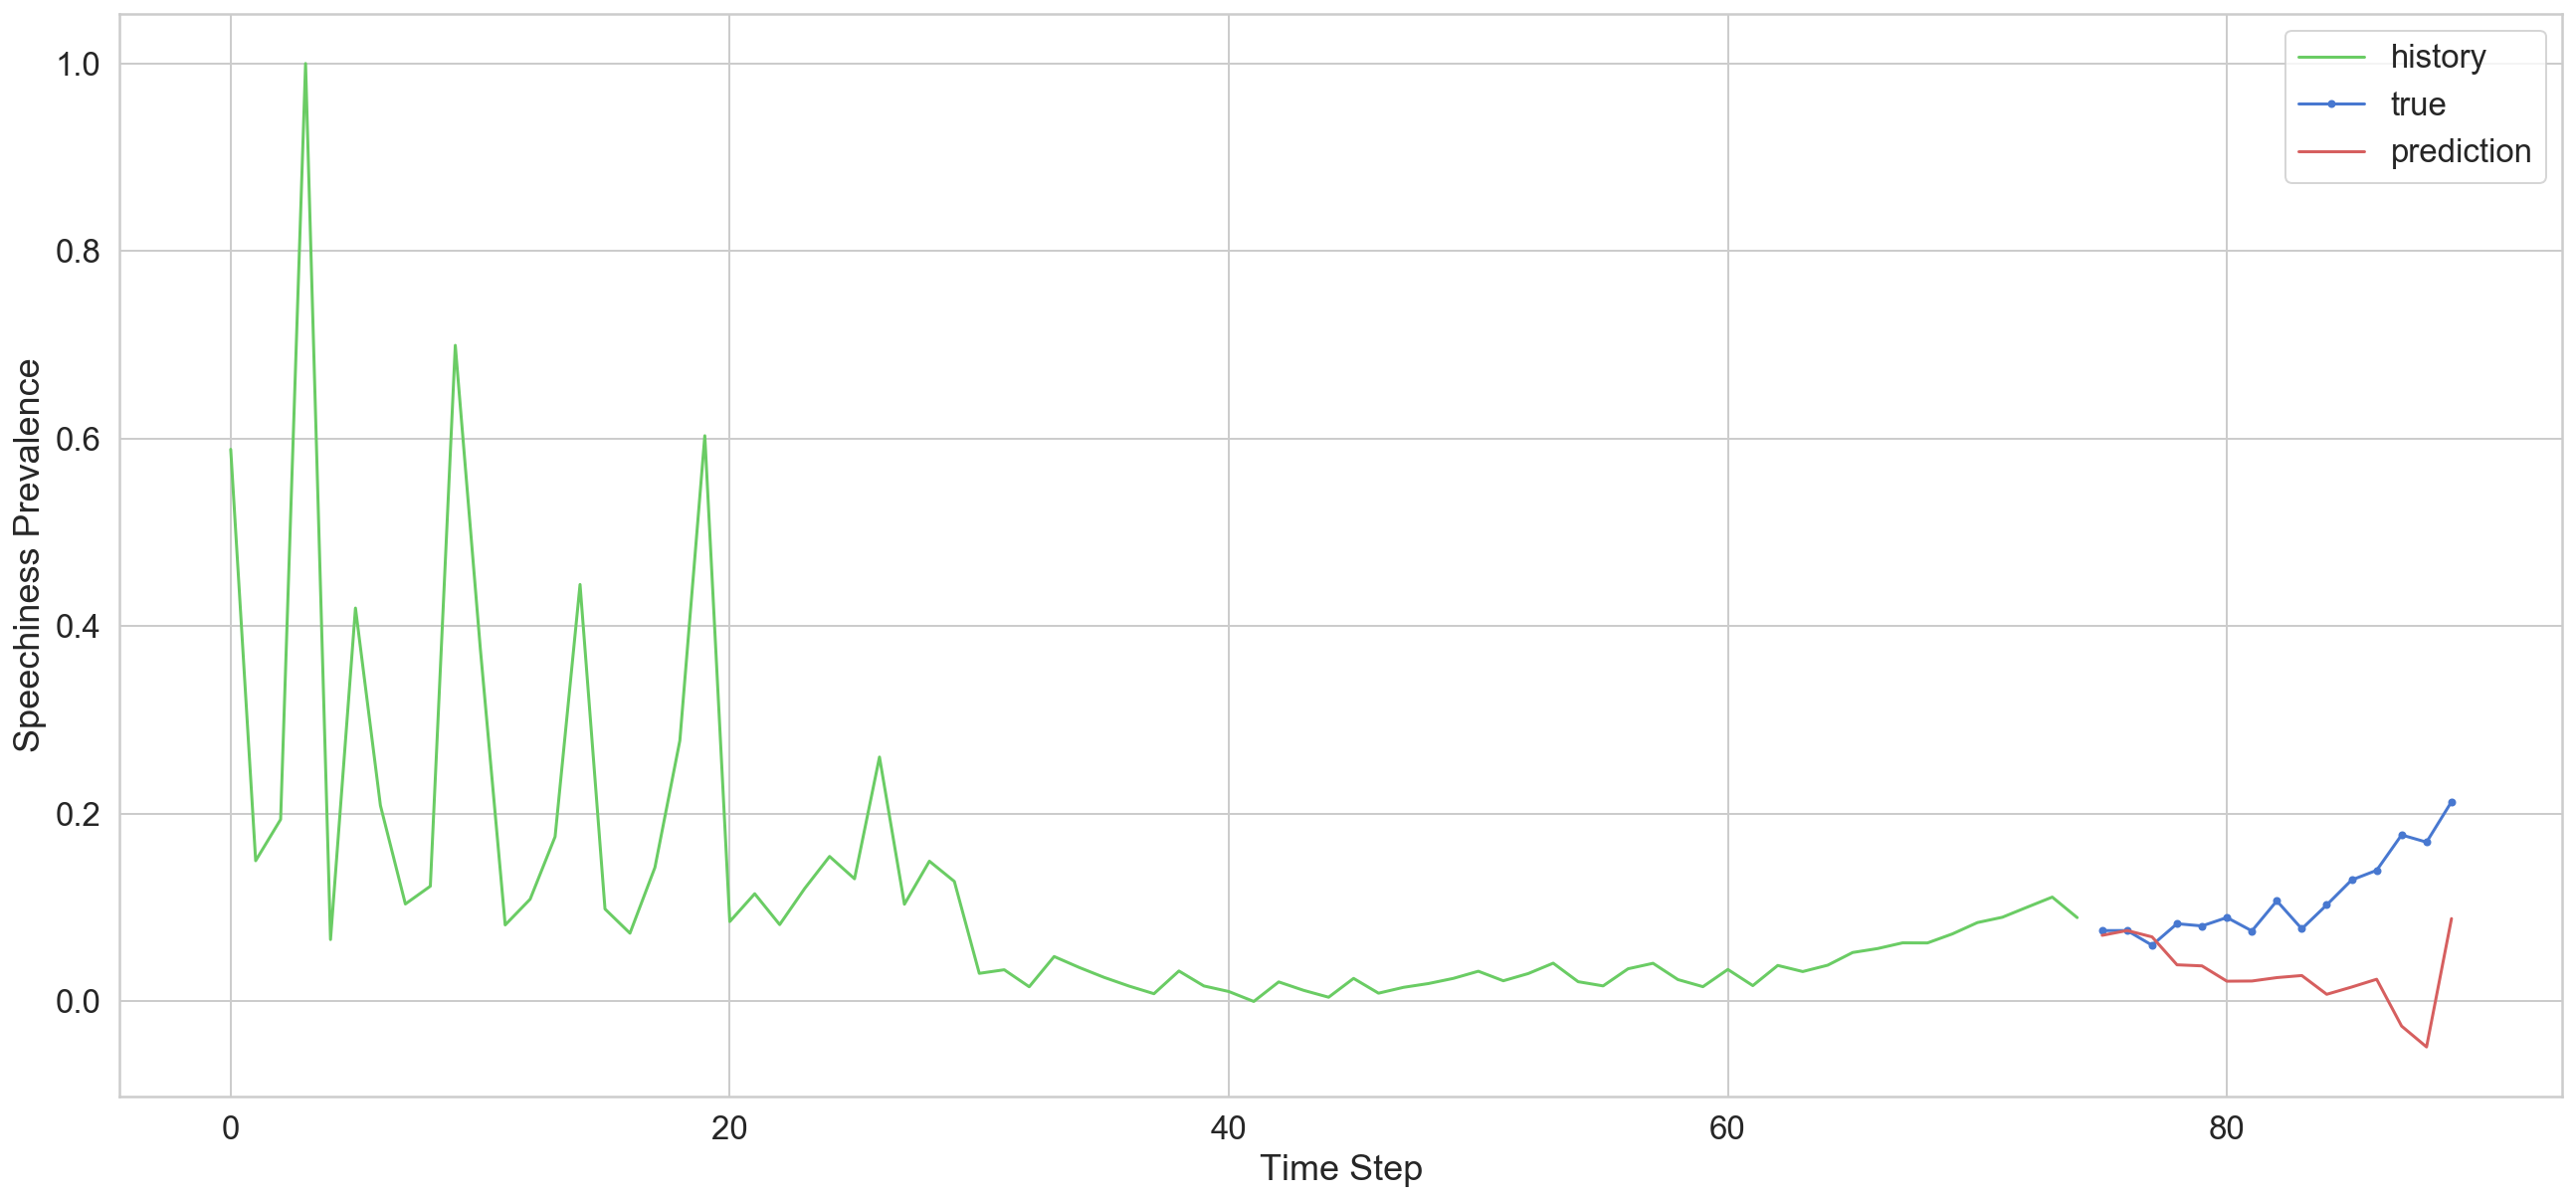

In [734]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Speechiness Prevalence')
plt.xlabel('Time Step')
plt.legend()
plt.show();

# Conclusion for LSTM:

Because an LSTM can use far more information than an ARIMA model, I would recommend using an LSTM above all when engaging in Time Series Analysis.

**The Best LSTM Model of this series:** Multi-Feature LSTM Analysis of Energy Prevalence


## 🎯 Summary and Answers to the Business Tasks

### 1. How musical characteristics changed over time:
- **Valence**, **danceability**, **energy**, and **tempo** were analyzed from 2000 to 2023.
- Trends show:
  - A gradual **decline in valence** after 2010 → music becoming more melancholic.
  - **Energy** and **danceability** remained relatively stable with slight fluctuations.
  - **Tempo** has shown a slight **decline**, aligning with rise of lo-fi, trap, chill genres.

### 2. Genre popularity:
- Visualized as area plot over years. Notable:
  - **Lo-fi**, **trap**, and **folk** genres have increased presence since 2016.
  - More traditional genres (e.g., pop, rock) have seen declining shares.

### 3. Forecasting future trends:
- **ARIMA models** were built for each of the key features.
- Projections until 2030 indicate:
  - **Valence** may continue to decline slightly.
  - **Danceability** and **energy** expected to stay consistent.
  - **Tempo** likely to decrease slowly.

### 4. Musical eras (epochs):
- Applied **KMeans clustering** to standardized yearly feature means.
- Identified 4 distinct **musical eras** based on changes in style/attributes.
- These transitions highlight structural shifts in global music trends.

### 5. External macro-events:
- Placeholder included; ready to add macro indicators (e.g., COVID, economic shifts).
- Plan: correlate macro-trends with music features to discover impact of real-world events.

### 6. How previous tasks help define future eras:
- If genres and moods were clustered in earlier steps (e.g., PCA + clustering for playlists), their centroids over time could feed into **era detection**.
- Predictive models for genre or hit potential help **inform** which features may dominate the next era.

---

This notebook provides a **foundation for strategic forecasting** and insight extraction, serving as a key tool for music platform decision-making.
